In [1]:
import gc
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.offline

from colorama import Fore, Style, init
from pprint import pprint

# 🚫 Suppressing warnings 🚫
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates
import seaborn as sns

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.offline

from scipy.stats import entropy
from collections import Counter
import polars as pl

from joblib import Parallel, delayed
from time import sleep, time
from multiprocessing import cpu_count

from tqdm.auto import tqdm 
from concurrent.futures import ThreadPoolExecutor

import os

# Reading the train data

In [2]:
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
len(train)

3960

In [3]:
# Group by 'sii' and count occurrences, including NaN as a category
sii_counts = train['sii'].value_counts(dropna=False)

# Calculate percentages
sii_percentages = (sii_counts / sii_counts.sum()) * 100

# Create a DataFrame to display counts and percentages together
sii_summary = pd.DataFrame({
    'Count': sii_counts,
    'Percentage': sii_percentages
})

# Display the summary
print(sii_summary)

     Count  Percentage
sii                   
0.0   1594   40.252525
NaN   1224   30.909091
1.0    730   18.434343
2.0    378    9.545455
3.0     34    0.858586


In [4]:
filtered_train = train[train['sii'].isin([0, 1, 2, 3])]

# Group by 'sii' and count occurrences, including NaN as a category
sii_counts = filtered_train['sii'].value_counts(dropna=False)

# Calculate percentages
sii_percentages = (sii_counts / sii_counts.sum()) * 100

# Create a DataFrame to display counts and percentages together
sii_summary = pd.DataFrame({
    'Count': sii_counts,
    'Percentage': sii_percentages
})

# Display the summary
print(sii_summary)

     Count  Percentage
sii                   
0.0   1594   58.260234
1.0    730   26.681287
2.0    378   13.815789
3.0     34    1.242690


# Reading the test data

In [5]:
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
len(test)

20

# Which variables are avaiable

In [6]:
df = filtered_train
df.columns

Index(['id', 'Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
       'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
       'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
       'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
       'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
       'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
       'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
       'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
       'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
       'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
       'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
       'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
       'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
       'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST'

In [7]:
len(df)

2736

In [8]:
df.head(5)

id Basic_Demos-Enroll_Season  Basic_Demos-Age  Basic_Demos-Sex  \
0  00008ff9                      Fall                5                0   
1  000fd460                    Summer                9                0   
2  00105258                    Summer               10                1   
3  00115b9f                    Winter                9                0   
5  001f3379                    Spring               13                1   

  CGAS-Season  CGAS-CGAS_Score Physical-Season  Physical-BMI  Physical-Height  \
0      Winter             51.0            Fall     16.877316             46.0   
1         NaN              NaN            Fall     14.035590             48.0   
2        Fall             71.0            Fall     16.648696             56.5   
3        Fall             71.0          Summer     18.292347             56.0   
5      Winter             50.0          Summer     22.279952             59.5   

   Physical-Weight  ...  PCIAT-PCIAT_18  PCIAT-PCIAT_19  PCIAT-PCIAT_20  \
0             50.8  ...             4.0             2.0             4.0   
1             46.0  ...             0.0             0.0             0.0   
2             75.6  ...             2.0             1.0             1.0   
3             81.6  ...             3.0             4.0             1.0   
5            112.2  ...             1.0             2.0             1.0   

   PCIAT-PCIAT_Total SDS-Season  SDS-SDS_Total_Raw  SDS-SDS_Total_T  \
0               55.0        NaN                NaN              NaN   
1                0.0       Fall               46.0             64.0   
2               28.0       Fall               38.0             54.0   
3               44.0     Summer               31.0             45.0   
5               34.0     Summer               40.0             56.0   

   PreInt_EduHx-Season PreInt_EduHx-computerinternet_hoursday  sii  
0                 Fall                                    3.0  2.0  
1               Summer                                    0.0  0.0  
2               Summer                                    2.0  0.0  
3               Winter                                    0.0  1.0  
5               Spring                                    0.0  1.0  

[5 rows x 82 columns]

In [9]:
columns_to_convert = [
    'Basic_Demos-Sex', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND_Zone',
    'FGC-FGC_GSD_Zone', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone',
    'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone', 'BIA-BIA_Activity_Level_num',
    'BIA-BIA_Frame_num', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02',
    'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05',
    'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08',
    'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11',
    'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14',
    'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17',
    'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20'
]

# Convert to categorical and add 'NaN' as a category
for column in columns_to_convert:
    df[column] = df[column].astype('category')
    df[column] = df[column].cat.add_categories(['NaN'])  # Add 'NaN' as a category
    df[column] = df[column].fillna('NaN')  # Fill NaN values with 'NaN'

In [10]:
# Step 1: Identify numeric and categorical columns
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
numeric_columns = [col for col in numeric_columns if col != 'sii']  # Exclude 'sii'

# Step 2: Create bins for numeric columns
for col in numeric_columns:
    # Ensure the column is numeric
    df[col] = pd.to_numeric(df[col], errors='coerce')

    # Create 10 bins and get the bin edges
    bin_edges = pd.cut(df[col], bins=10, retbins=True)[1]

    # Create bin labels with ranges, ordered by the bin edges
    bin_labels = []
    for i in range(len(bin_edges) - 1):
        bin_labels.append(f"{i} - ({bin_edges[i]:.3f}, {bin_edges[i + 1]:.3f})")

    # Assign the bin labels to the bins
    bins = pd.cut(df[col], bins=bin_edges, labels=bin_labels, include_lowest=True)

    # Assign binned labels to a new column
    df[col + '_binned'] = bins.astype(str)

# Step 3: Drop the original numeric columns
df = df.drop(columns=numeric_columns)

# Step 4: Move 'sii' column to the end
if 'sii' in df.columns:
    sii_column = df.pop('sii')  # Remove 'sii' from its current position
    df['sii'] = sii_column  # Add it back at the end

In [11]:
df.head()

id Basic_Demos-Enroll_Season Basic_Demos-Sex CGAS-Season  \
0  00008ff9                      Fall               0      Winter   
1  000fd460                    Summer               0         NaN   
2  00105258                    Summer               1        Fall   
3  00115b9f                    Winter               0        Fall   
5  001f3379                    Spring               1      Winter   

  Physical-Season Fitness_Endurance-Season FGC-Season FGC-FGC_CU_Zone  \
0            Fall                      NaN       Fall             0.0   
1            Fall                      NaN       Fall             0.0   
2            Fall                     Fall       Fall             1.0   
3          Summer                   Summer     Summer             1.0   
5          Summer                      NaN     Summer             0.0   

  FGC-FGC_GSND_Zone FGC-FGC_GSD_Zone  ...     BIA-BIA_LST_binned  \
0               NaN              NaN  ...  0 - (18.960, 489.629)   
1               NaN              NaN  ...  0 - (18.960, 489.629)   
2               1.0              2.0  ...                    nan   
3               NaN              NaN  ...  0 - (18.960, 489.629)   
5               2.0              2.0  ...  0 - (18.960, 489.629)   

     BIA-BIA_SMM_binned     BIA-BIA_TBW_binned PAQ_A-PAQ_A_Total_binned  \
0  0 - (7.786, 371.013)  0 - (14.919, 587.621)                      nan   
1  0 - (7.786, 371.013)  0 - (14.919, 587.621)                      nan   
2                   nan                    nan                      nan   
3  0 - (7.786, 371.013)  0 - (14.919, 587.621)                      nan   
5  0 - (7.786, 371.013)  0 - (14.919, 587.621)                      nan   

  PAQ_C-PAQ_C_Total_binned PCIAT-PCIAT_Total_binned SDS-SDS_Total_Raw_binned  \
0                      nan     5 - (46.500, 55.800)                      nan   
1       4 - (2.264, 2.685)      0 - (-0.093, 9.300)     3 - (40.700, 48.600)   
2       3 - (1.843, 2.264)     3 - (27.900, 37.200)     2 - (32.800, 40.700)   
3       4 - (2.264, 2.685)     4 - (37.200, 46.500)     1 - (24.900, 32.800)   
5       8 - (3.948, 4.369)     3 - (27.900, 37.200)     2 - (32.800, 40.700)   

  SDS-SDS_Total_T_binned PreInt_EduHx-computerinternet_hoursday_binned  sii  
0                    nan                            9 - (2.700, 3.000)  2.0  
1   4 - (62.800, 69.000)                           0 - (-0.003, 0.300)  0.0  
2   2 - (50.400, 56.600)                            6 - (1.800, 2.100)  0.0  
3   1 - (44.200, 50.400)                           0 - (-0.003, 0.300)  1.0  
5   2 - (50.400, 56.600)                           0 - (-0.003, 0.300)  1.0  

[5 rows x 82 columns]

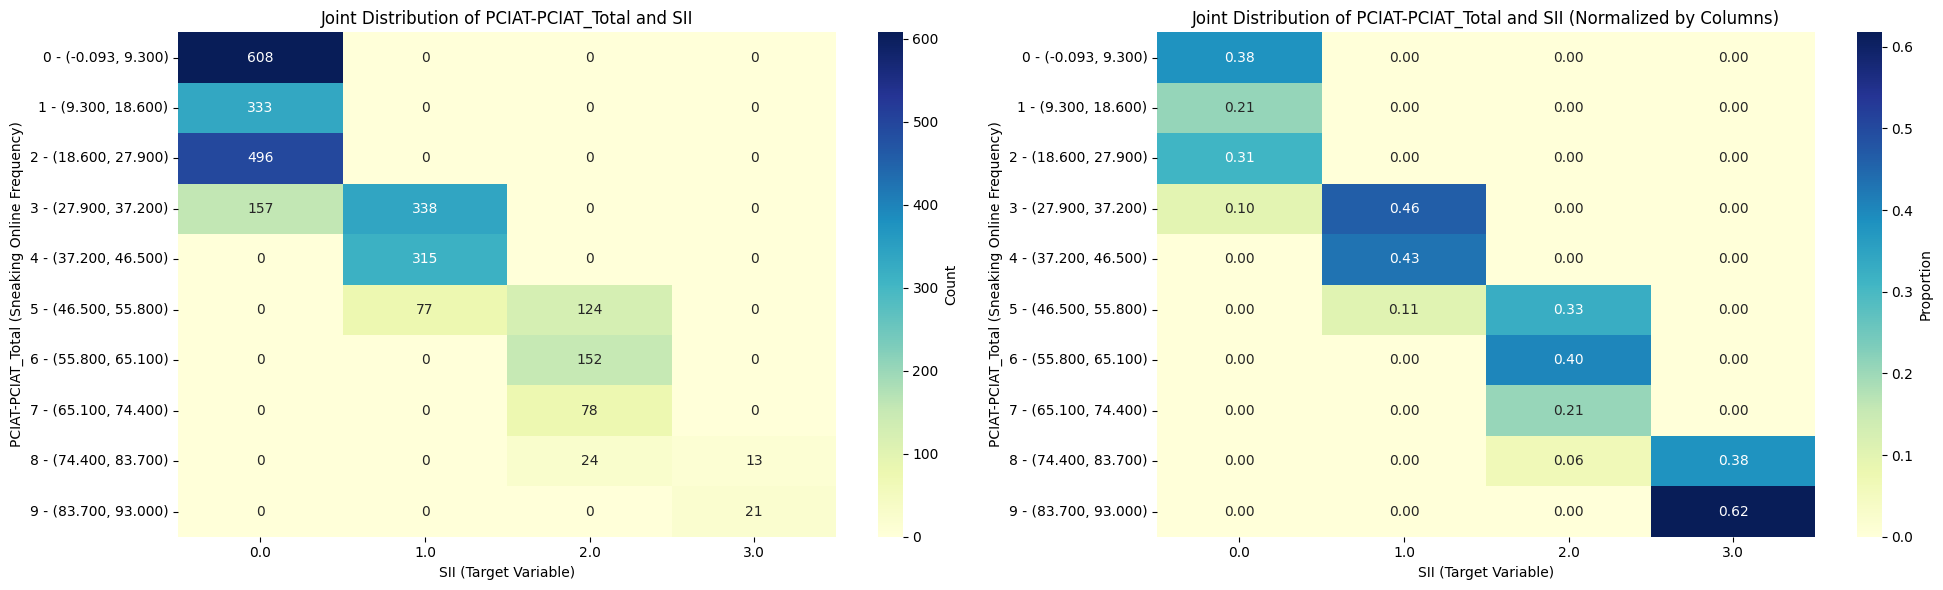

In [12]:
# Create a figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# First heatmap: Joint Distribution of PCIAT-PCIAT_Total and SII
contingency_table = pd.crosstab(df['PCIAT-PCIAT_Total_binned'], df['sii'])
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='YlGnBu', cbar_kws={'label': 'Count'}, ax=axes[0])
axes[0].set_title('Joint Distribution of PCIAT-PCIAT_Total and SII')
axes[0].set_xlabel('SII (Target Variable)')
axes[0].set_ylabel('PCIAT-PCIAT_Total (Sneaking Online Frequency)')
axes[0].tick_params(axis='x', rotation=0)

# Second heatmap: Normalized by columns
# Normalize the contingency table by column sums
normalized_table = contingency_table.div(contingency_table.sum(axis=0), axis=1)
sns.heatmap(normalized_table, annot=True, fmt='.2f', cmap='YlGnBu', cbar_kws={'label': 'Proportion'}, ax=axes[1])
axes[1].set_title('Joint Distribution of PCIAT-PCIAT_Total and SII (Normalized by Columns)')
axes[1].set_xlabel('SII (Target Variable)')
axes[1].set_ylabel('PCIAT-PCIAT_Total (Sneaking Online Frequency)')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

#this one seems like the target right????

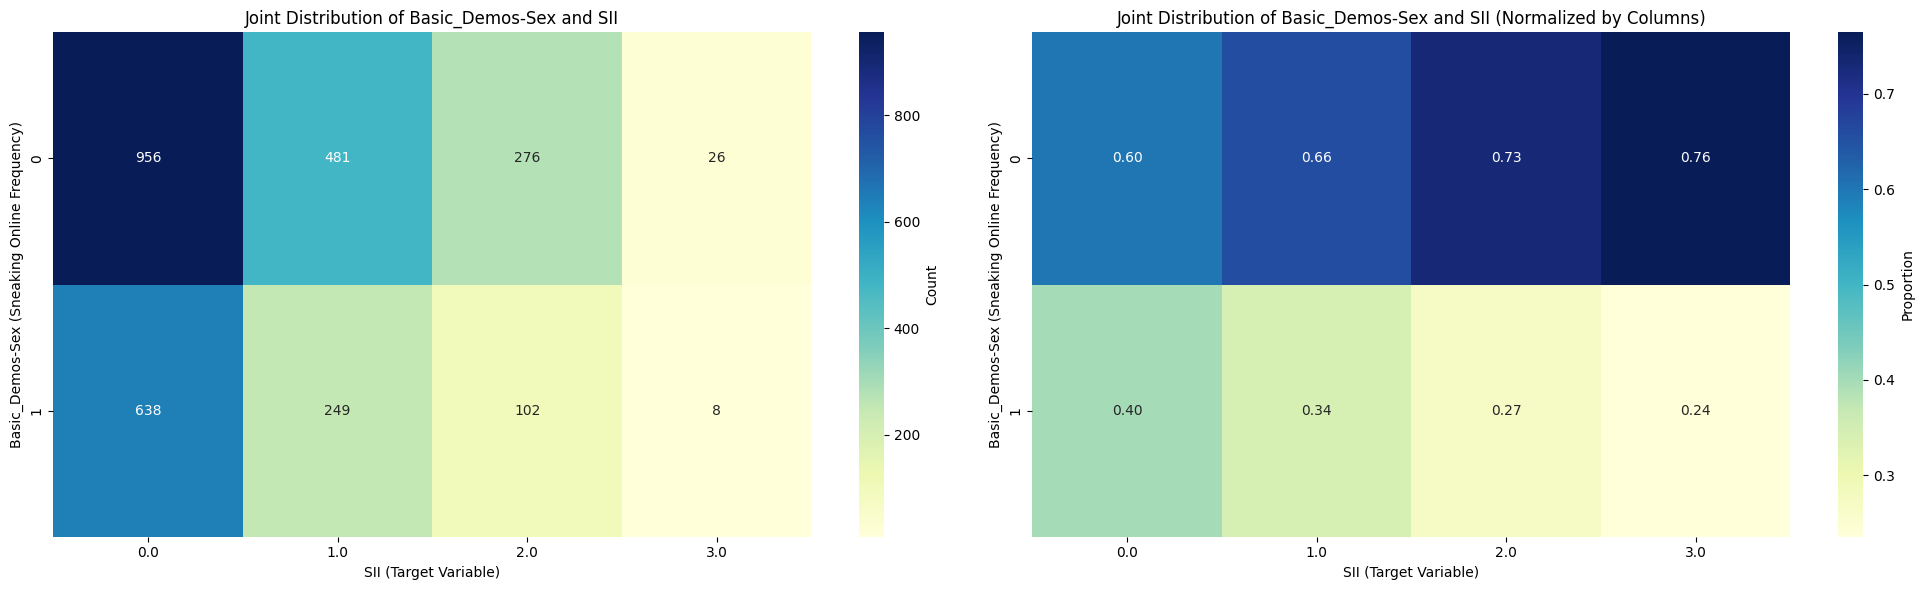

In [13]:
# Create a figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# First heatmap: Joint Distribution of PCIAT-PCIAT_Total and SII
contingency_table = pd.crosstab(df['Basic_Demos-Sex'], df['sii'])
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='YlGnBu', cbar_kws={'label': 'Count'}, ax=axes[0])
axes[0].set_title('Joint Distribution of Basic_Demos-Sex and SII')
axes[0].set_xlabel('SII (Target Variable)')
axes[0].set_ylabel('Basic_Demos-Sex (Sneaking Online Frequency)')
axes[0].tick_params(axis='x', rotation=0)

# Second heatmap: Normalized by columns
# Normalize the contingency table by column sums
normalized_table = contingency_table.div(contingency_table.sum(axis=0), axis=1)
sns.heatmap(normalized_table, annot=True, fmt='.2f', cmap='YlGnBu', cbar_kws={'label': 'Proportion'}, ax=axes[1])
axes[1].set_title('Joint Distribution of Basic_Demos-Sex and SII (Normalized by Columns)')
axes[1].set_xlabel('SII (Target Variable)')
axes[1].set_ylabel('Basic_Demos-Sex (Sneaking Online Frequency)')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()


In [14]:
df.columns

Index(['id', 'Basic_Demos-Enroll_Season', 'Basic_Demos-Sex', 'CGAS-Season',
       'Physical-Season', 'Fitness_Endurance-Season', 'FGC-Season',
       'FGC-FGC_CU_Zone', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD_Zone',
       'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone',
       'FGC-FGC_TL_Zone', 'BIA-Season', 'BIA-BIA_Activity_Level_num',
       'BIA-BIA_Frame_num', 'PAQ_A-Season', 'PAQ_C-Season', 'PCIAT-Season',
       'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04',
       'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08',
       'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12',
       'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16',
       'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20',
       'SDS-Season', 'PreInt_EduHx-Season', 'Basic_Demos-Age_binned',
       'CGAS-CGAS_Score_binned', 'Physical-BMI_binned',
       'Physical-Height_binned', 'Physical-Weight_binned

In [16]:
len(df)

2736

In [17]:
df.groupby('sii').size()

sii
0.0    1594
1.0     730
2.0     378
3.0      34
dtype: int64

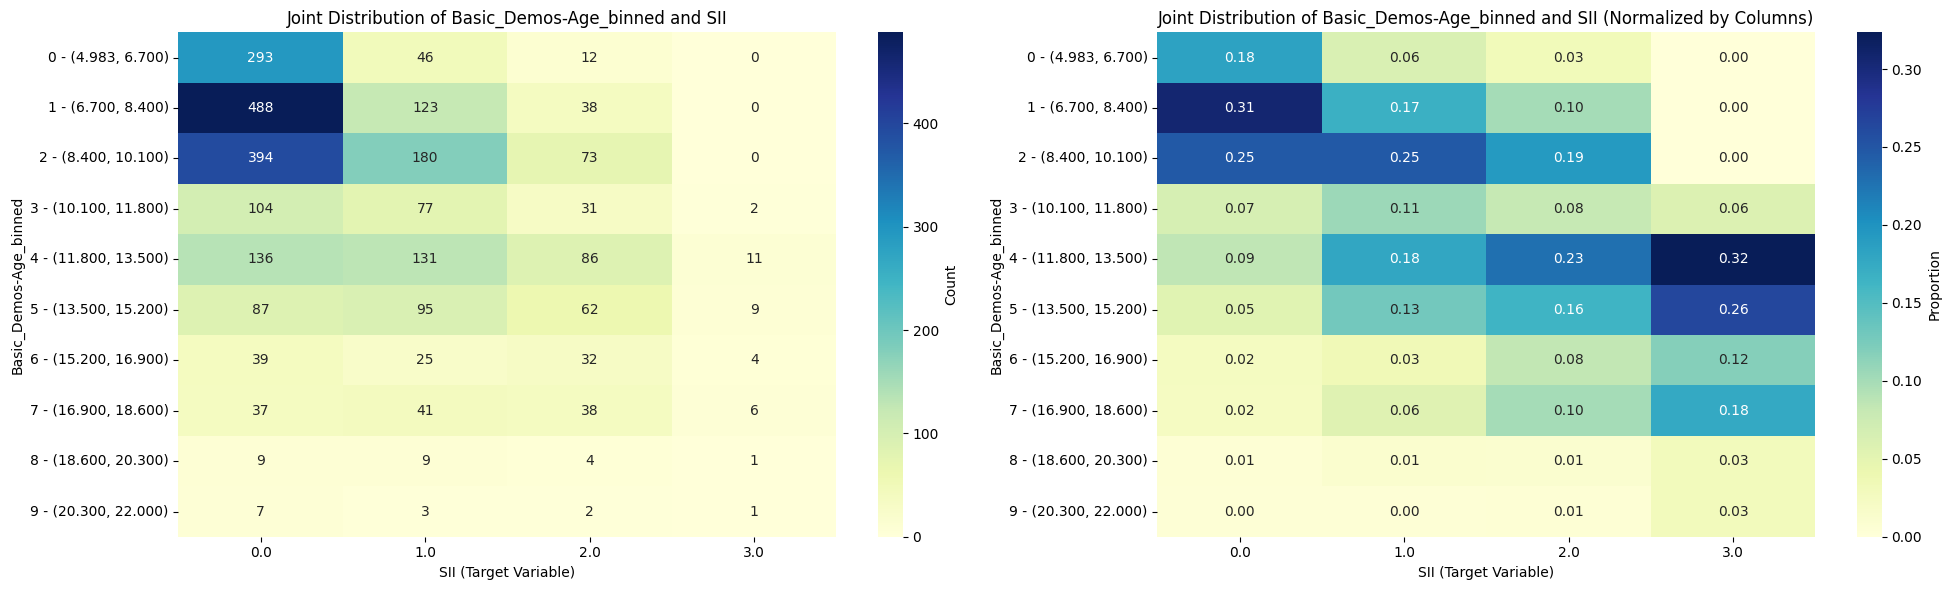

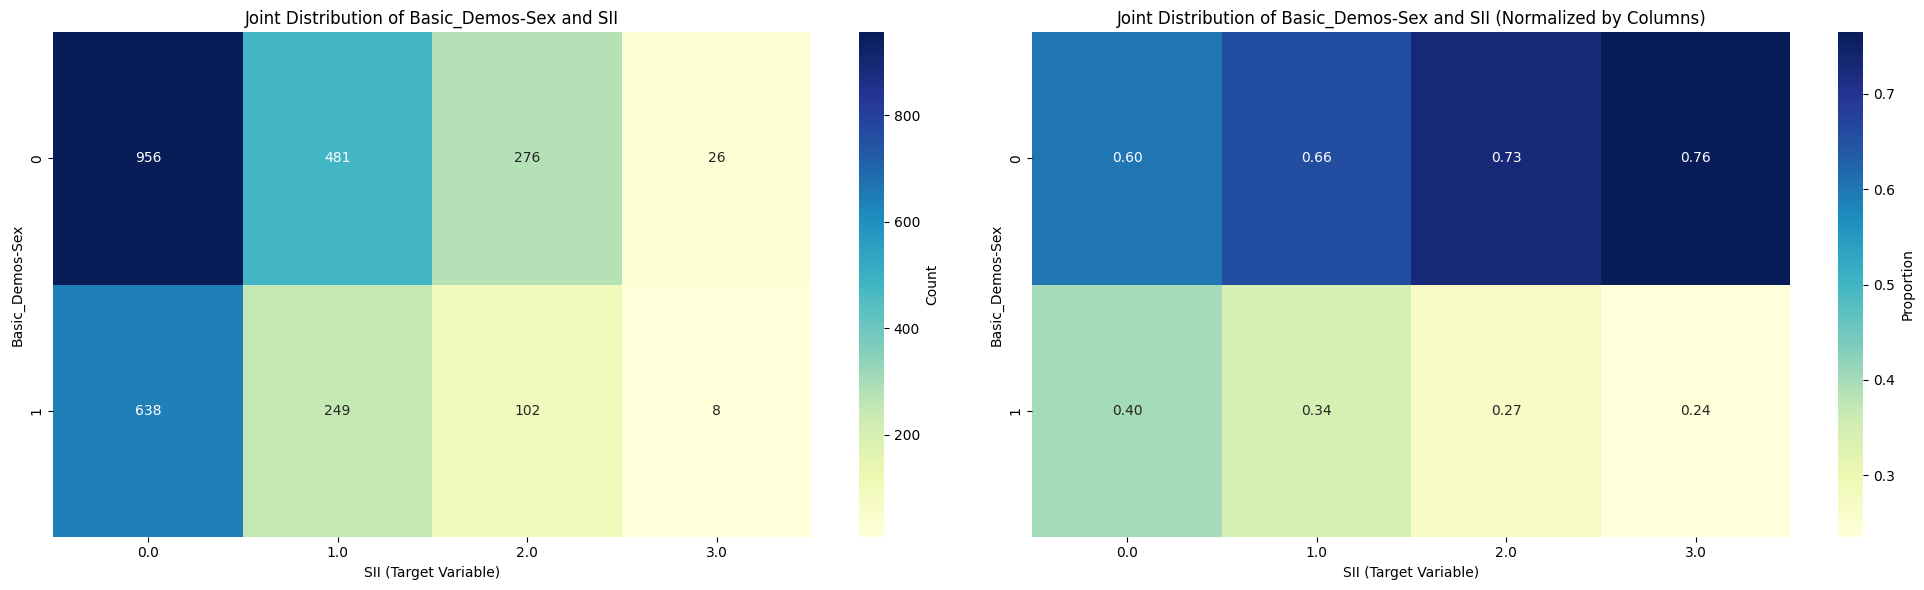

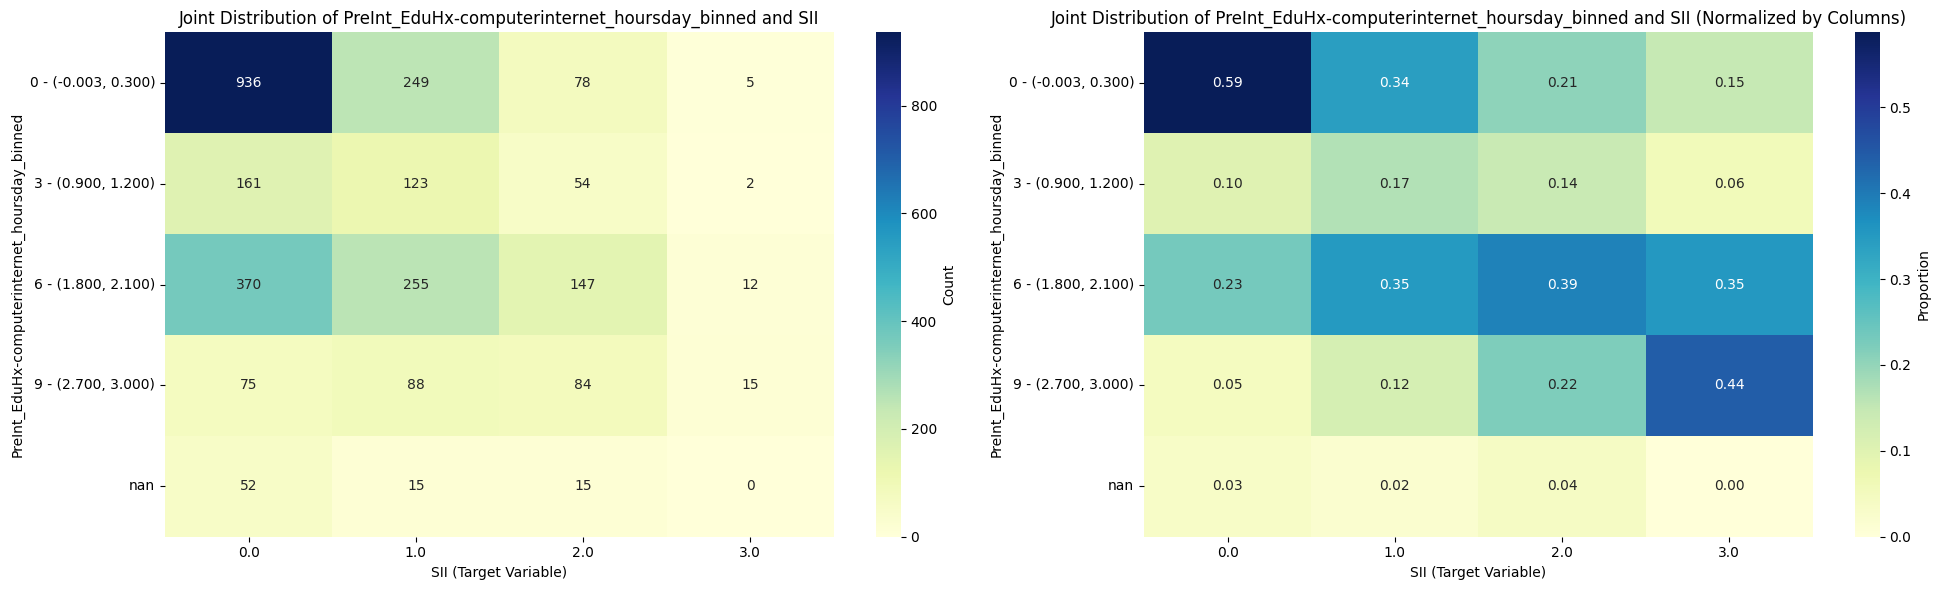

In [20]:
variables = [
'Basic_Demos-Age_binned', 'Basic_Demos-Sex', 
       'PreInt_EduHx-computerinternet_hoursday_binned'
]

# Loop through each variable and create heatmaps
for variable in variables:
    # Fill NaN values with a placeholder
    df[variable] = df[variable].fillna('NaN')
    
    # Create a contingency table
    contingency_table = pd.crosstab(df[variable], df['sii'])

    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

    # First heatmap: Absolute counts
    sns.heatmap(contingency_table, annot=True, fmt='d', cmap='YlGnBu', cbar_kws={'label': 'Count'}, ax=axes[0])
    axes[0].set_title(f'Joint Distribution of {variable} and SII')
    axes[0].set_xlabel('SII (Target Variable)')
    axes[0].set_ylabel(variable)
    axes[0].tick_params(axis='x', rotation=0)

    # Second heatmap: Normalized by columns
    normalized_table = contingency_table.div(contingency_table.sum(axis=0), axis=1)
    sns.heatmap(normalized_table, annot=True, fmt='.2f', cmap='YlGnBu', cbar_kws={'label': 'Proportion'}, ax=axes[1])
    axes[1].set_title(f'Joint Distribution of {variable} and SII (Normalized by Columns)')
    axes[1].set_xlabel('SII (Target Variable)')
    axes[1].set_ylabel(variable)
    axes[1].tick_params(axis='x', rotation=0)

    plt.tight_layout()
    plt.show()

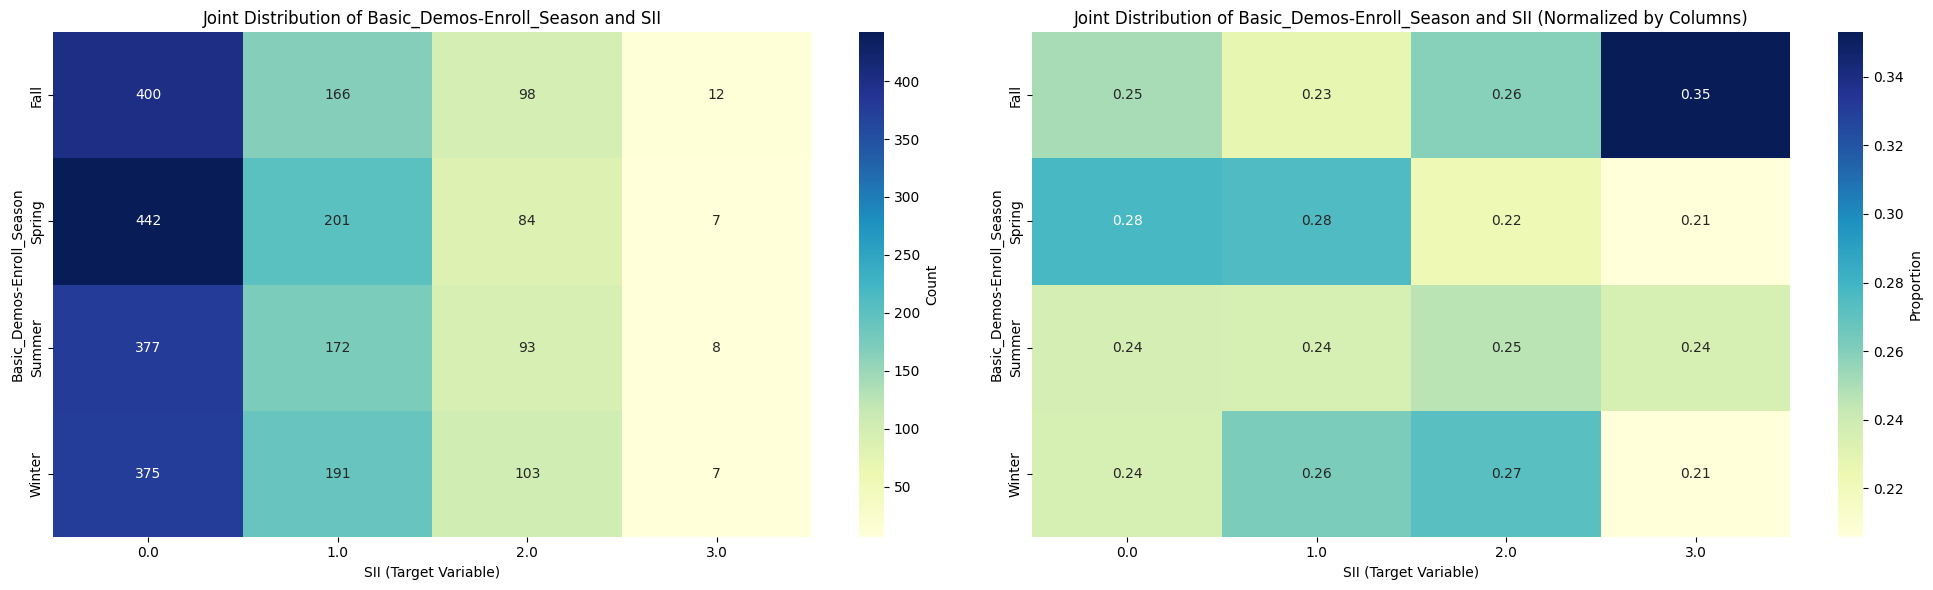

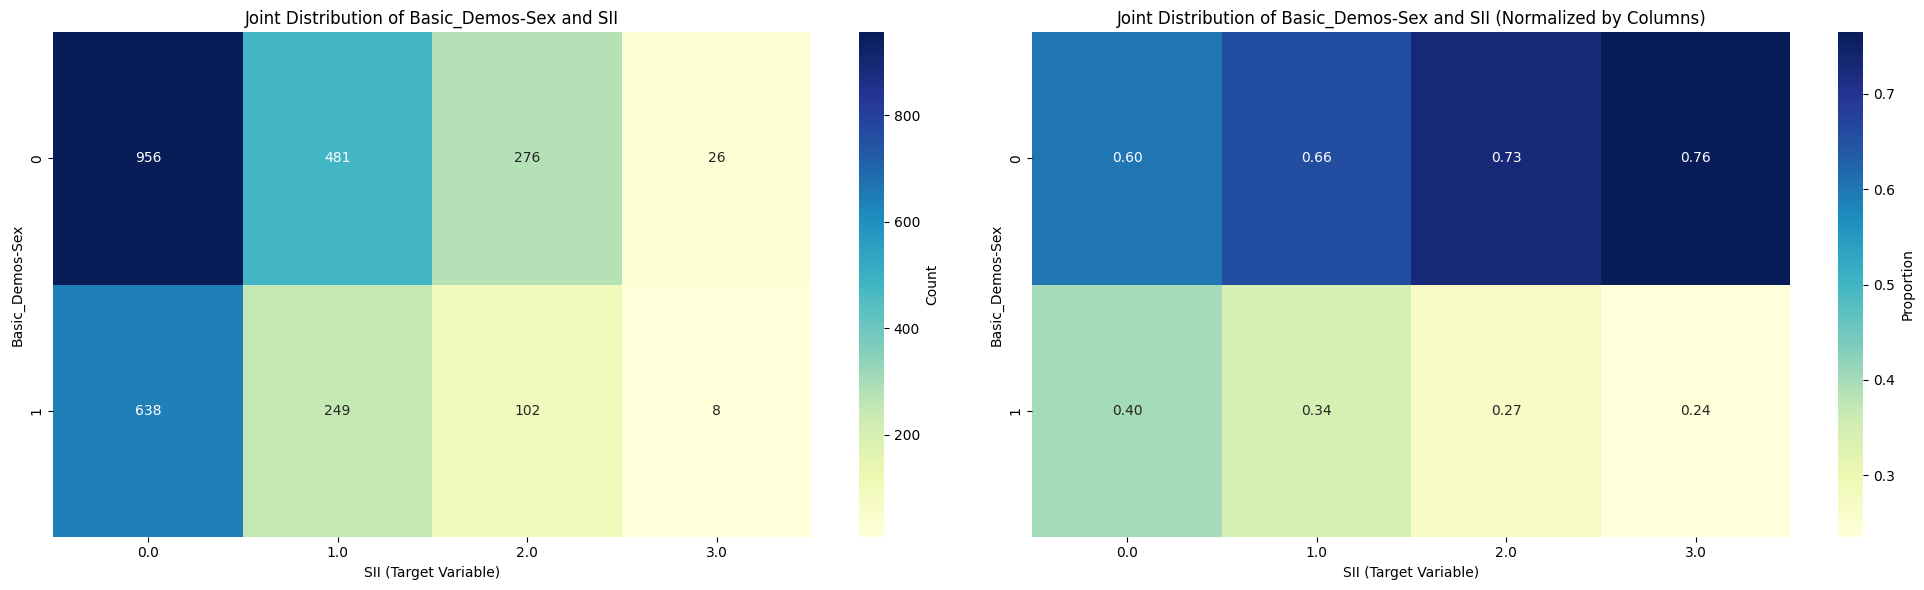

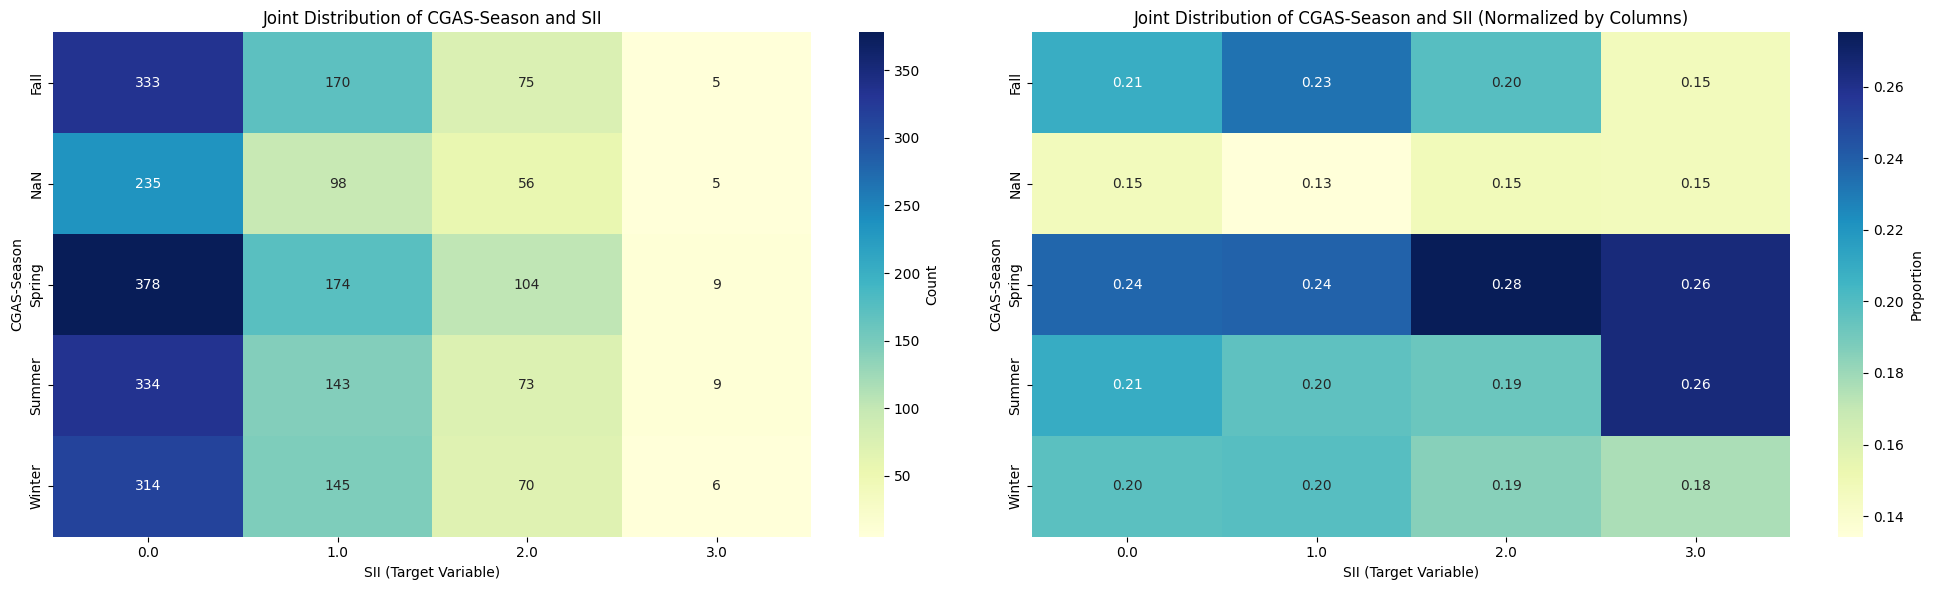

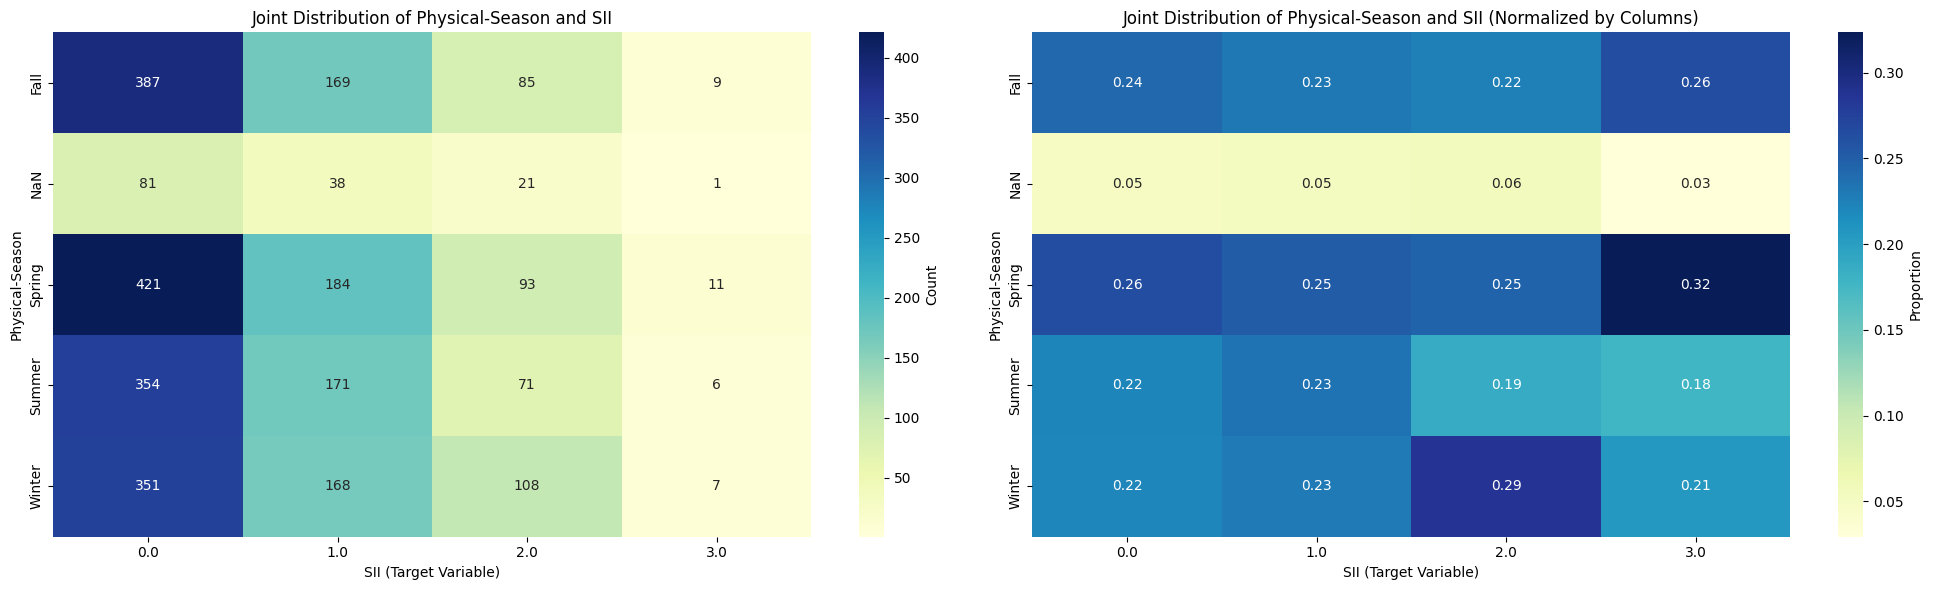

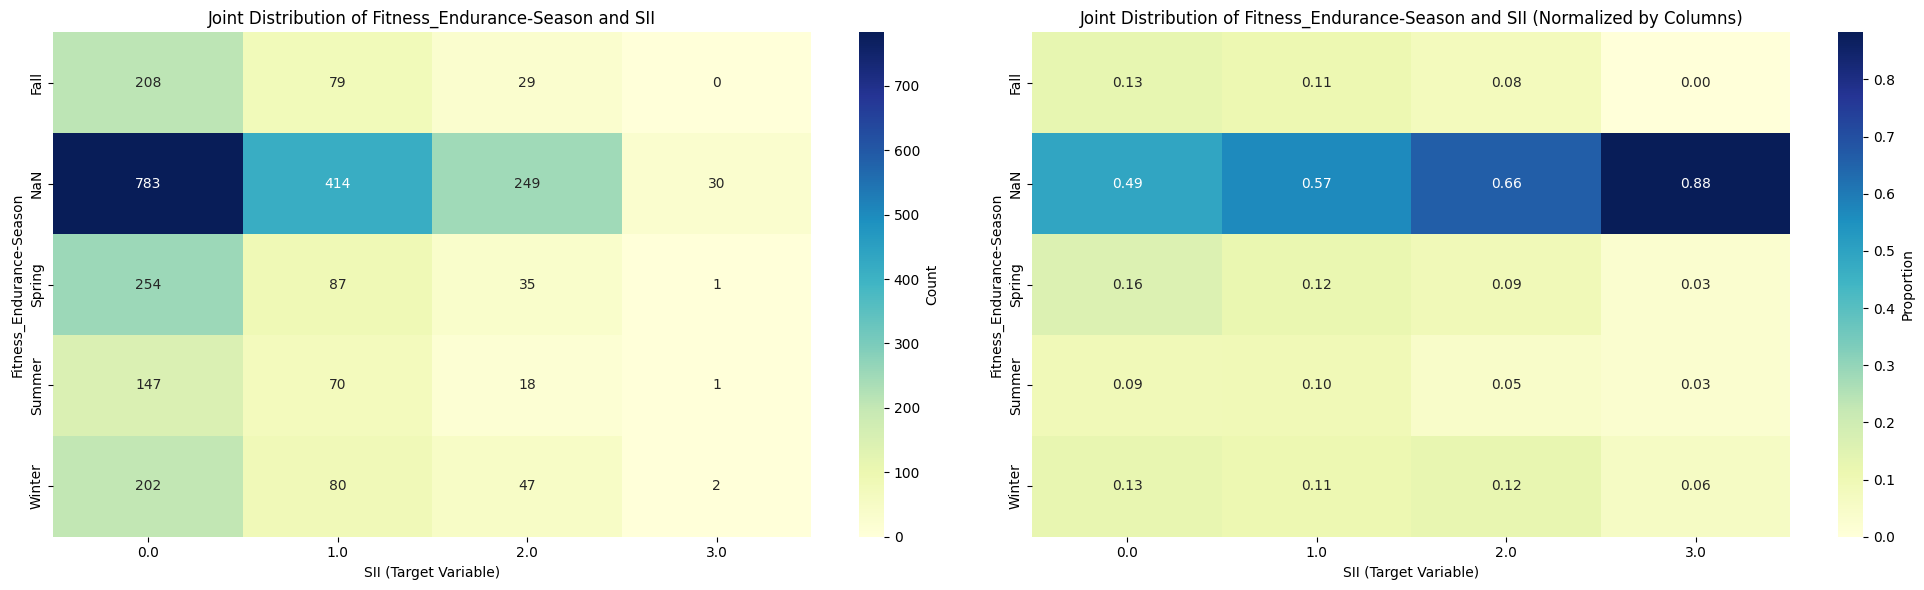

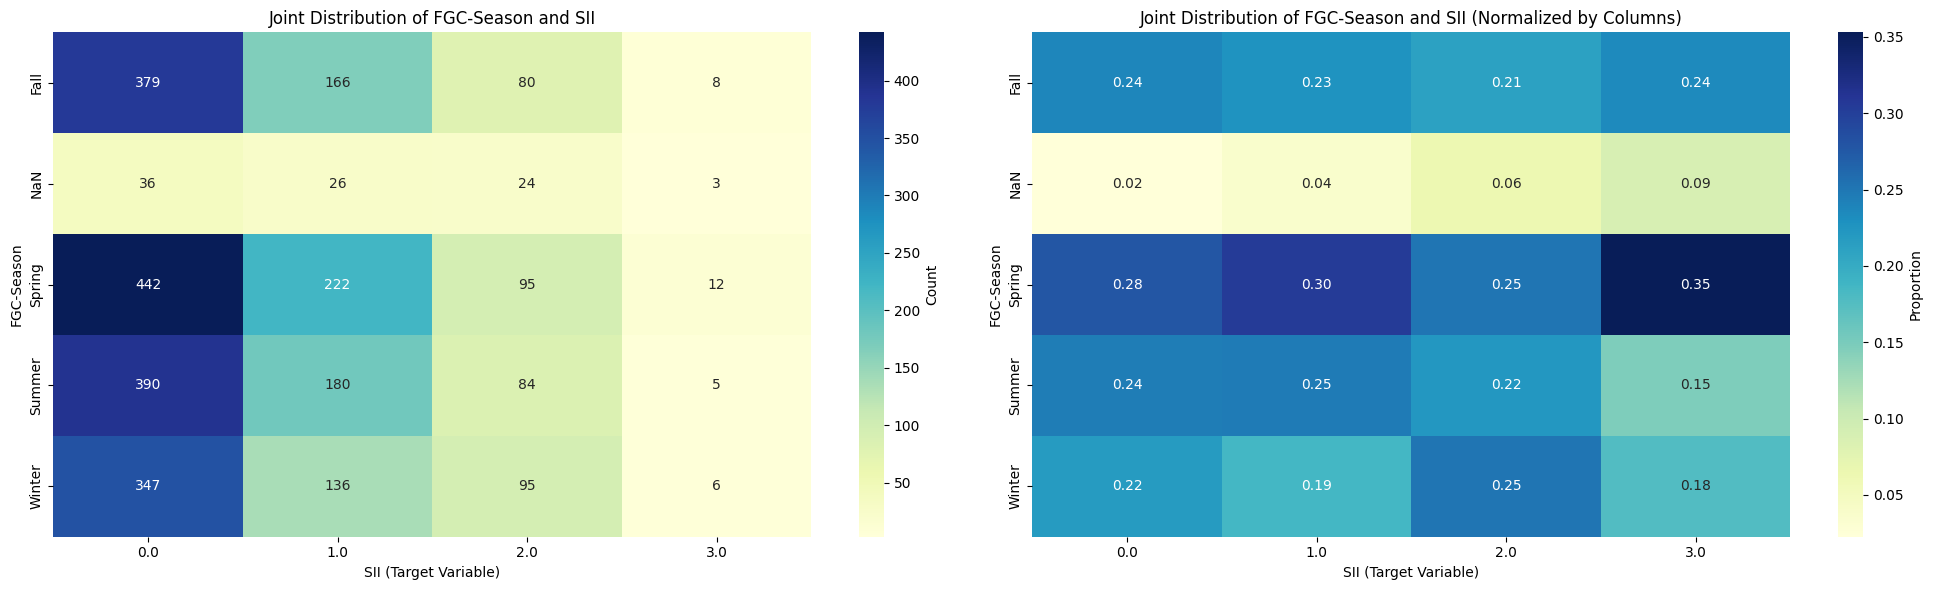

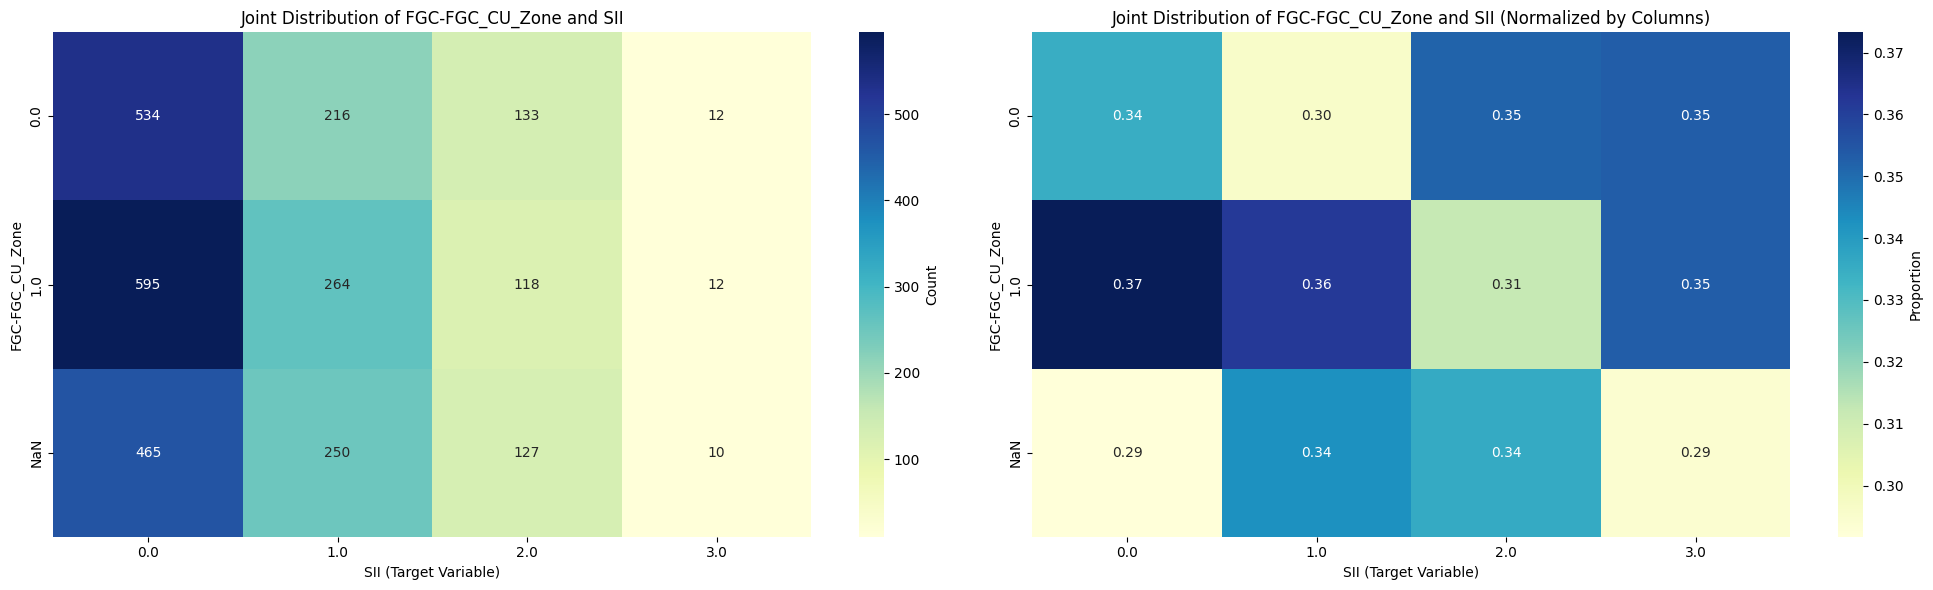

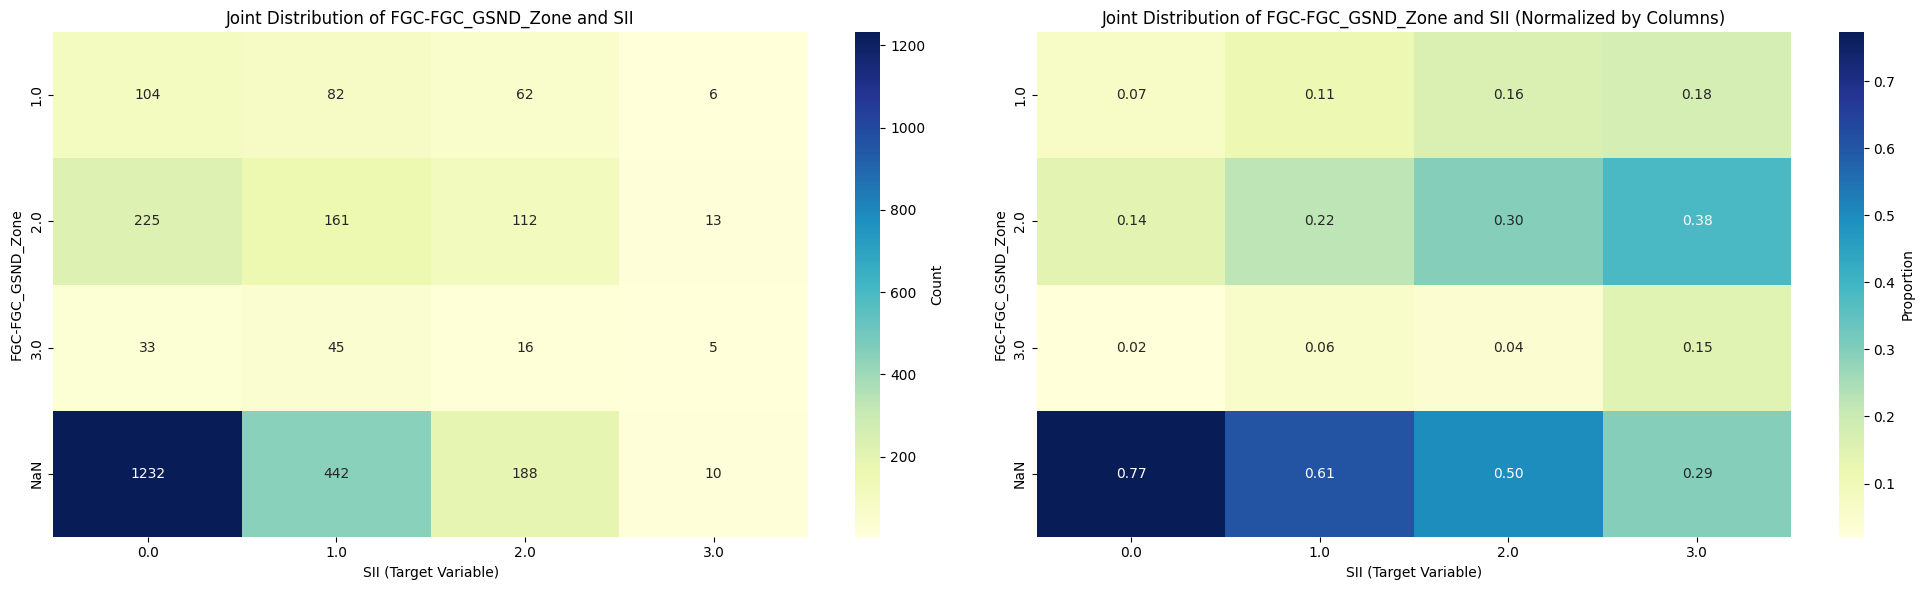

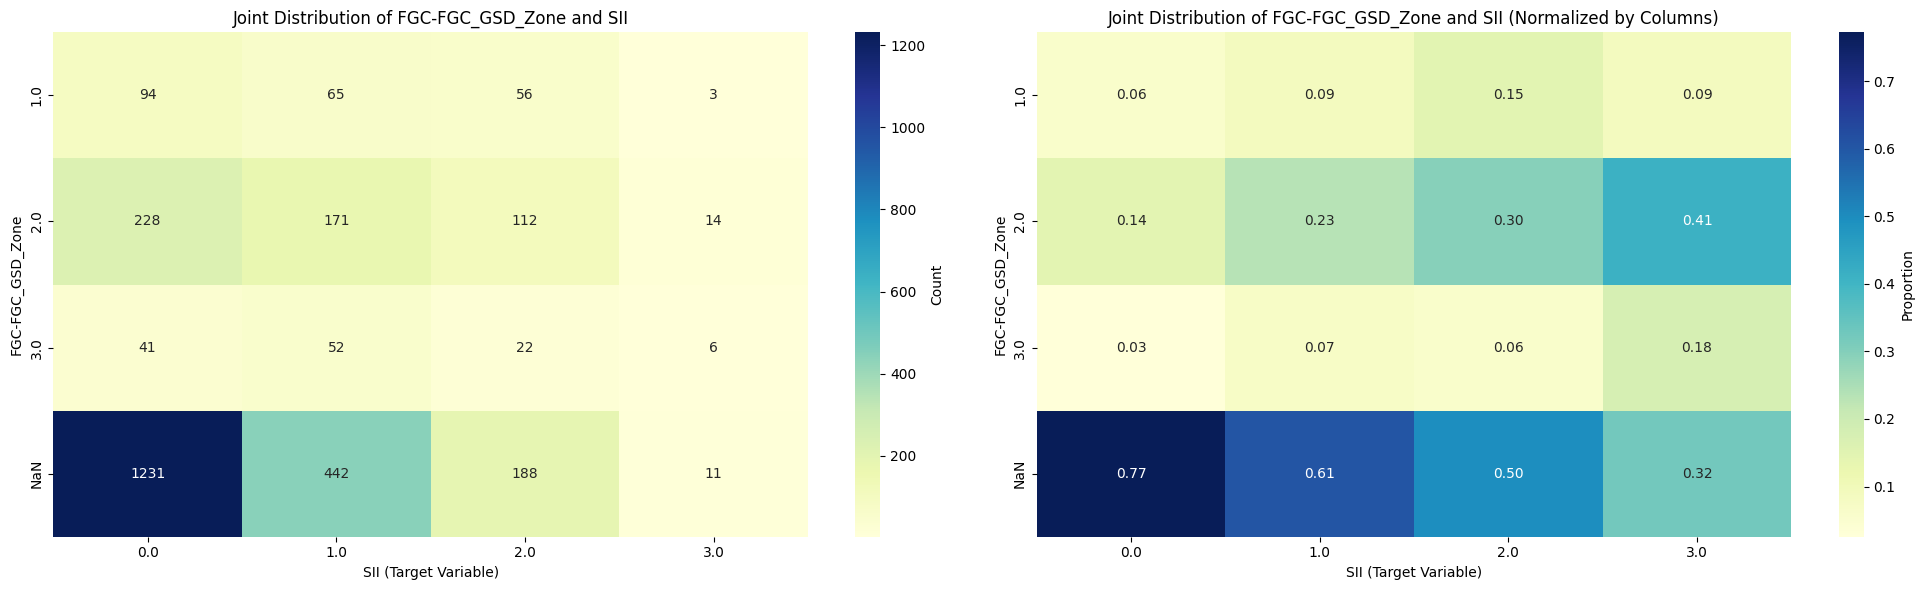

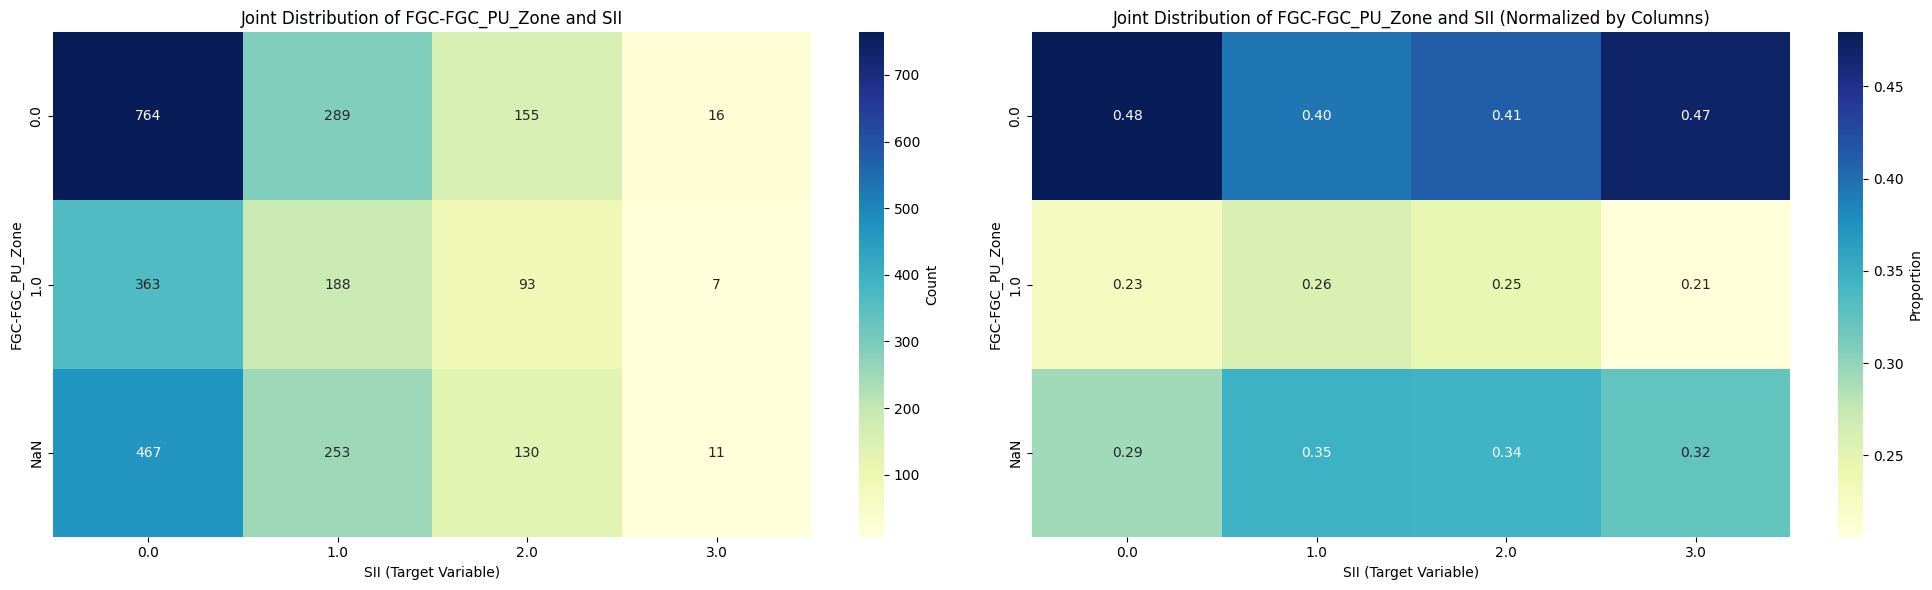

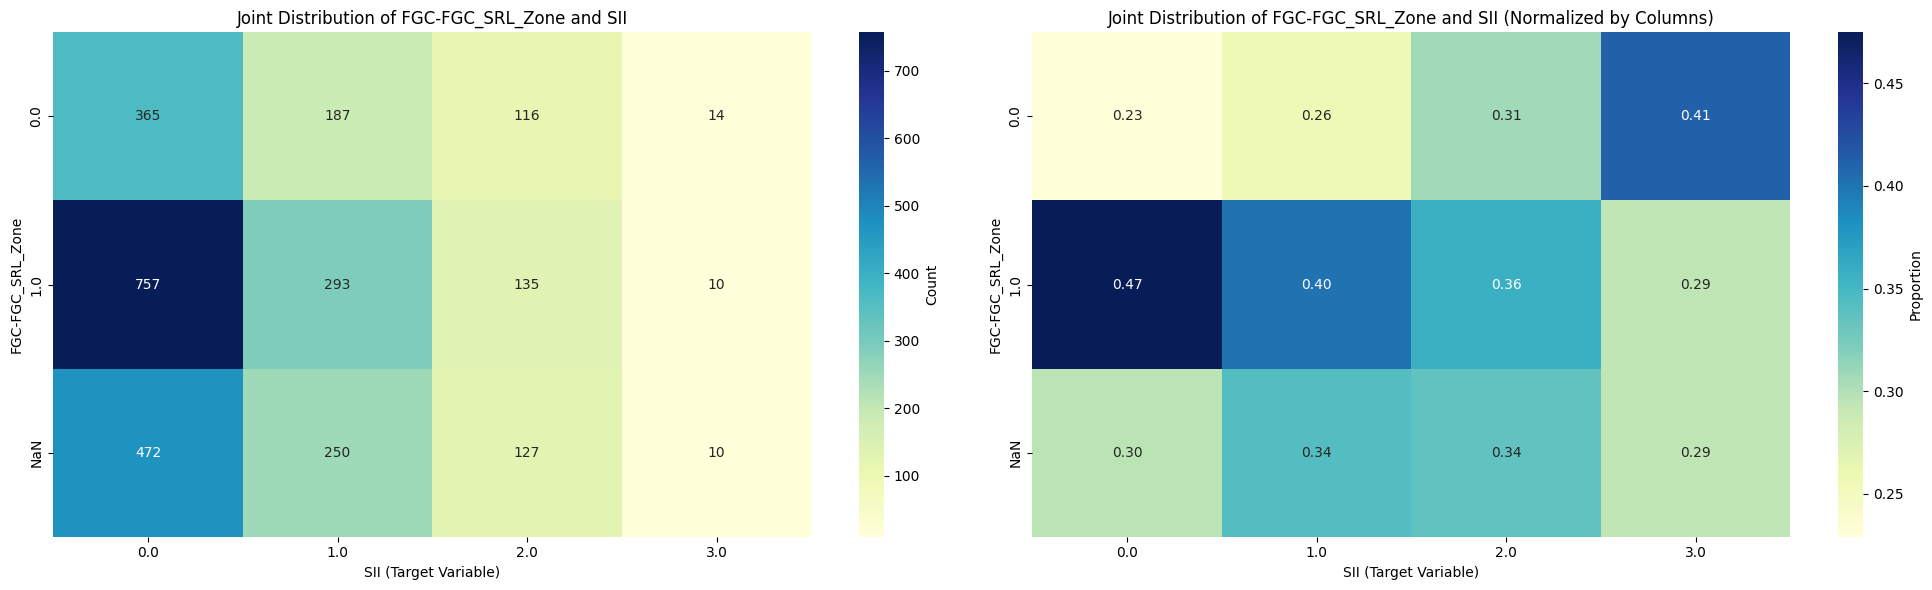

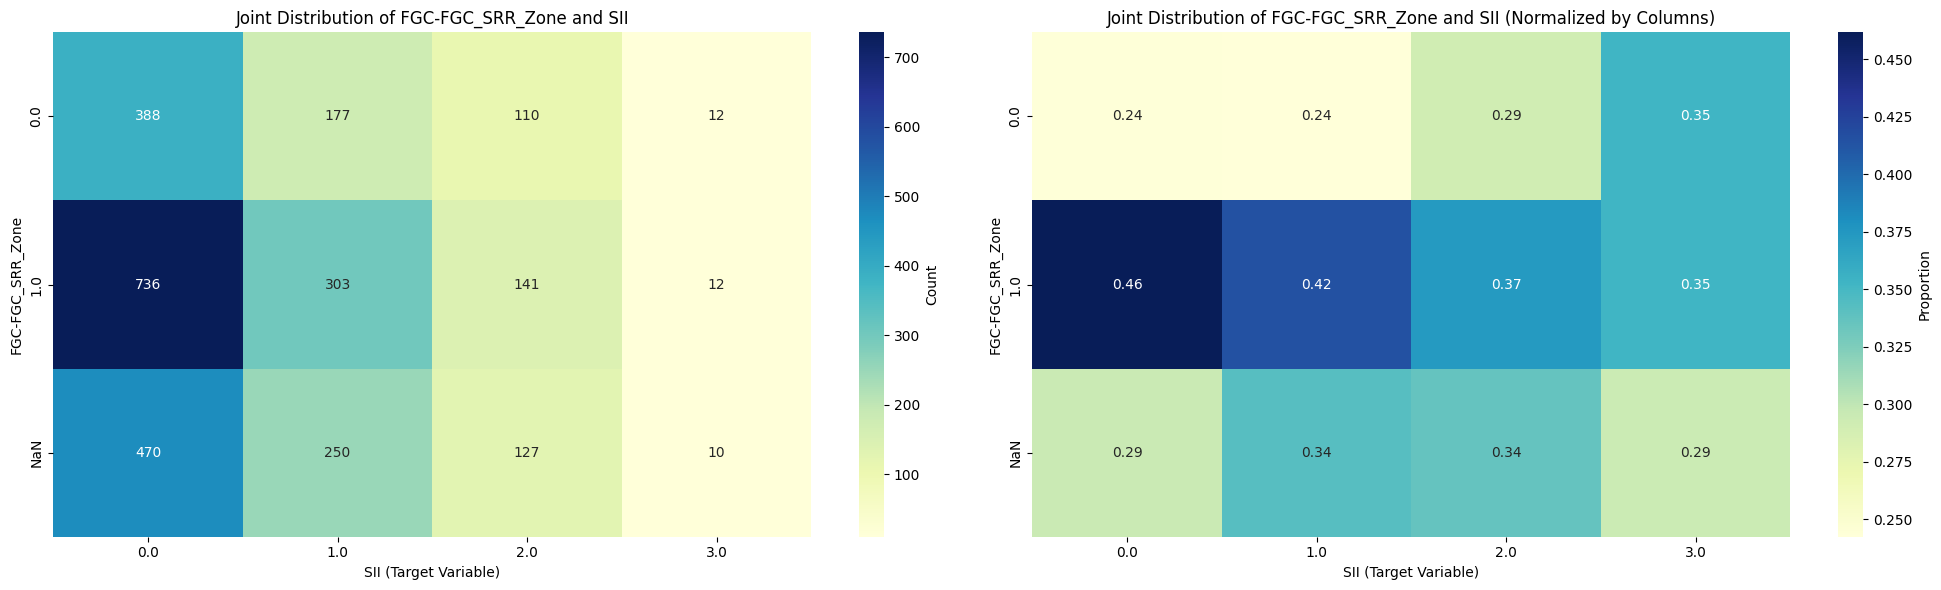

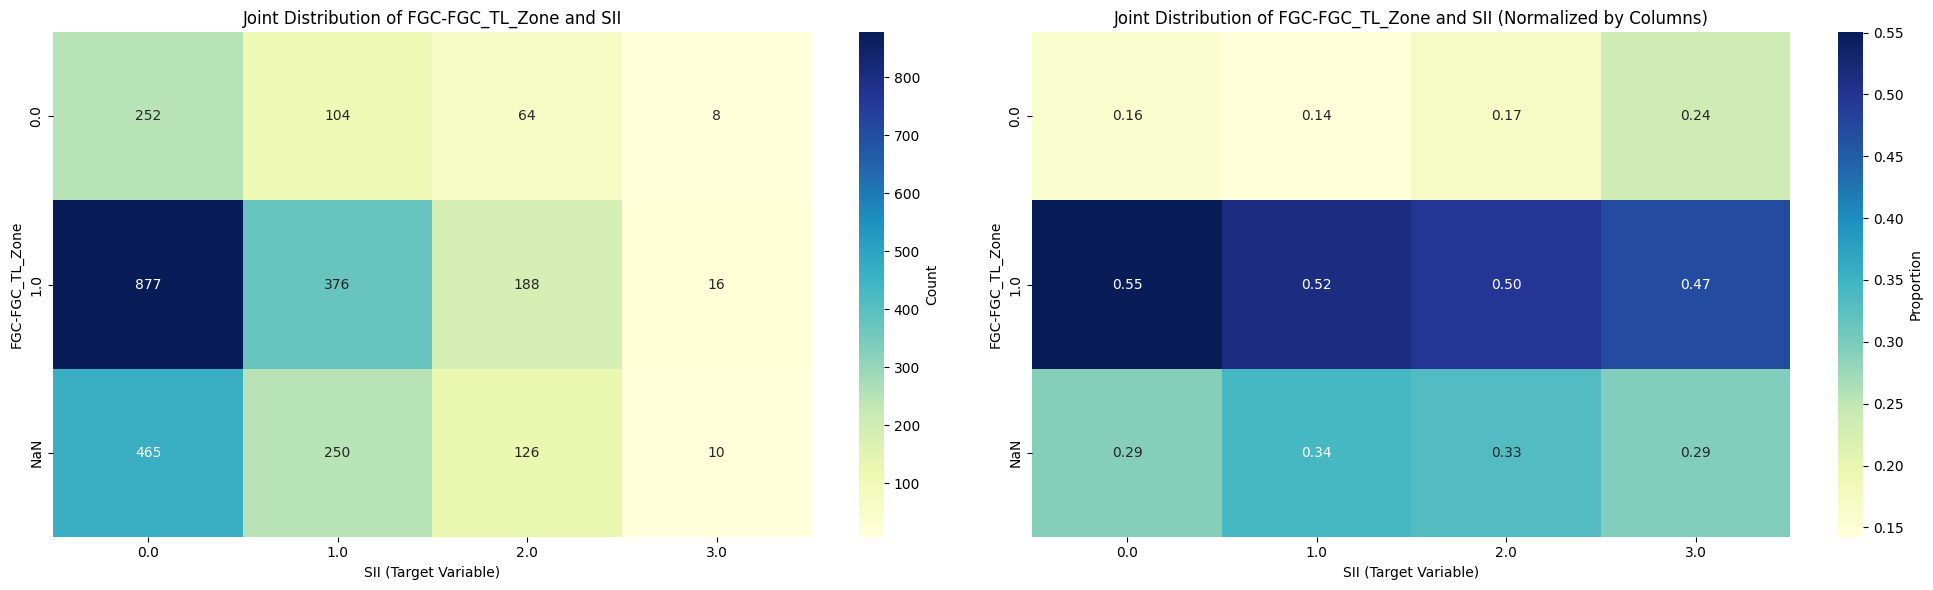

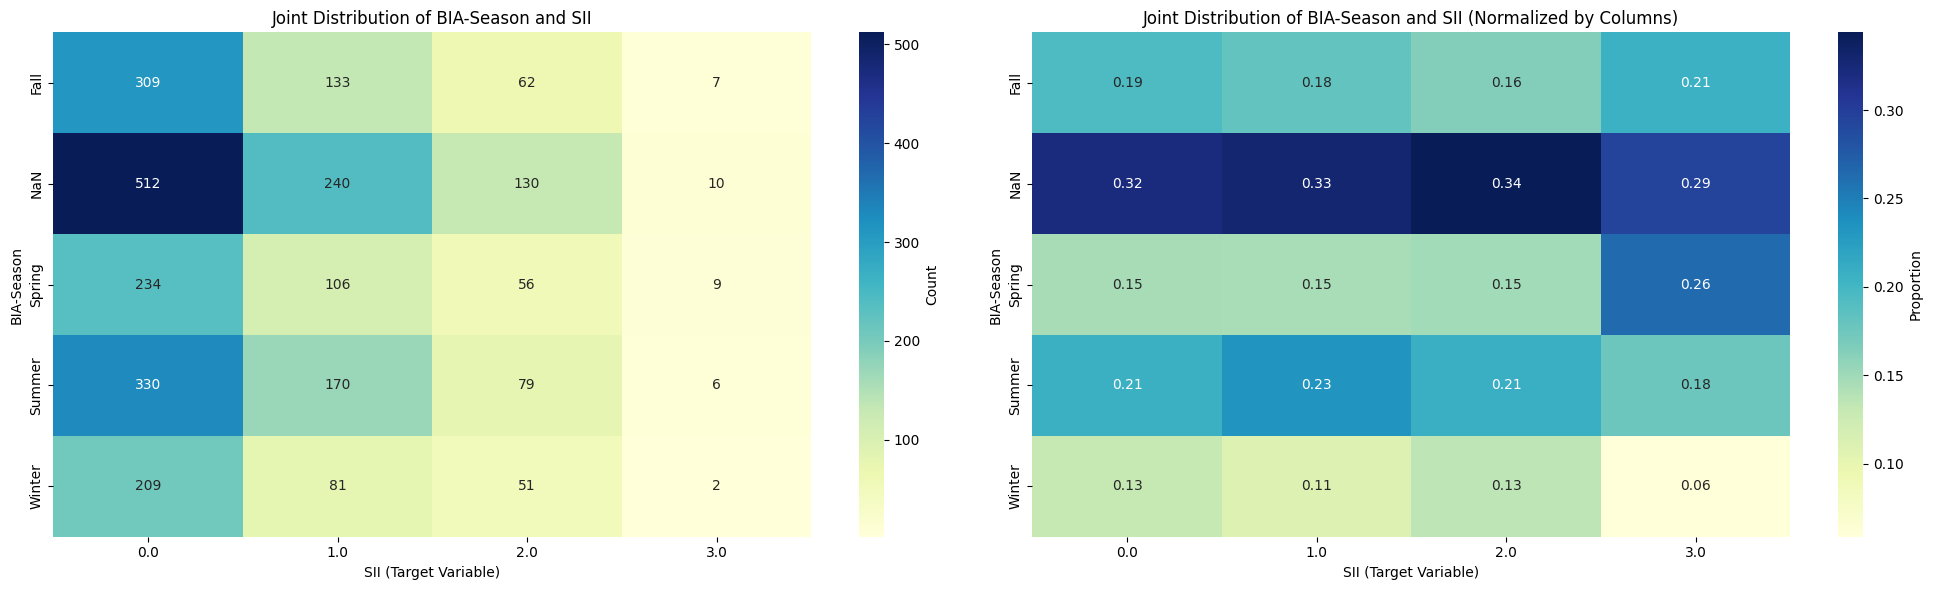

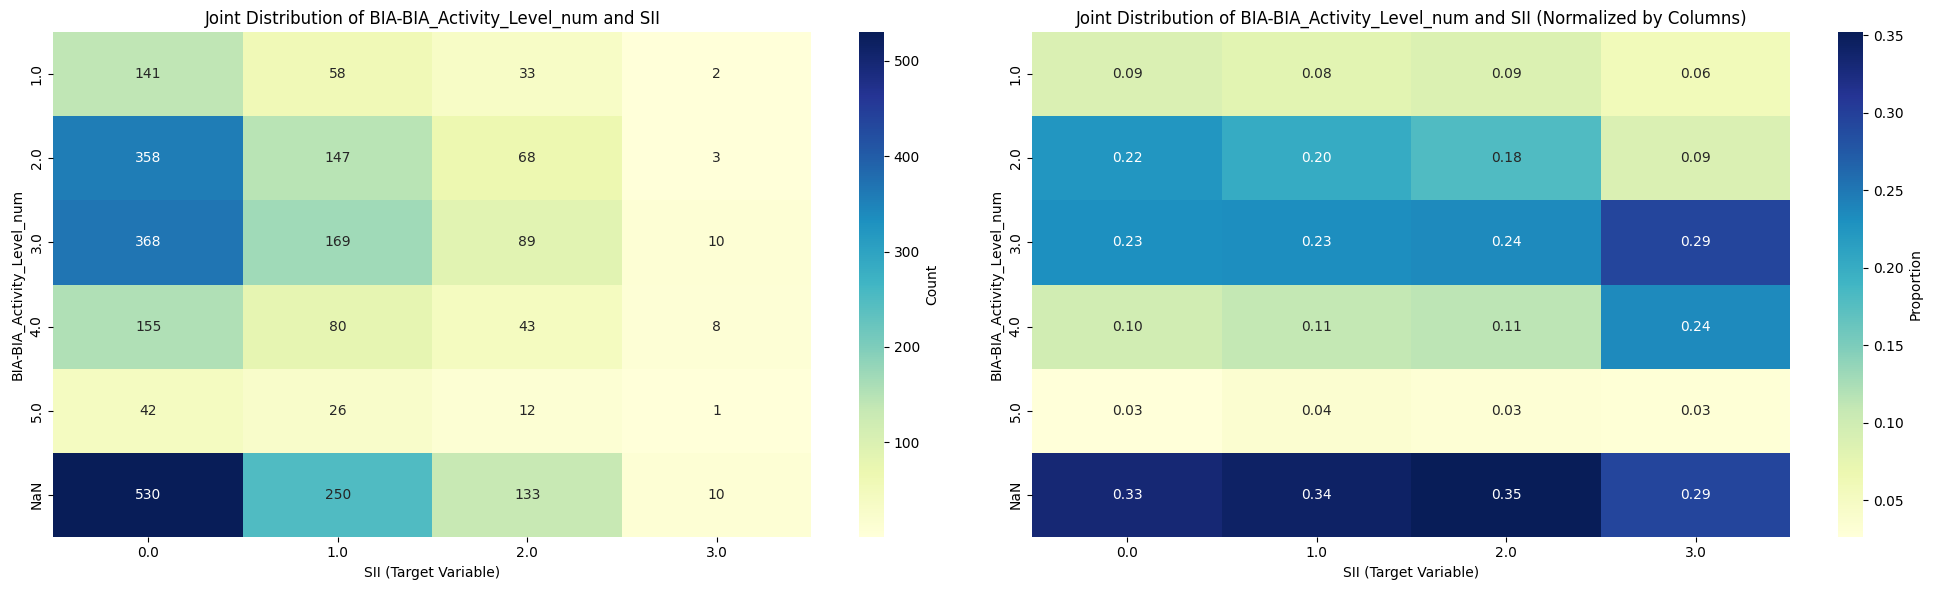

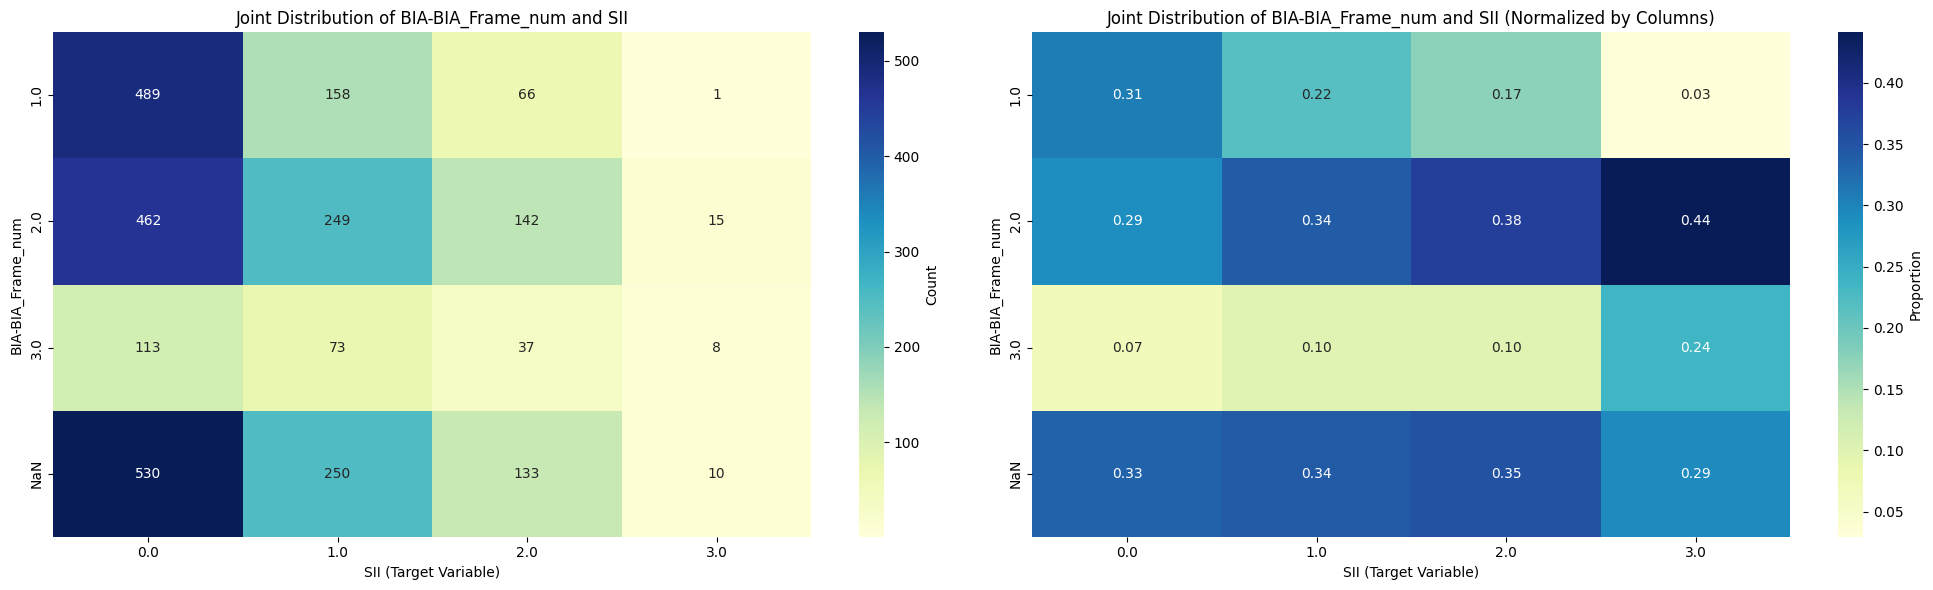

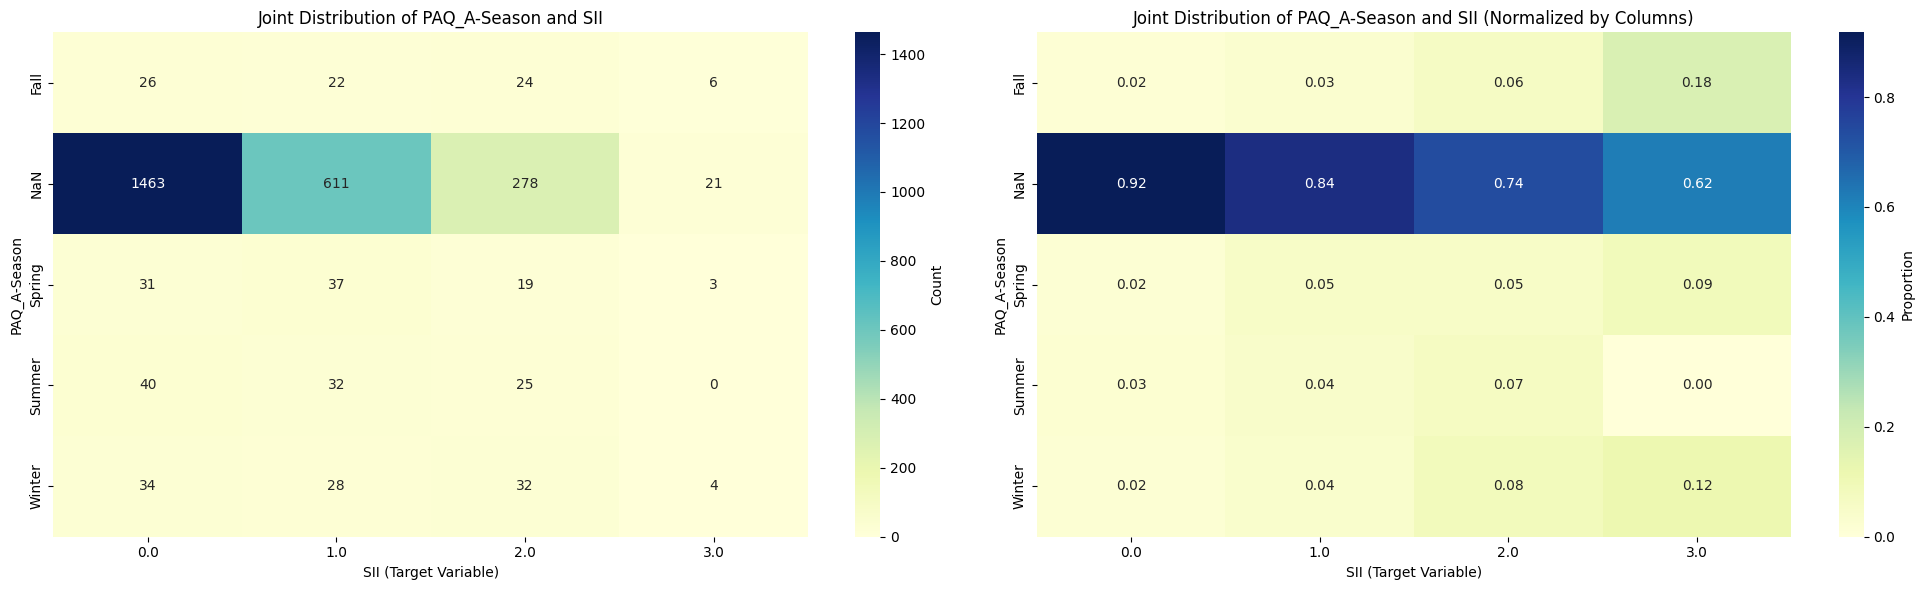

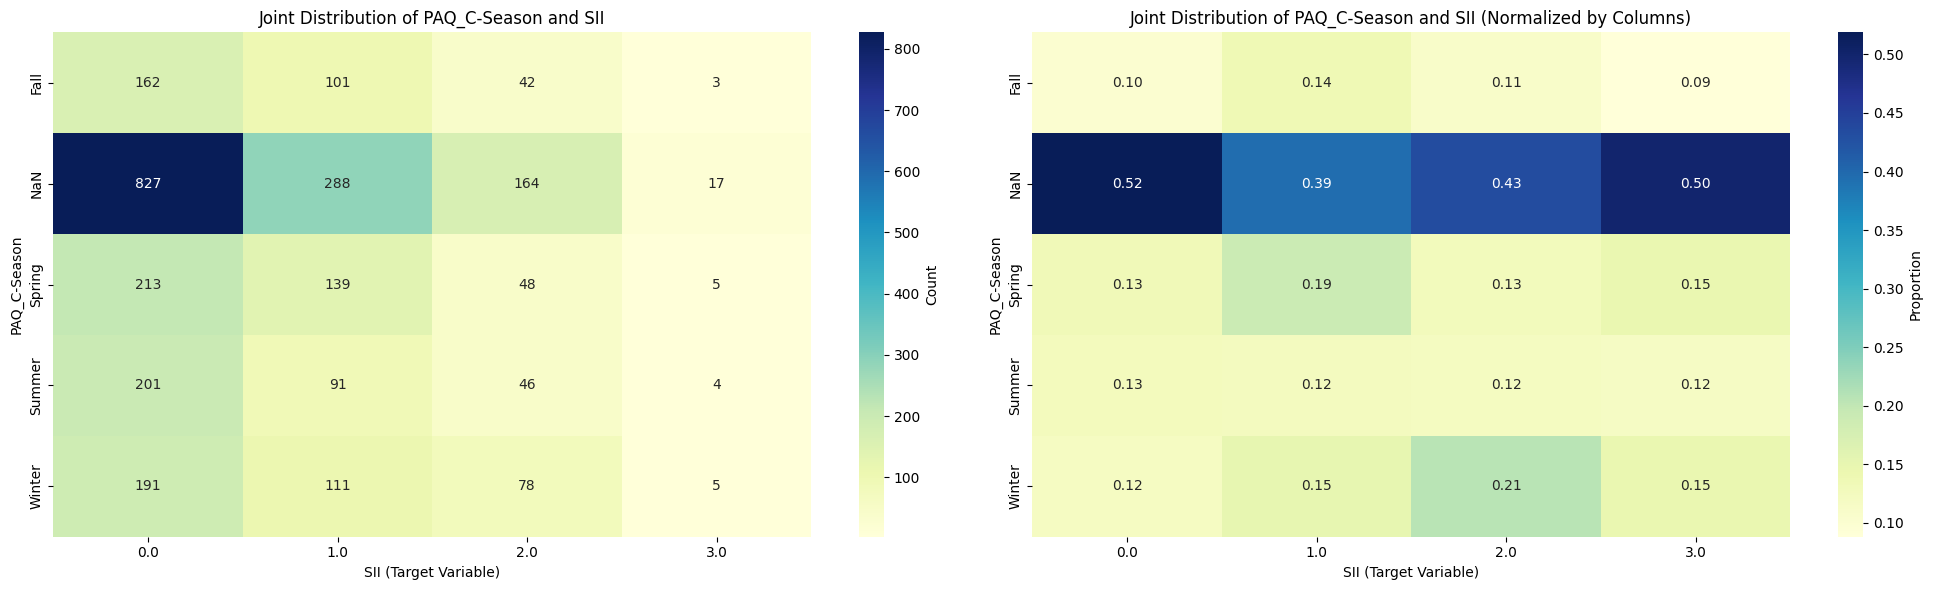

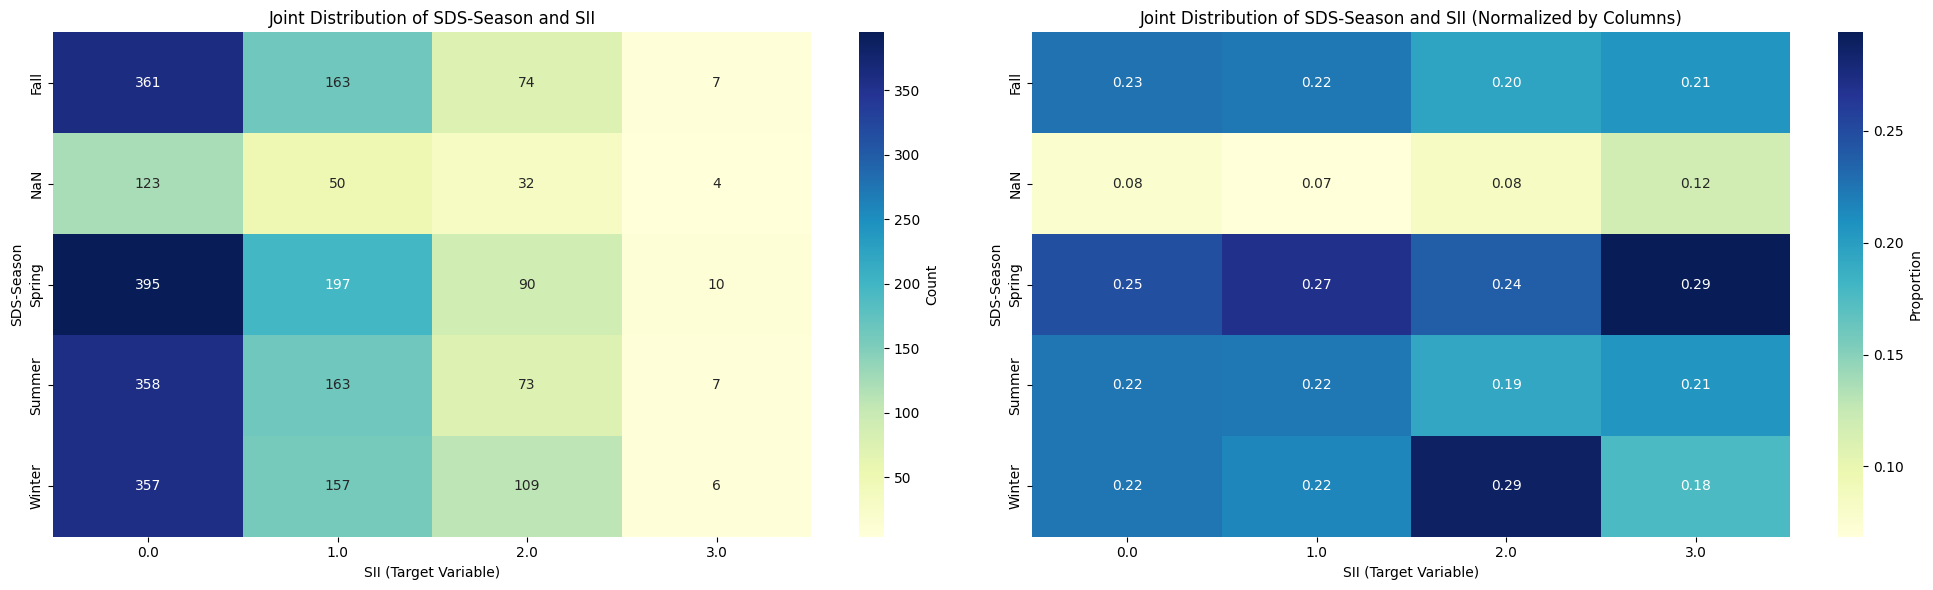

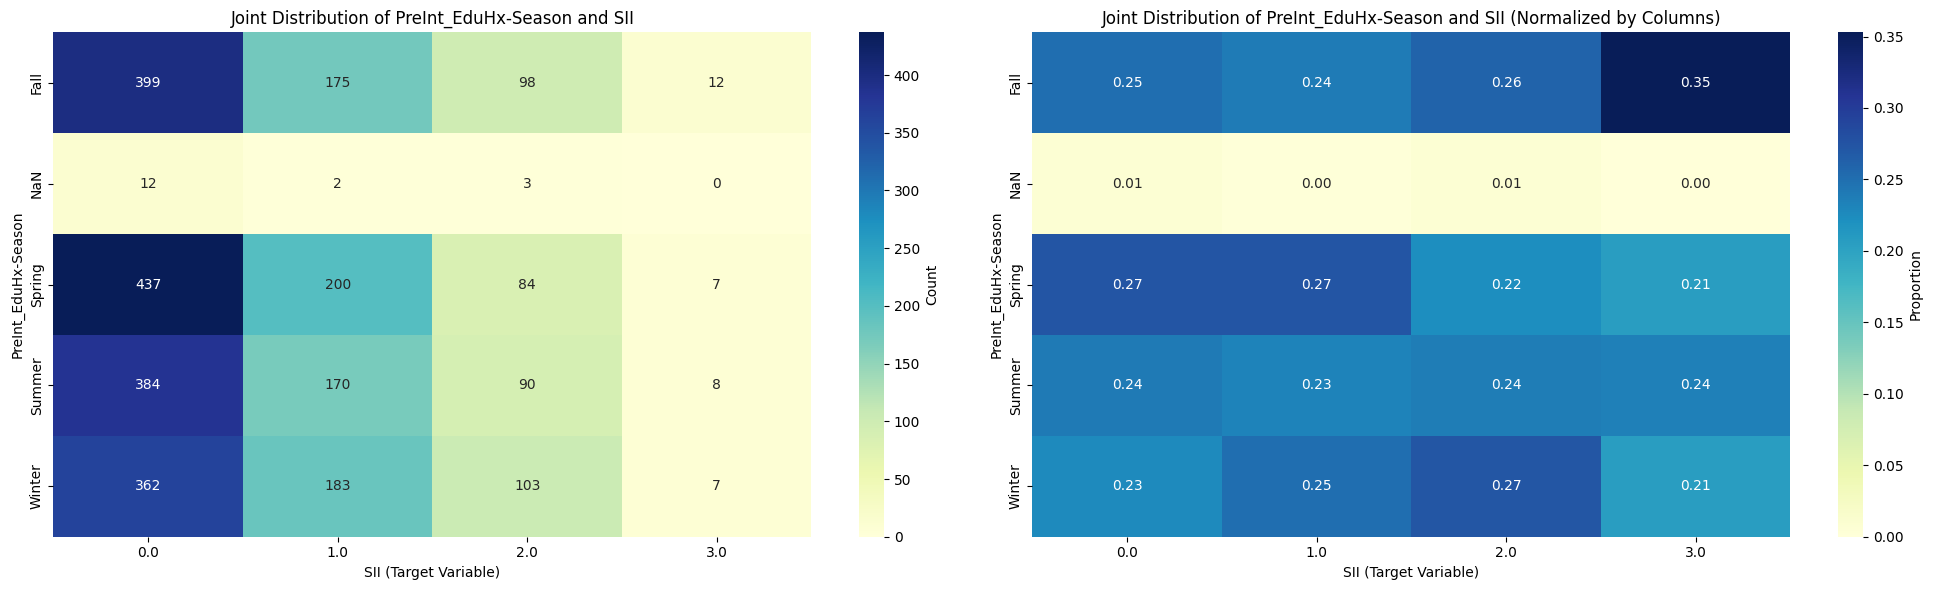

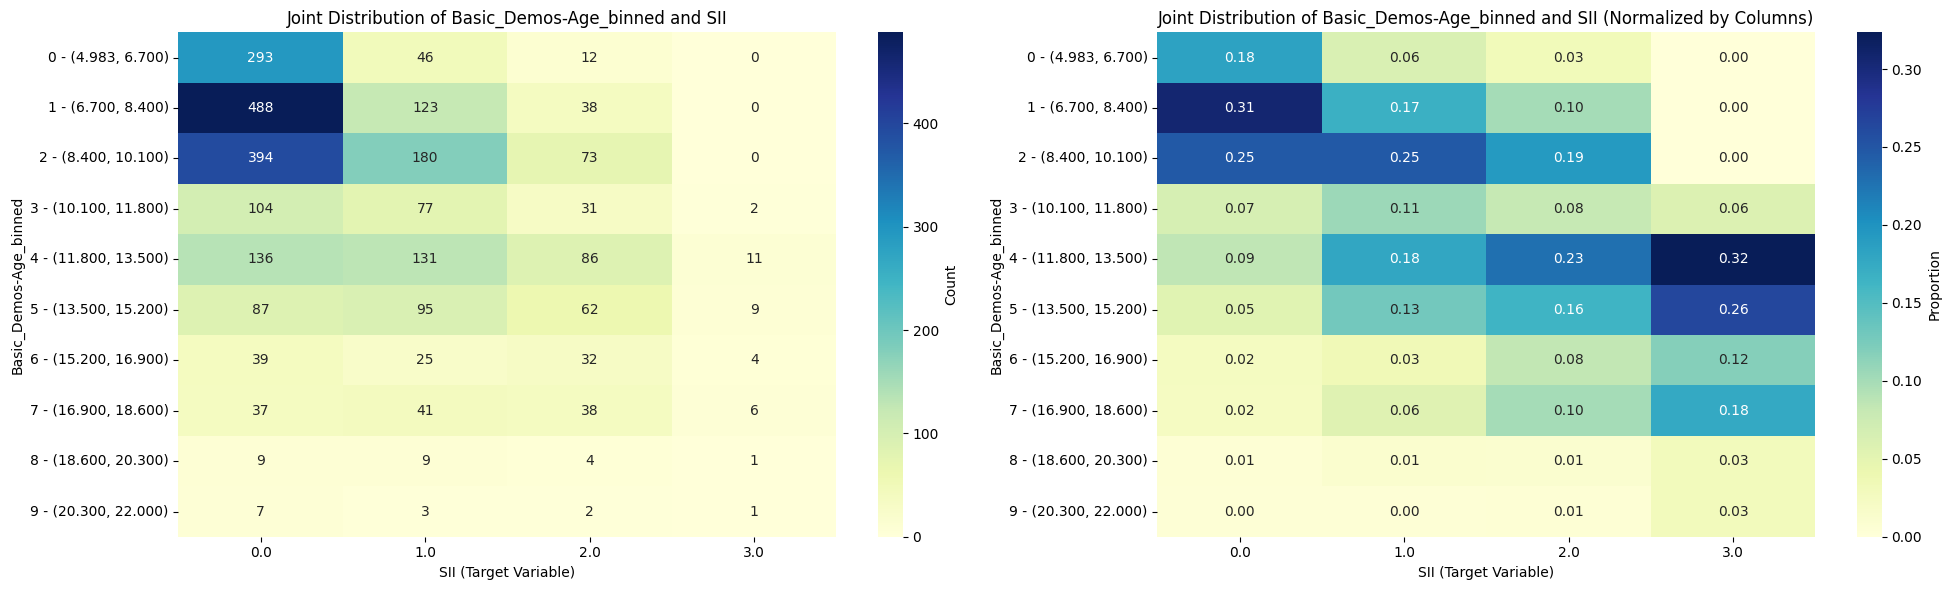

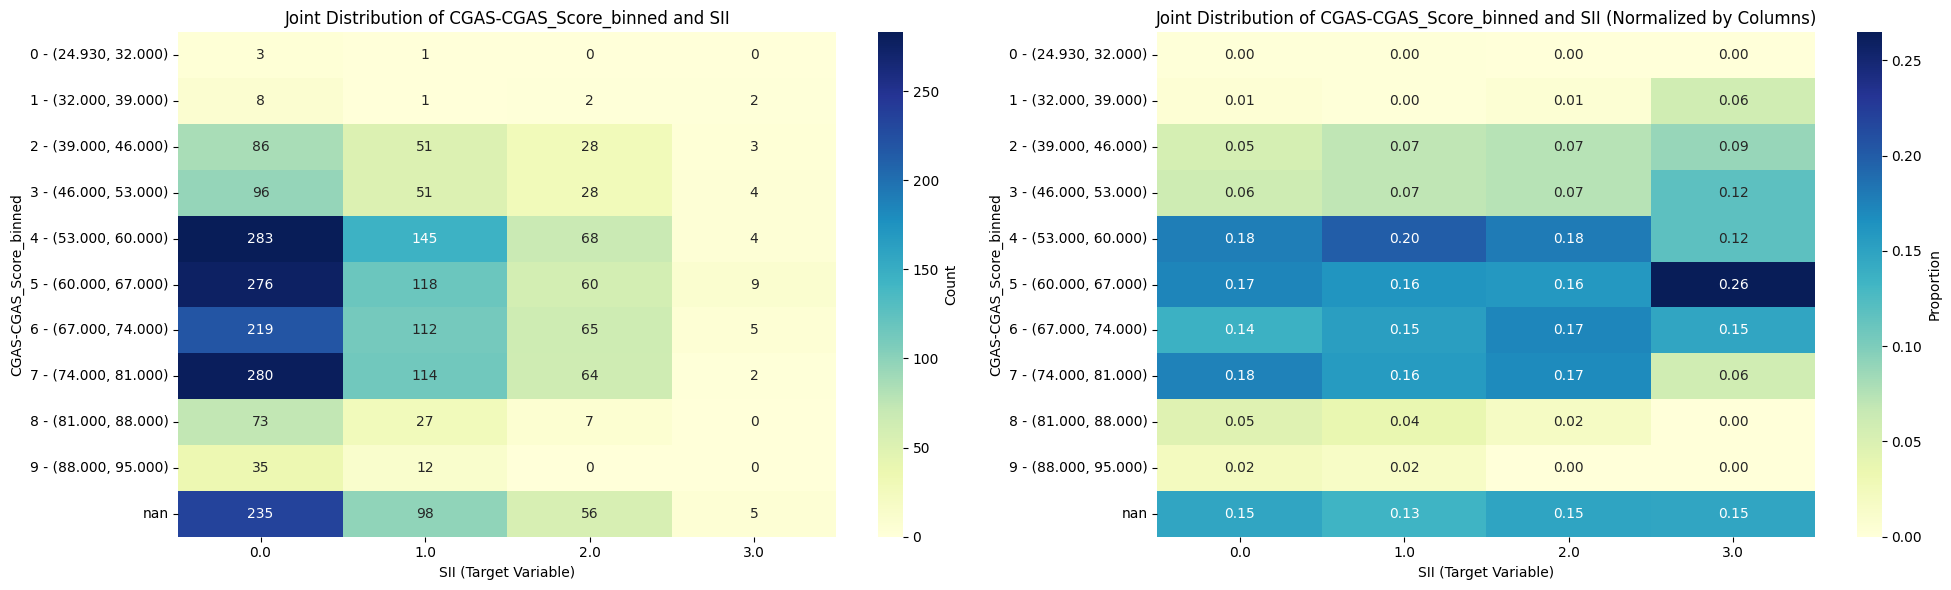

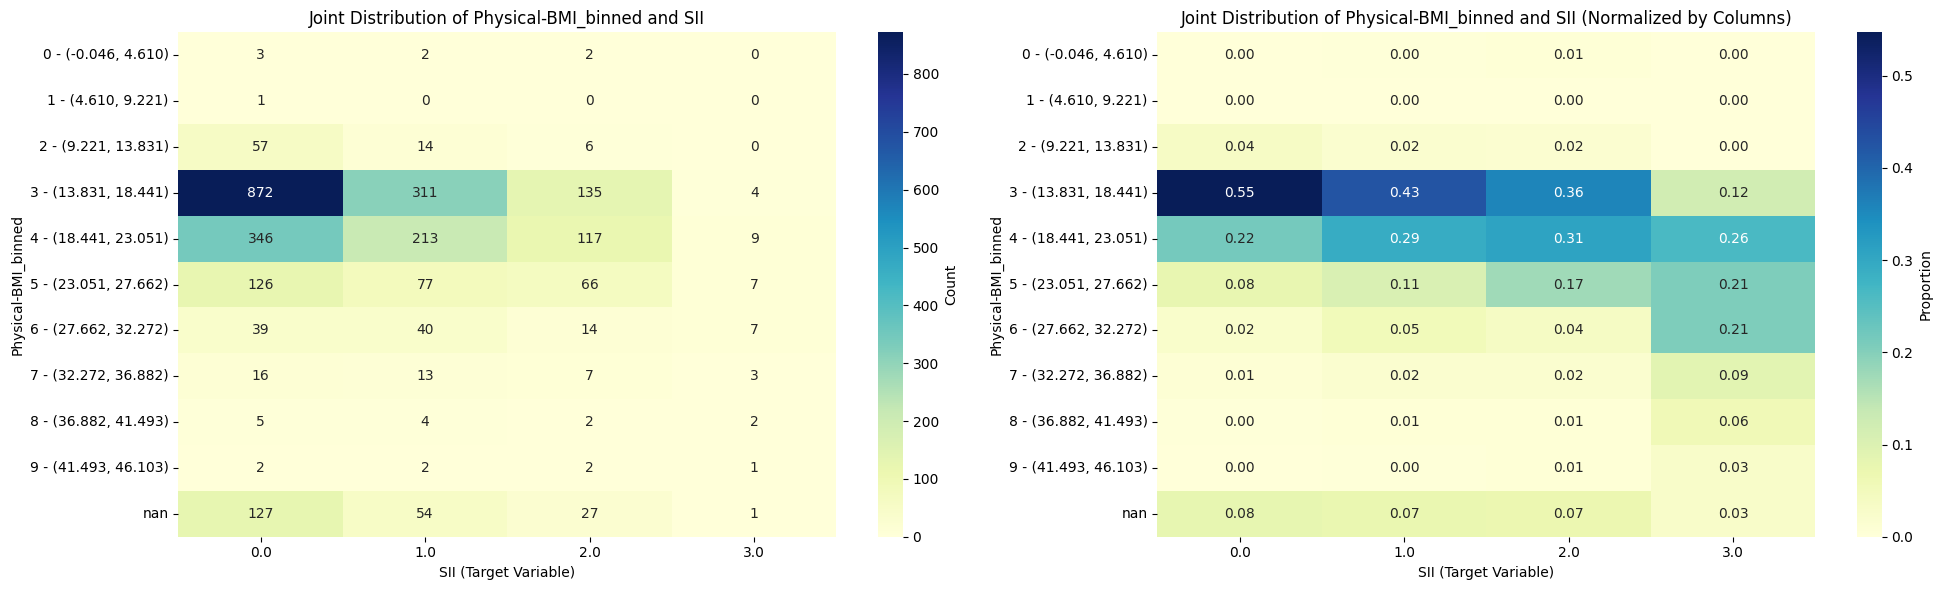

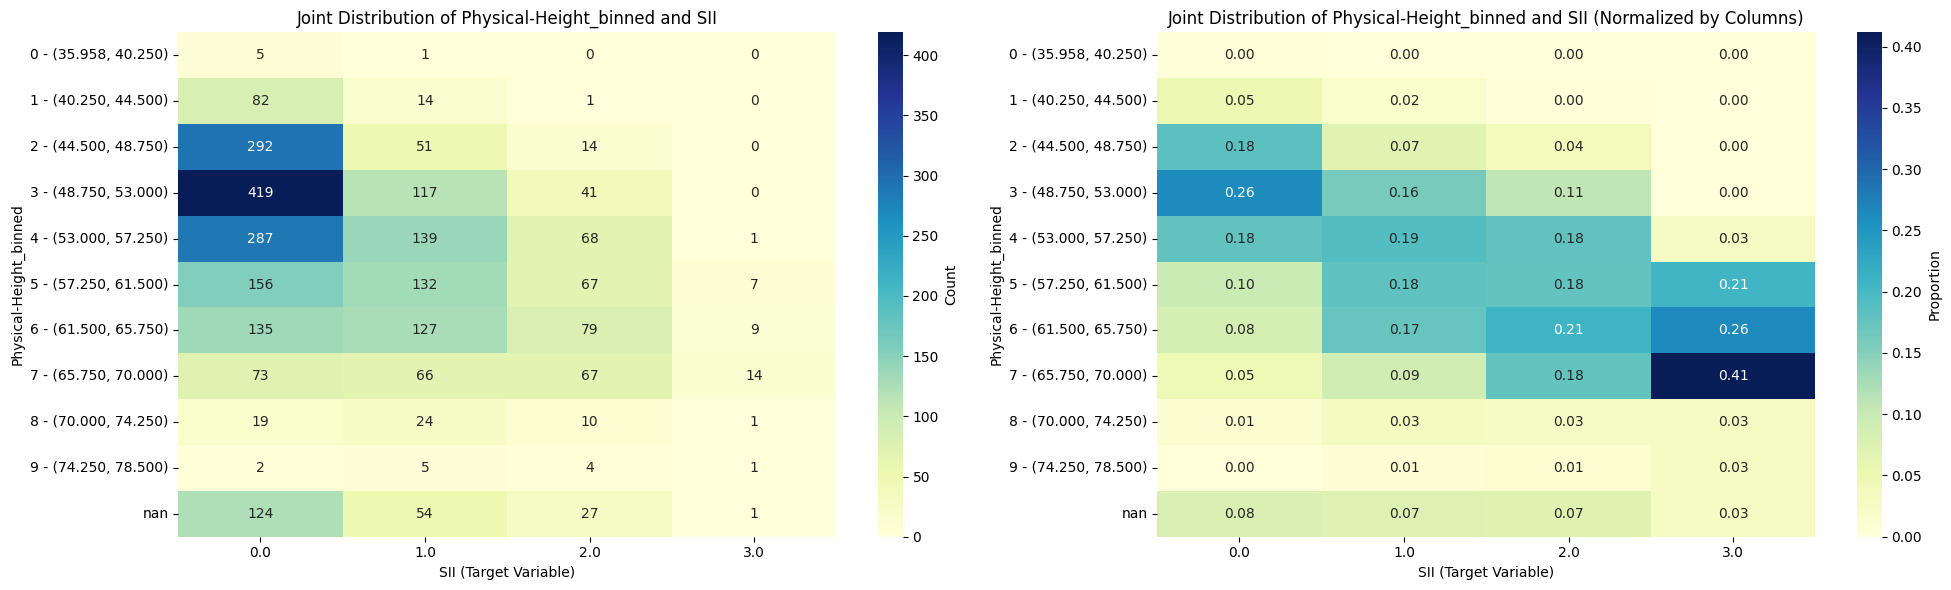

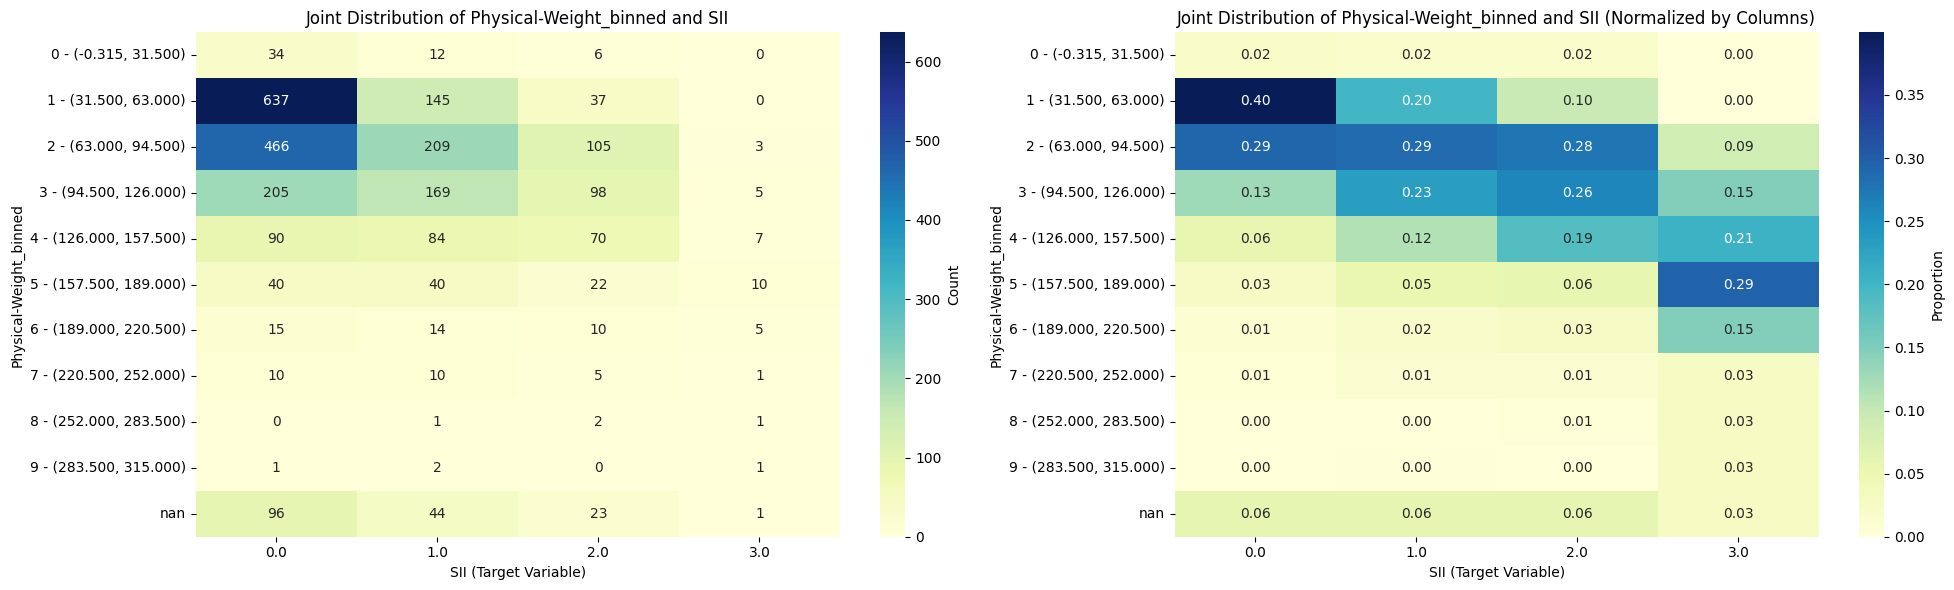

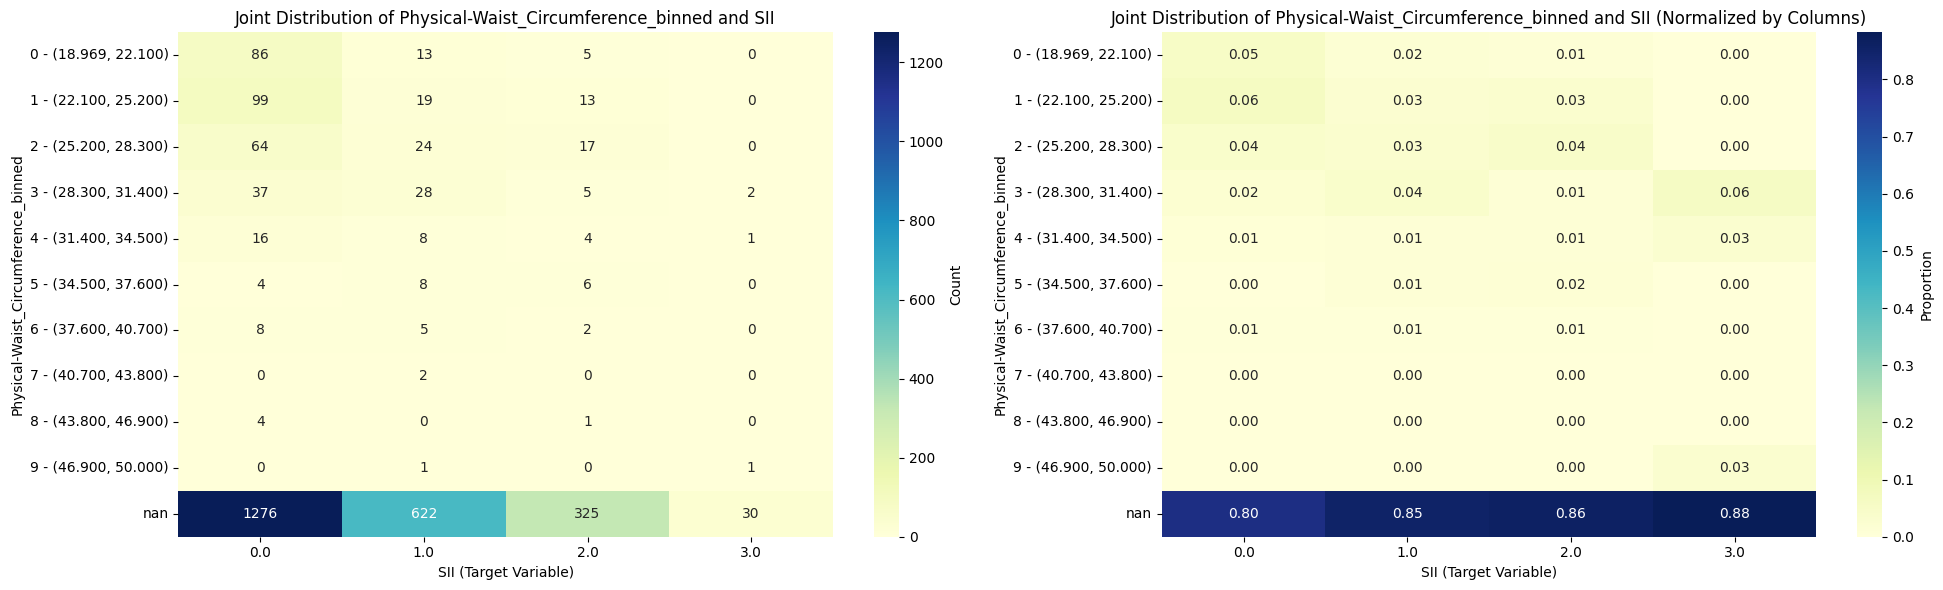

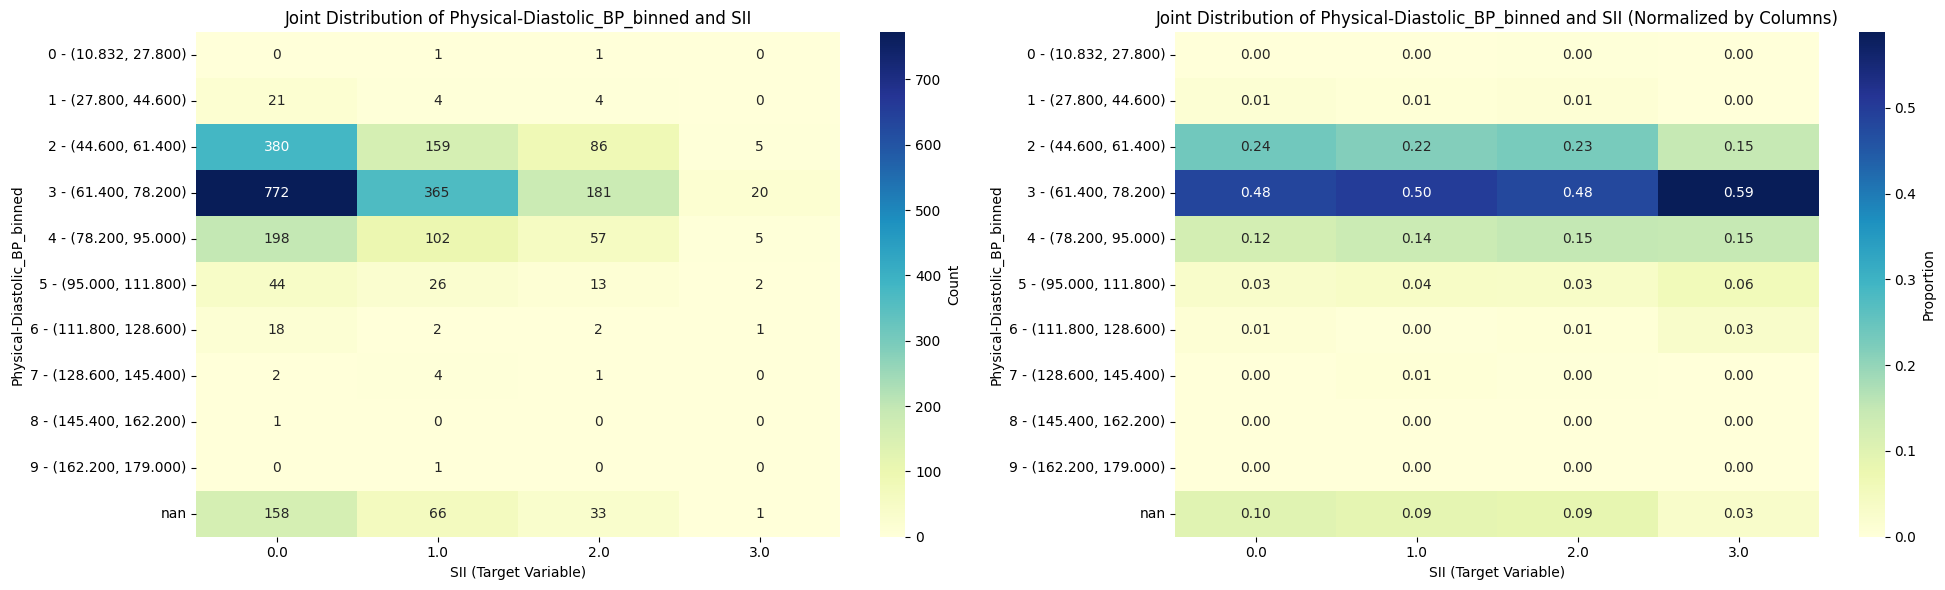

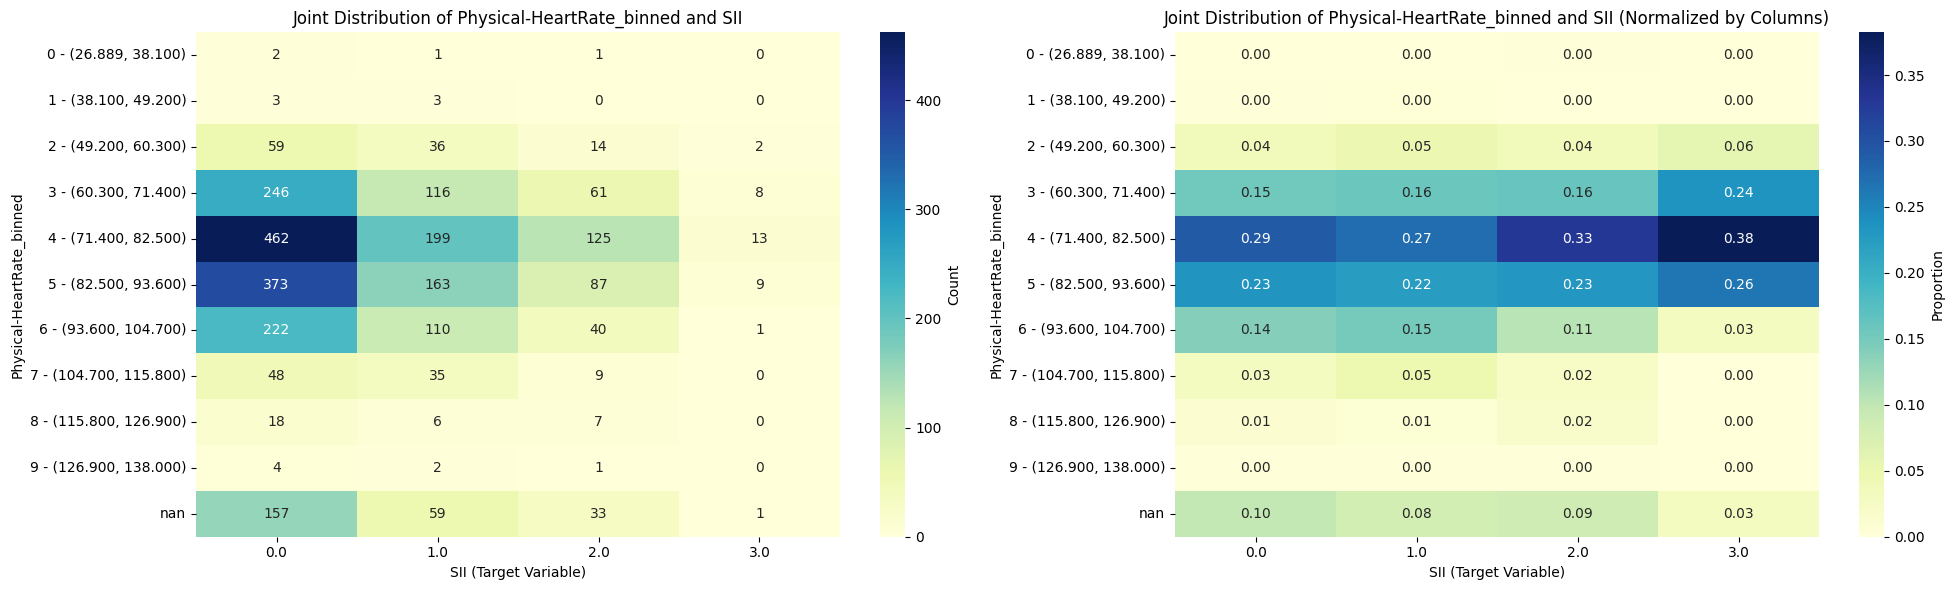

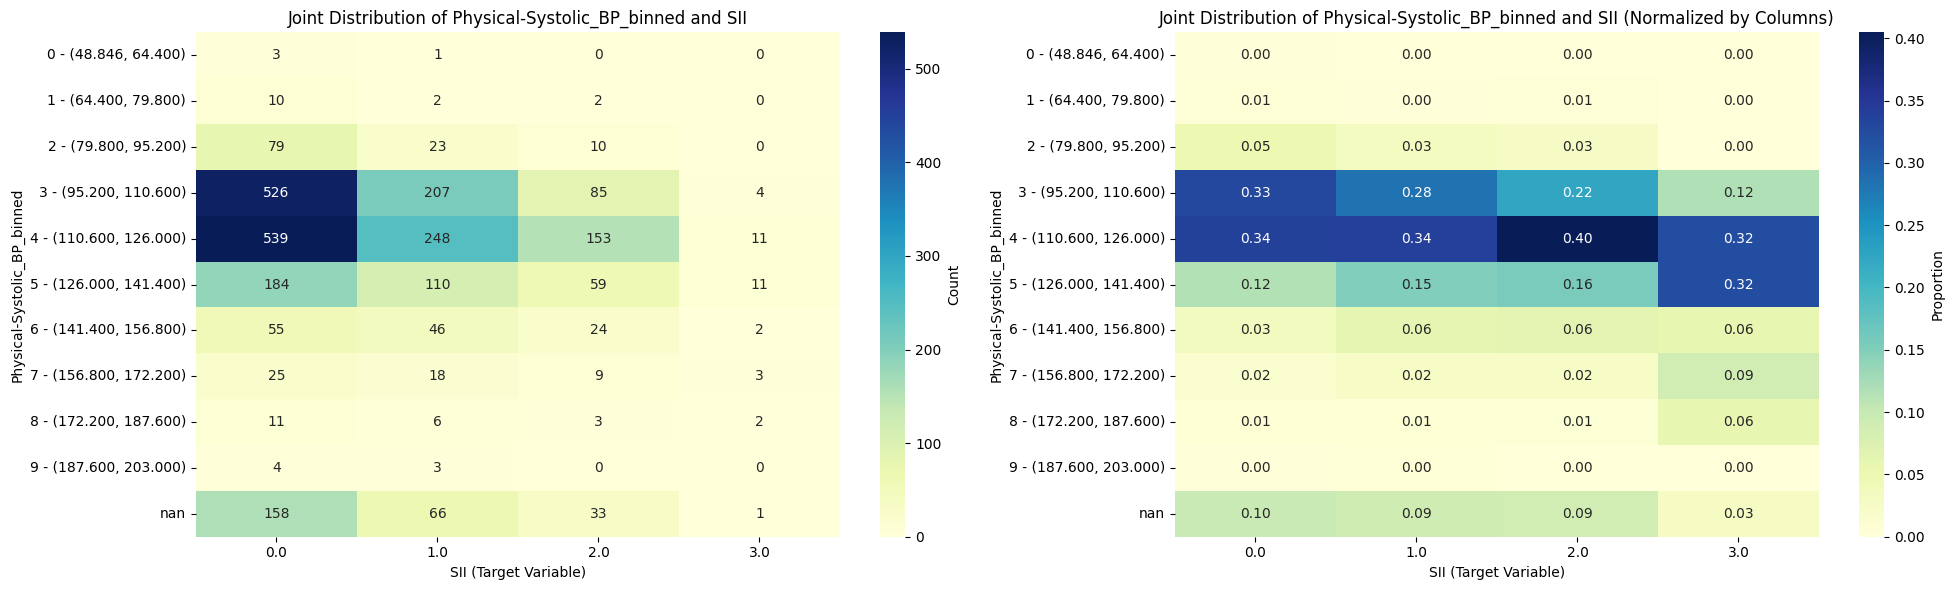

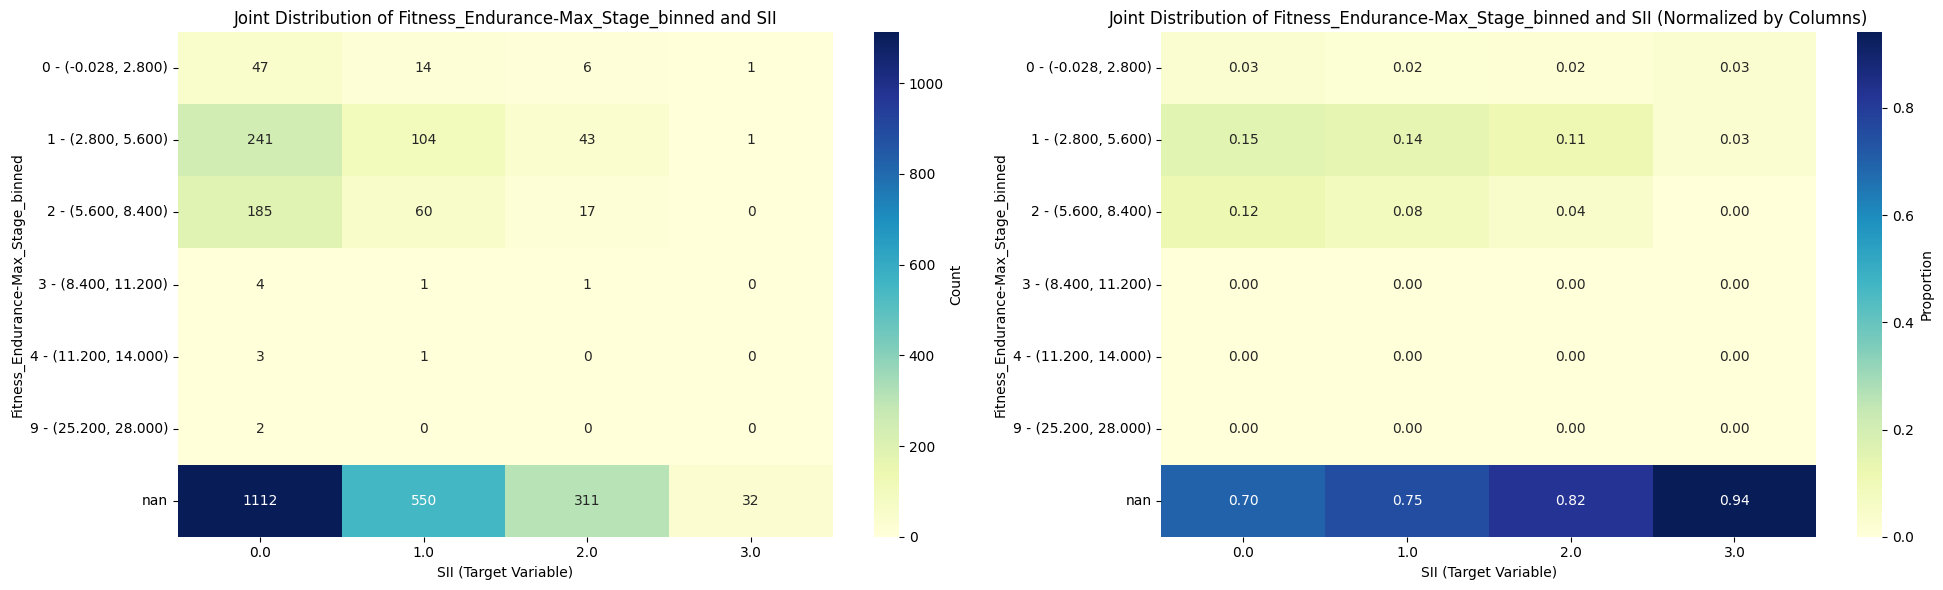

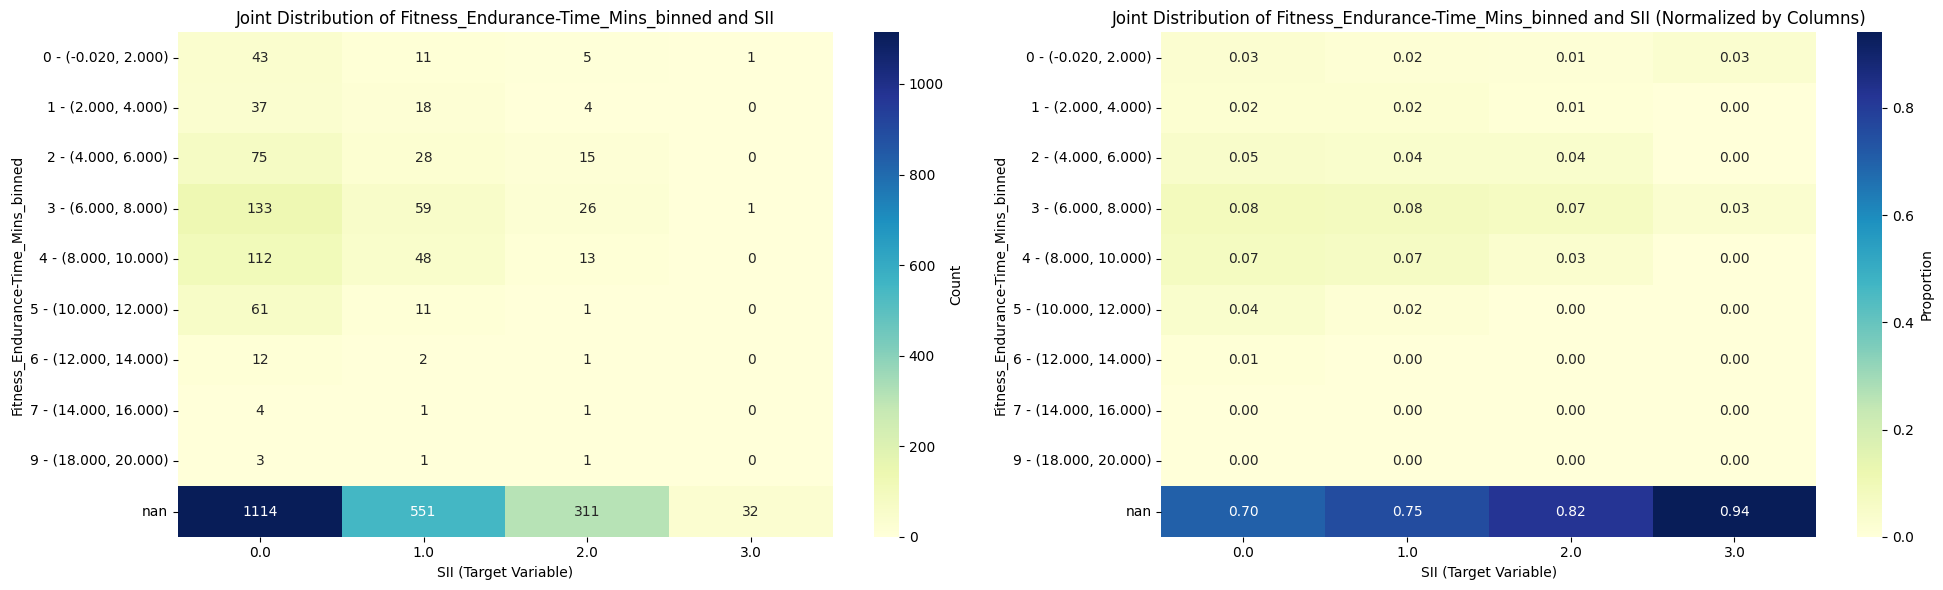

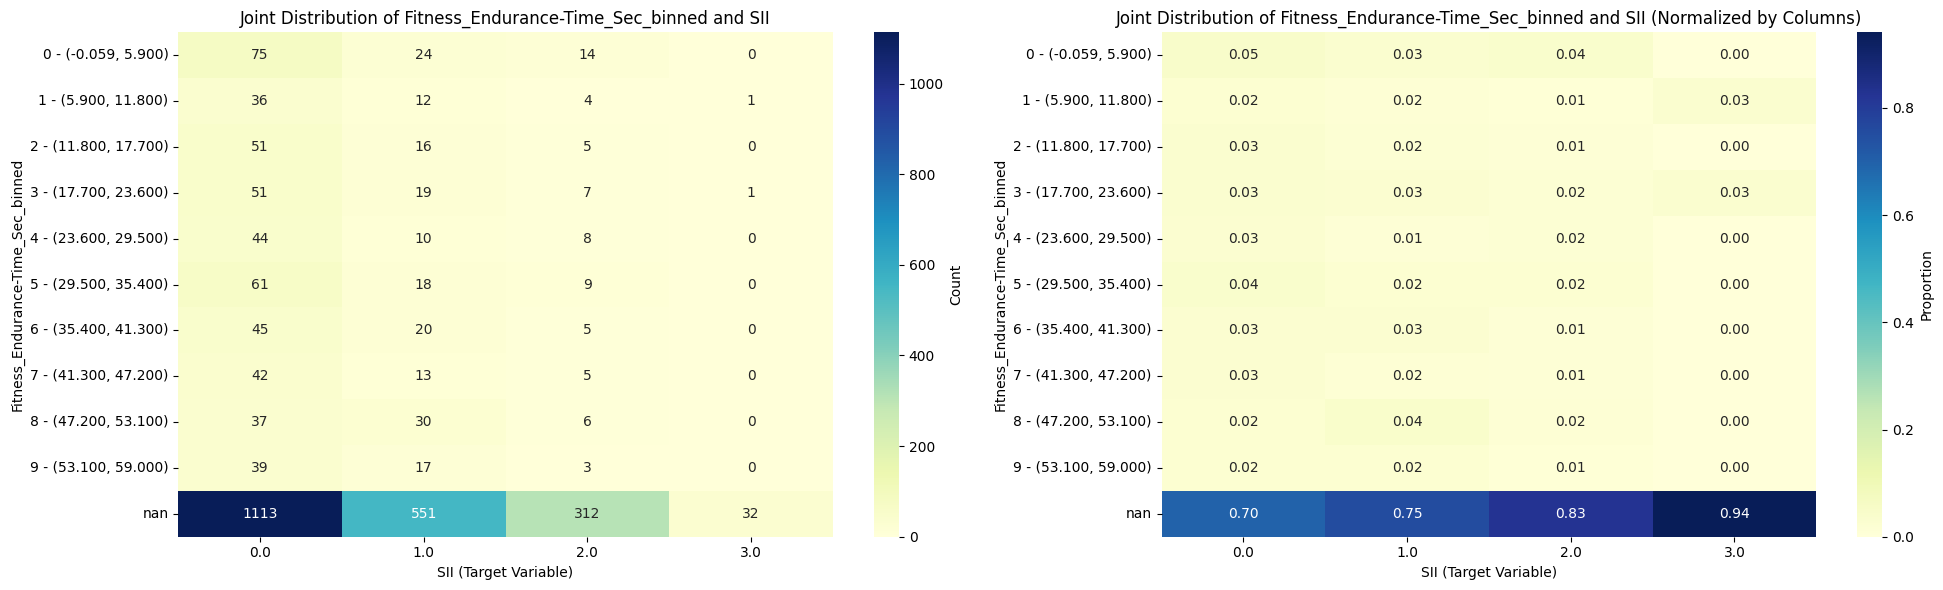

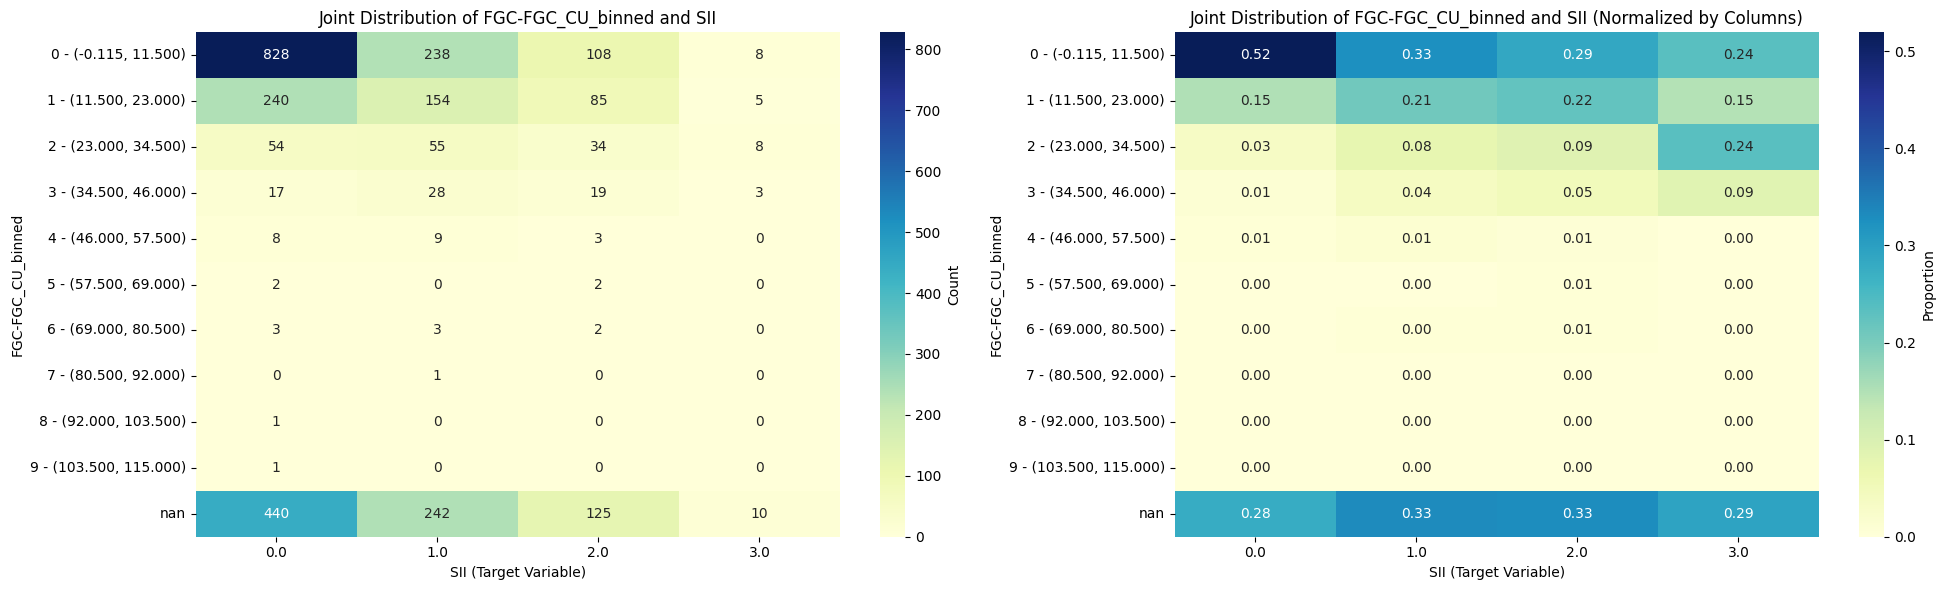

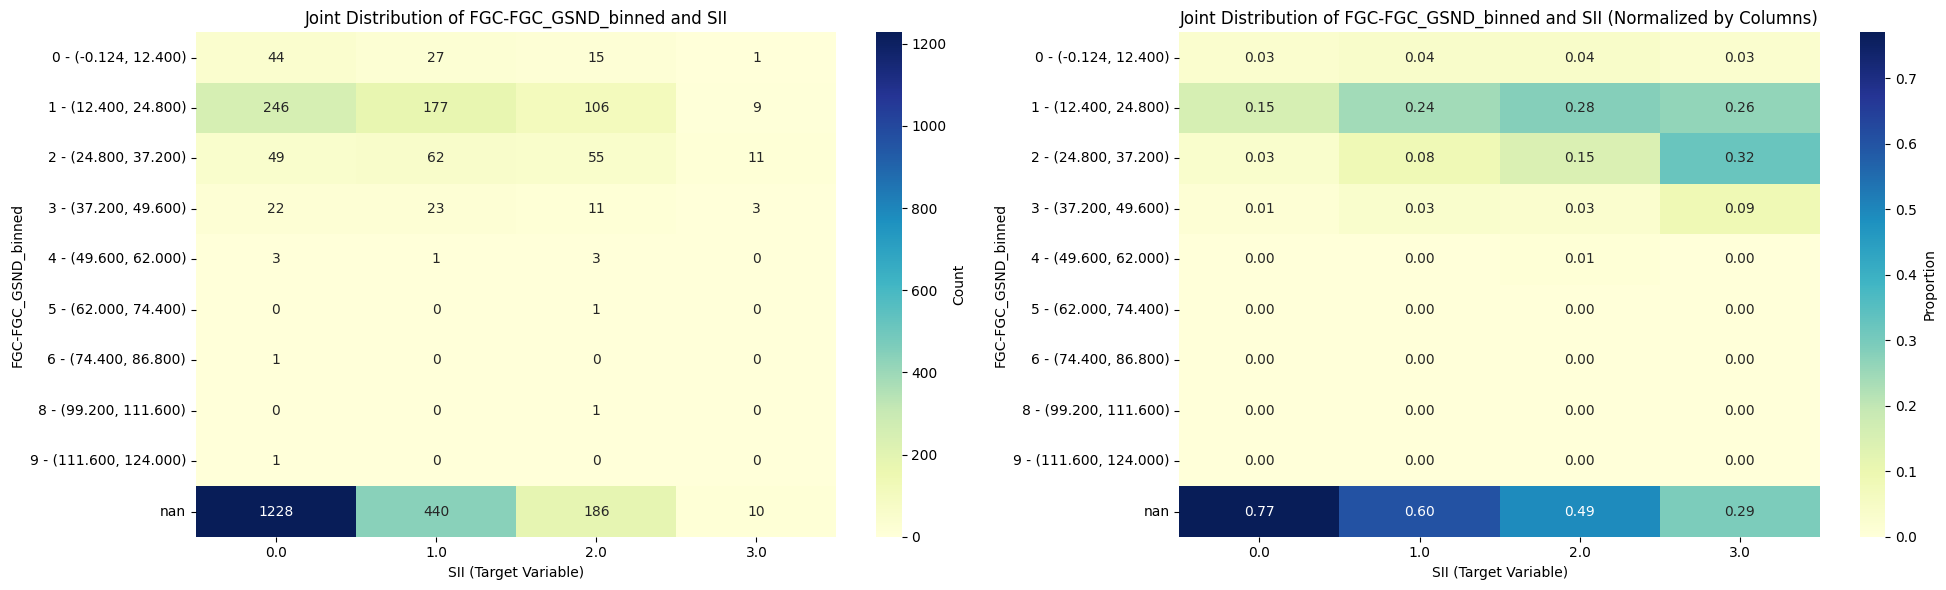

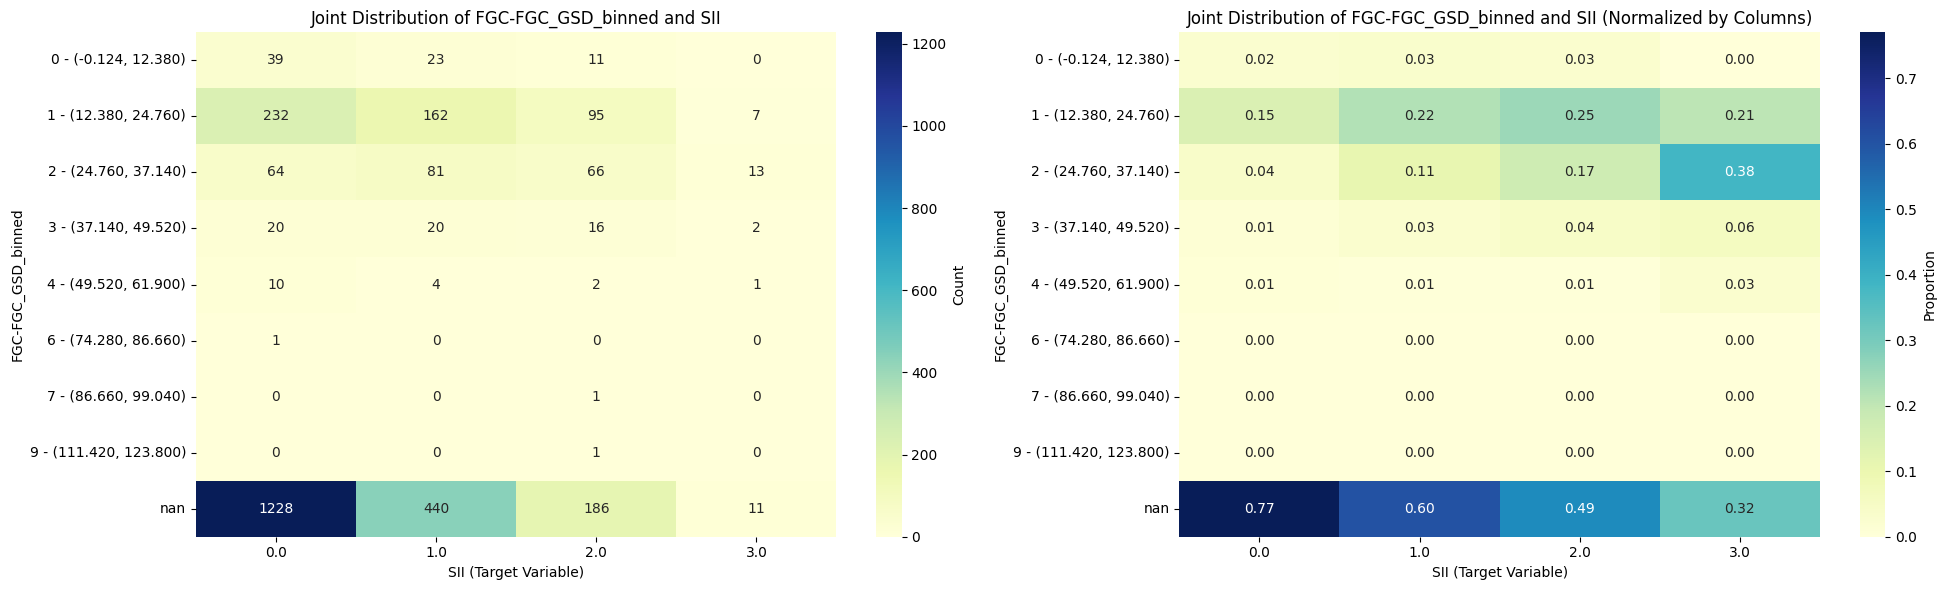

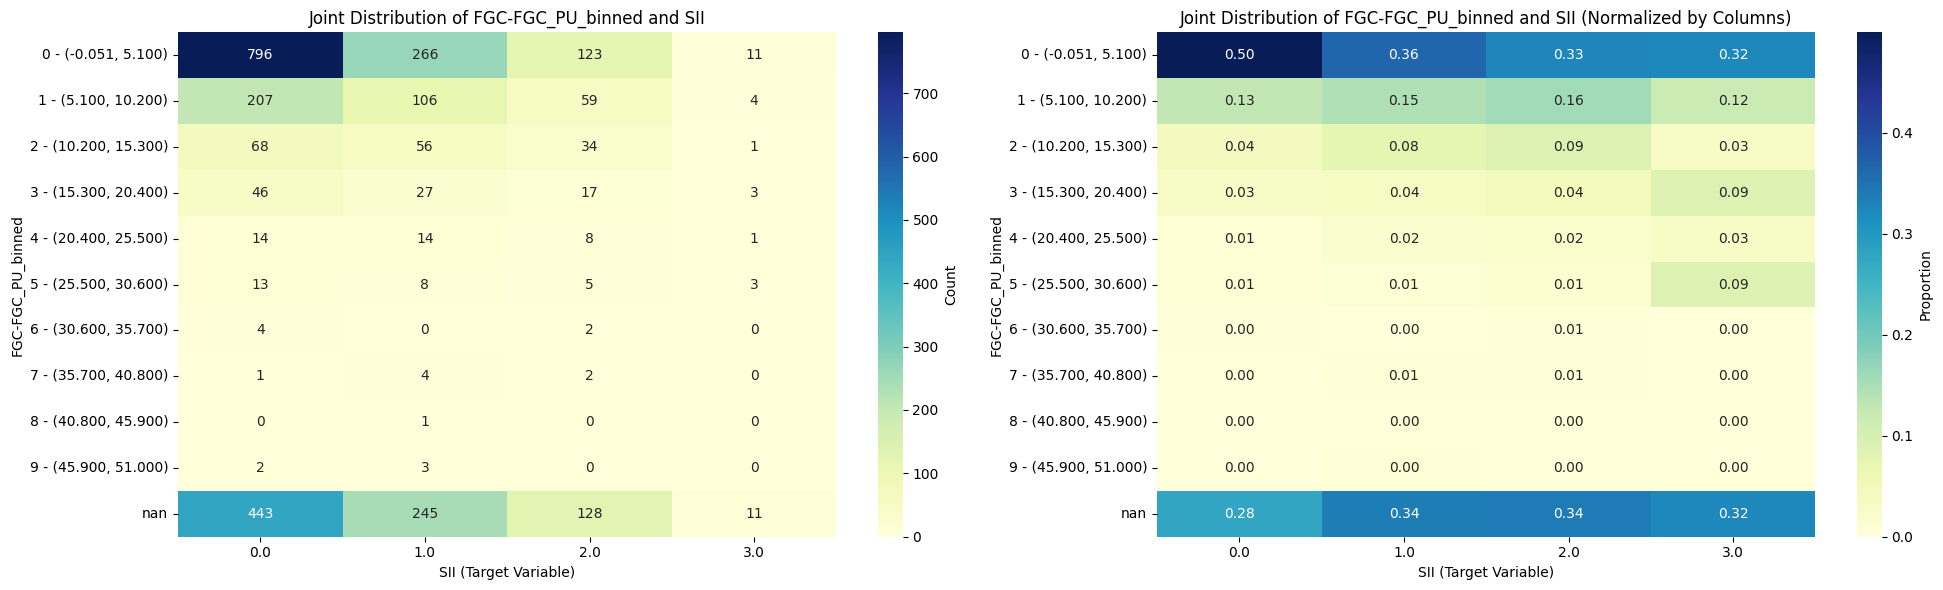

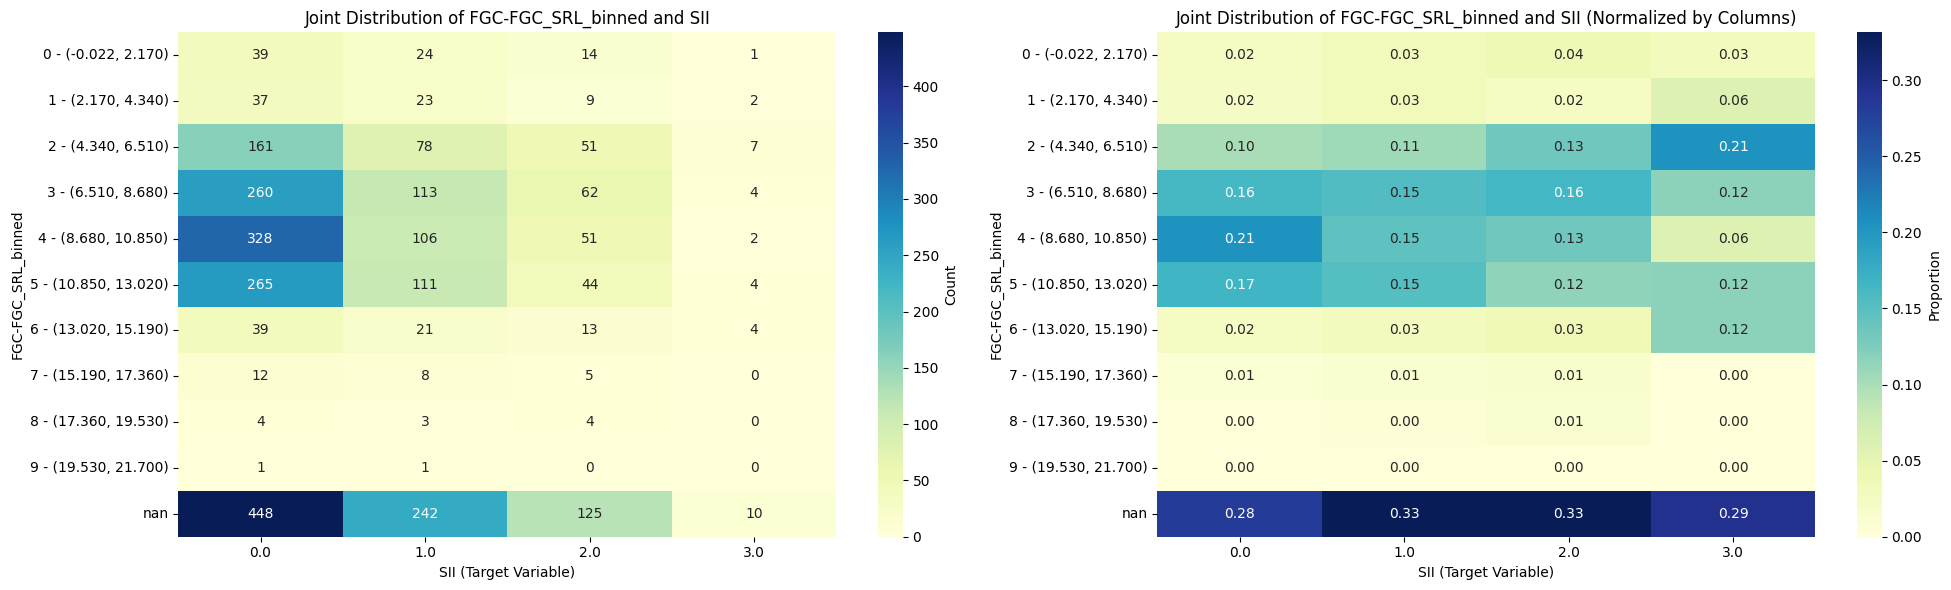

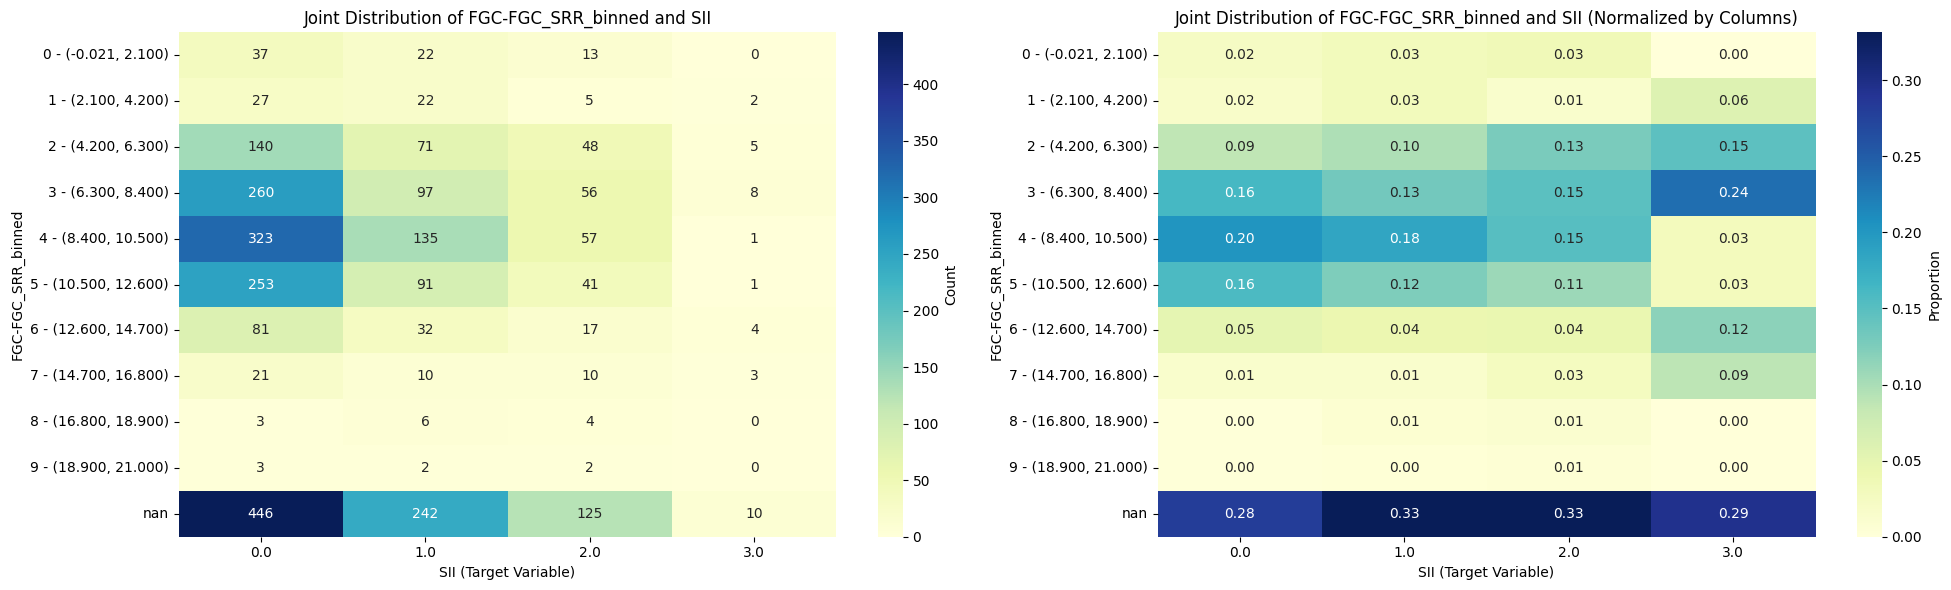

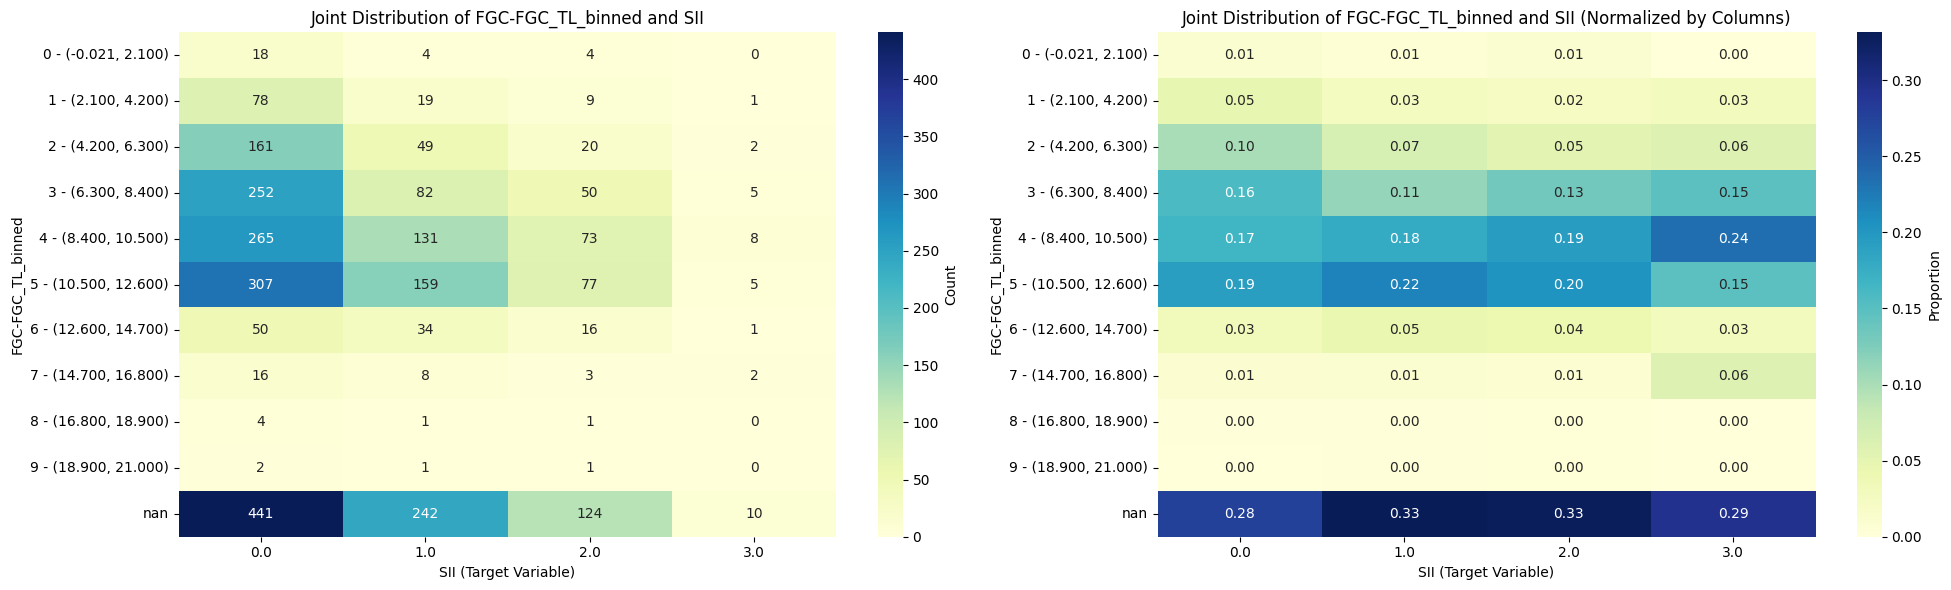

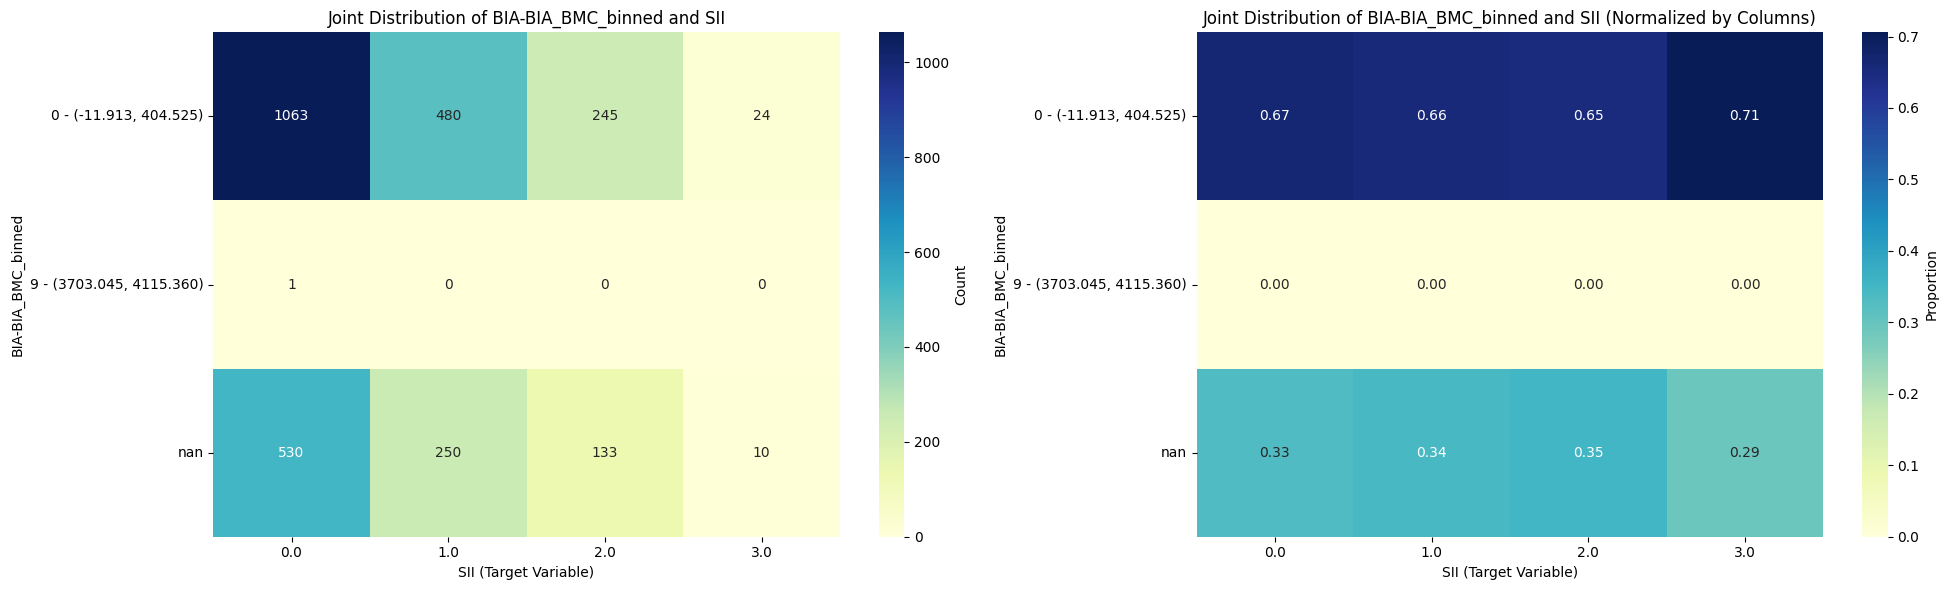

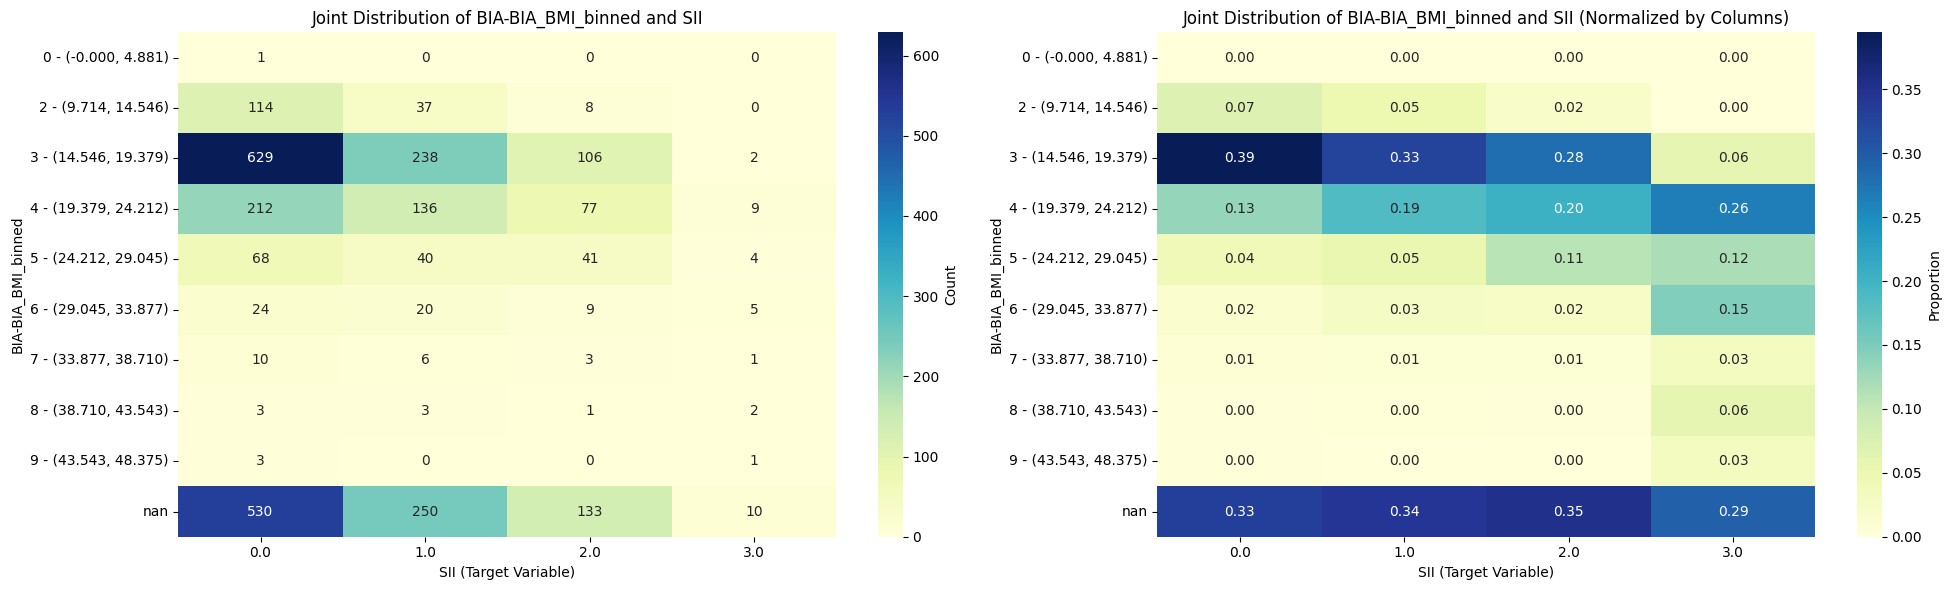

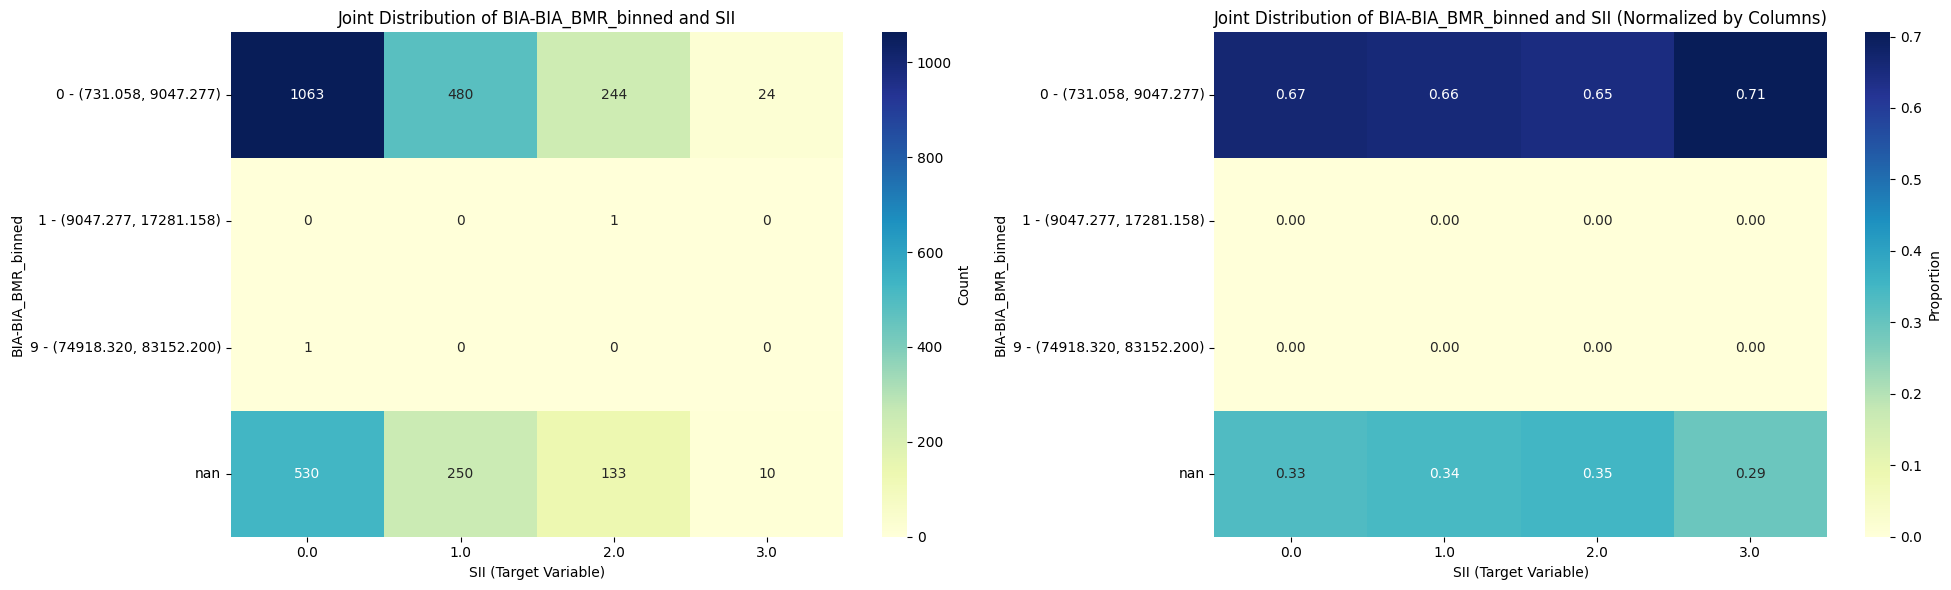

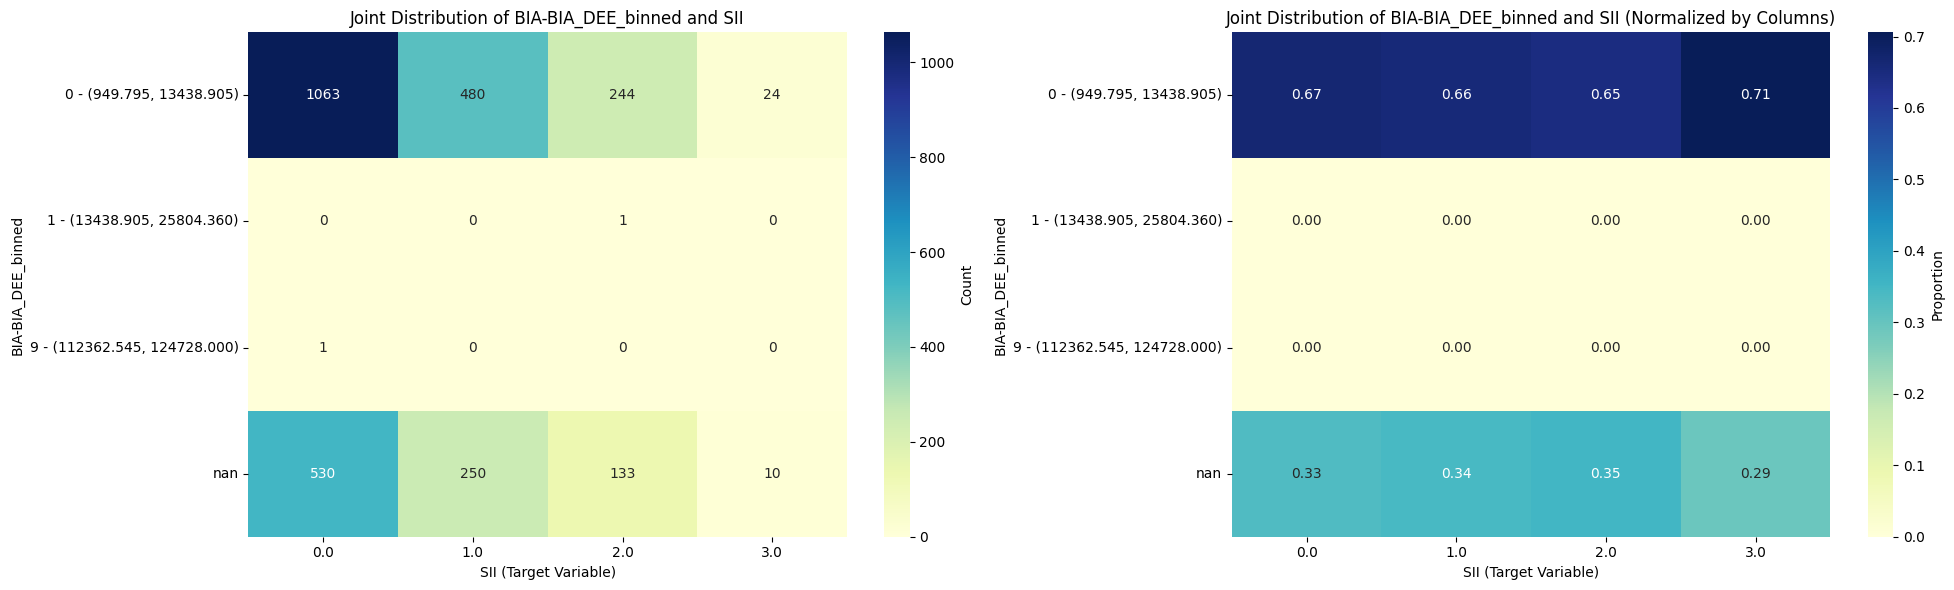

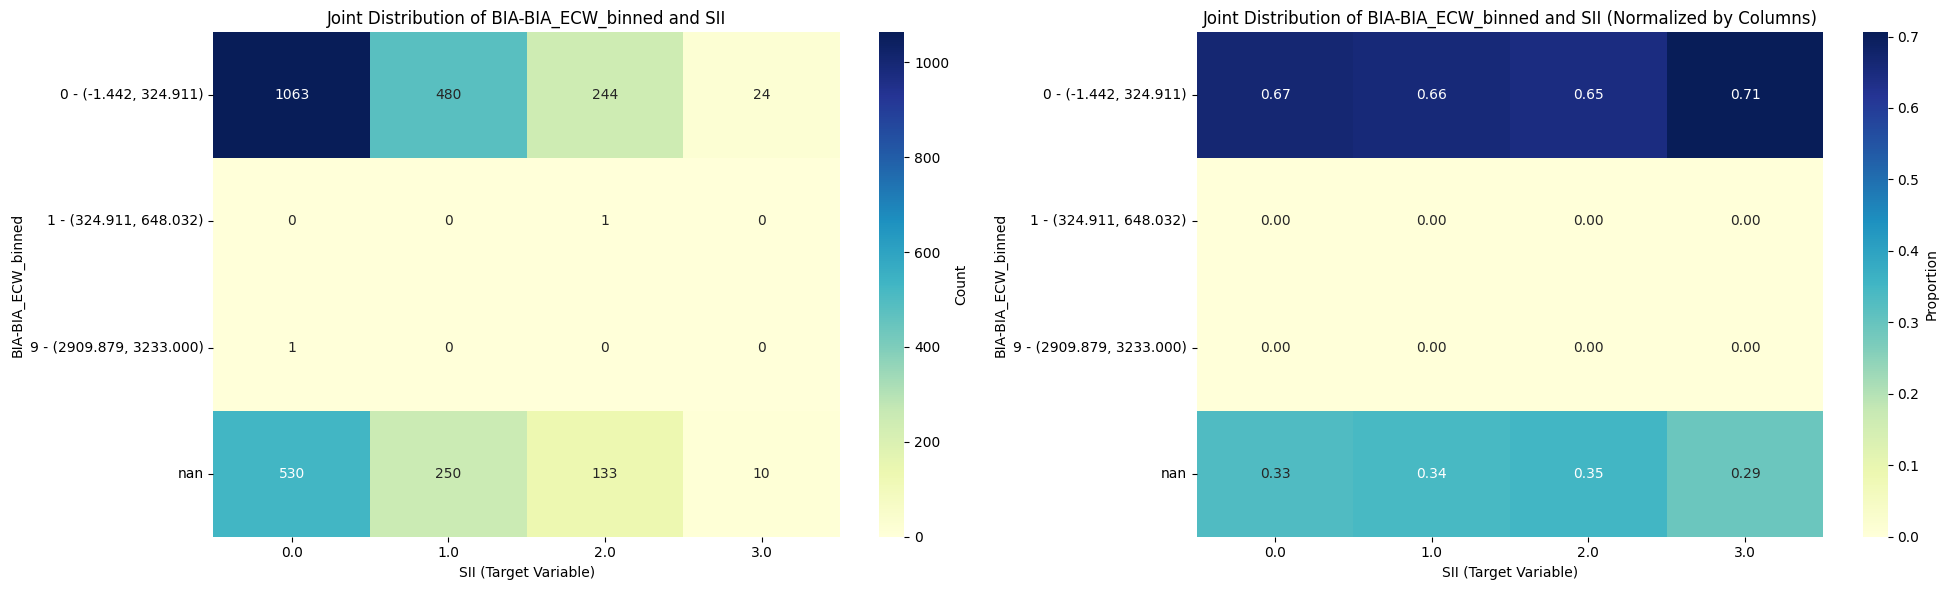

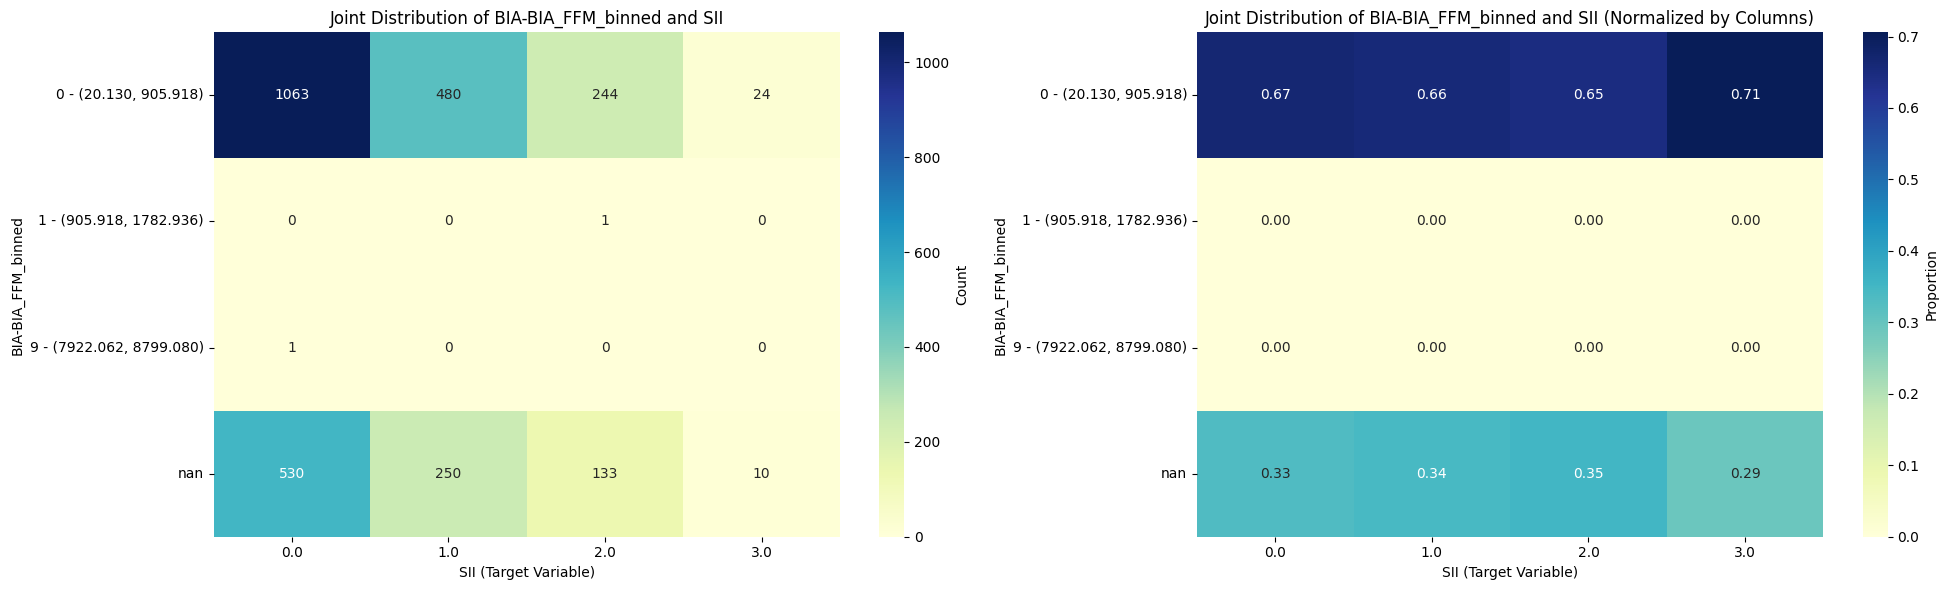

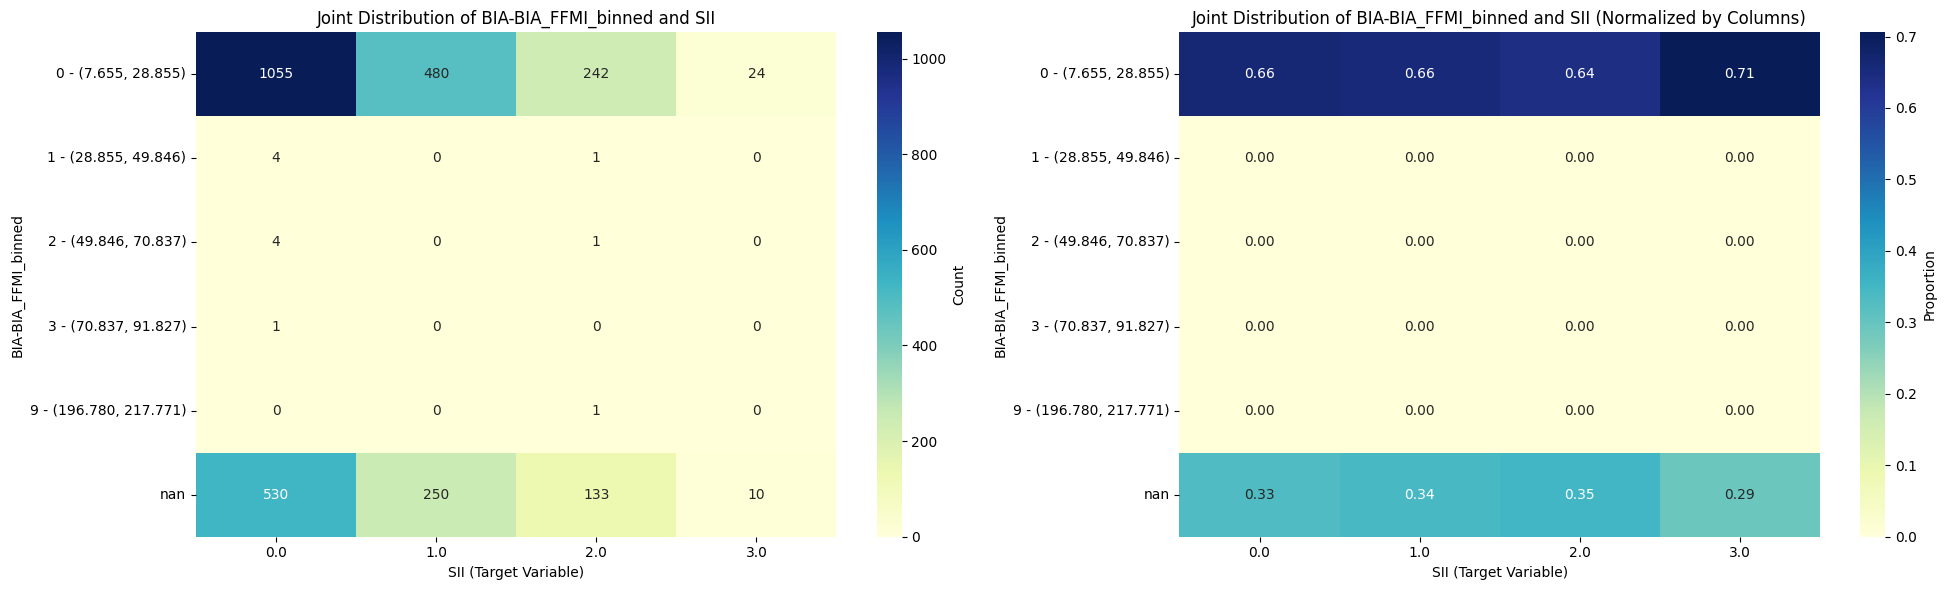

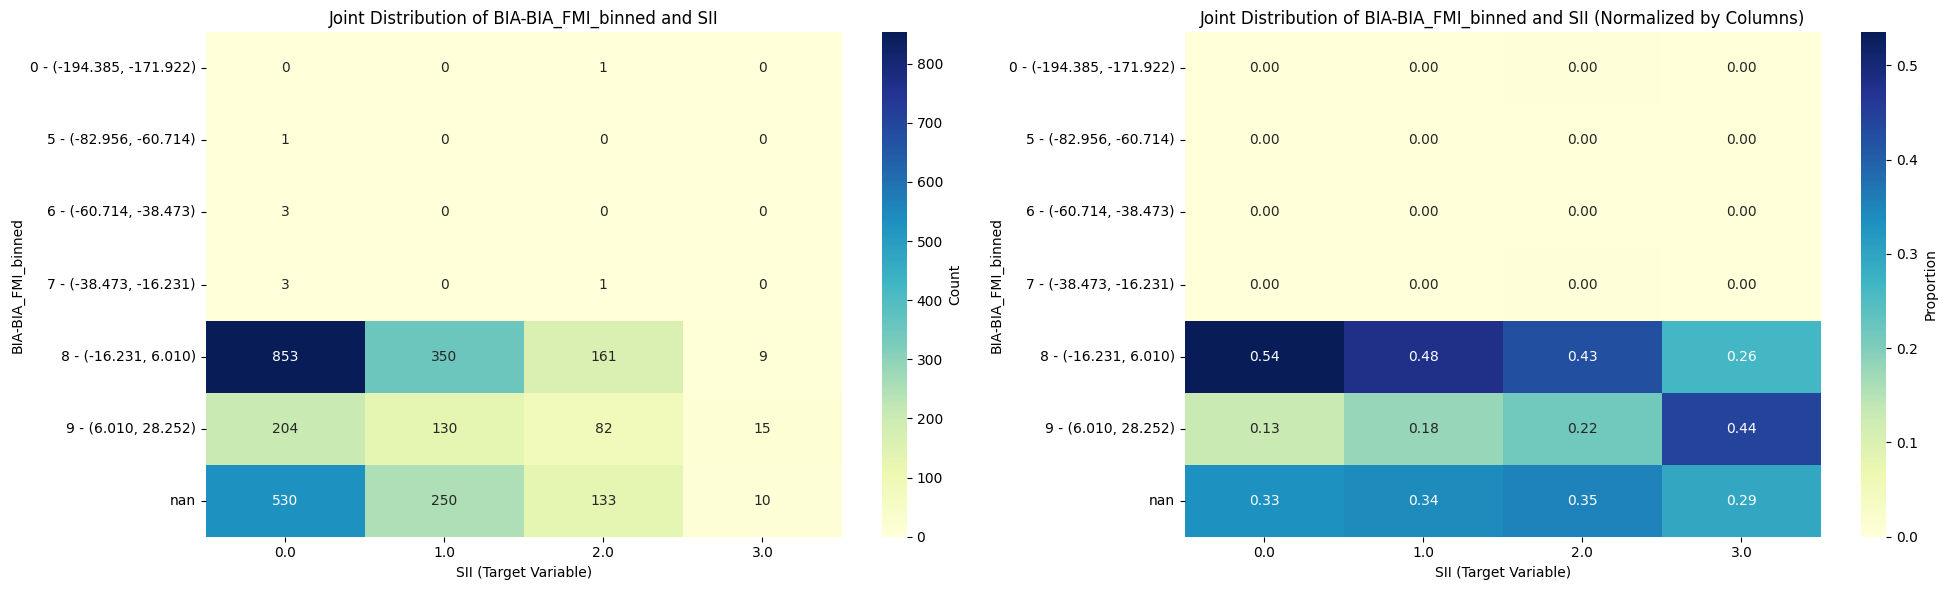

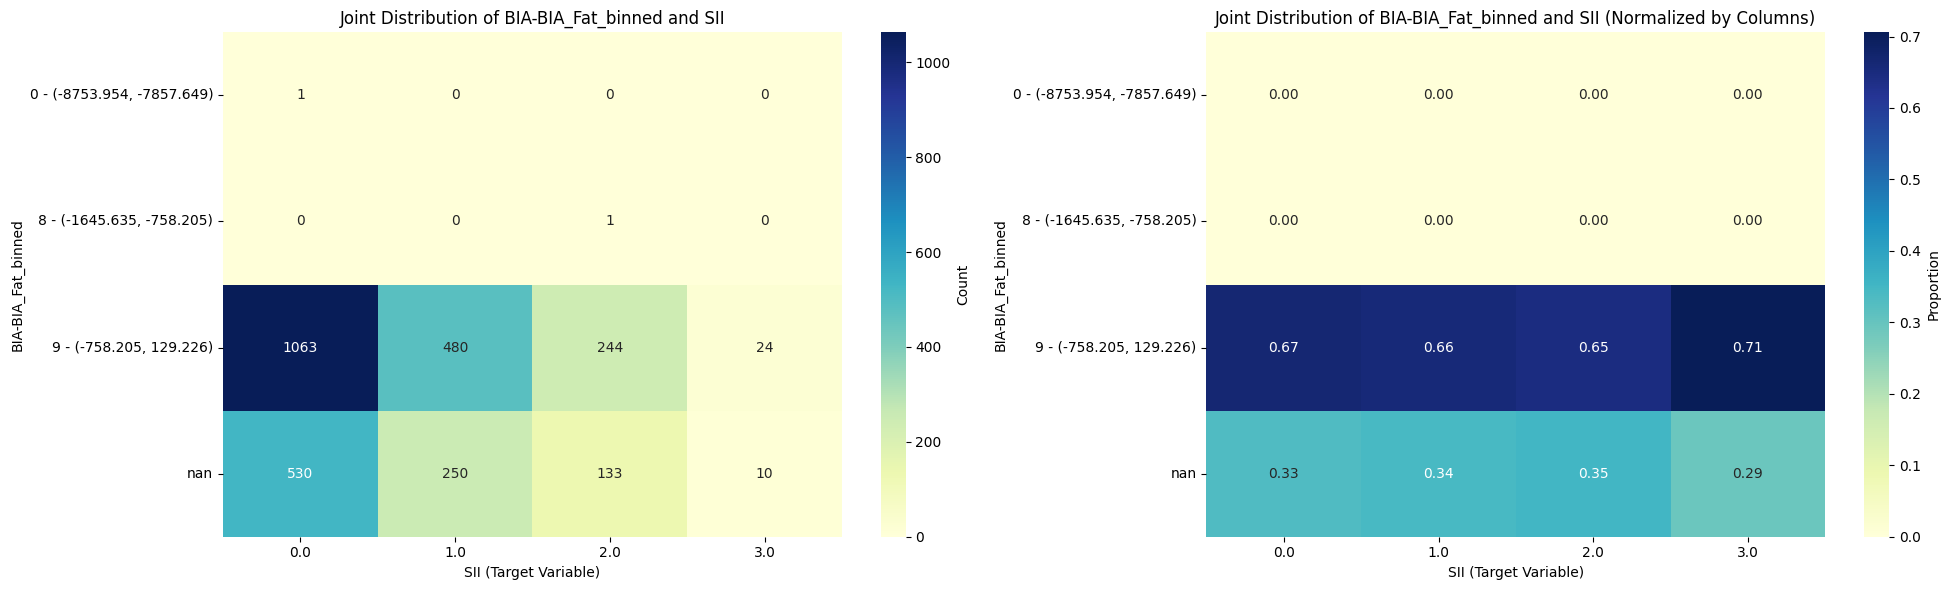

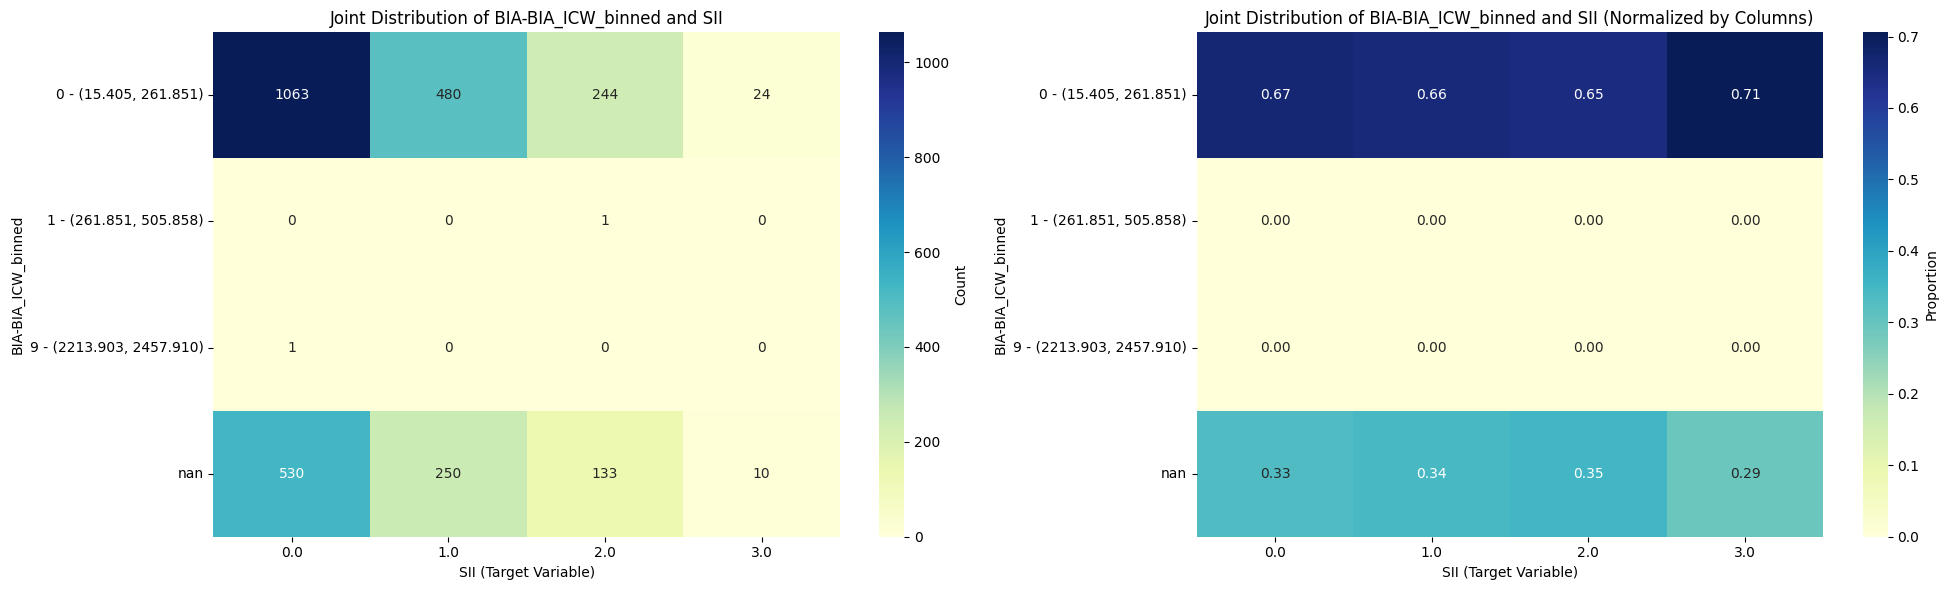

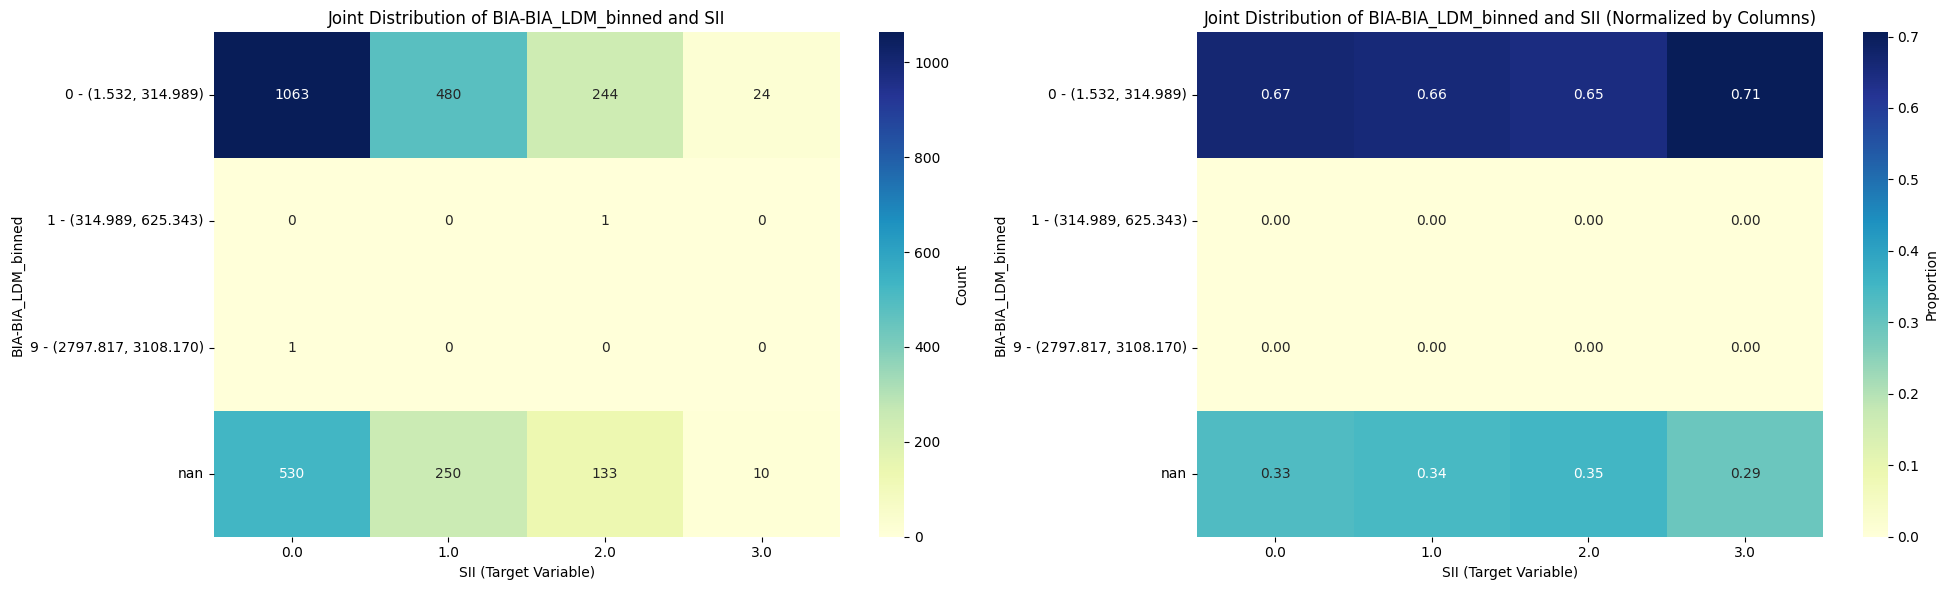

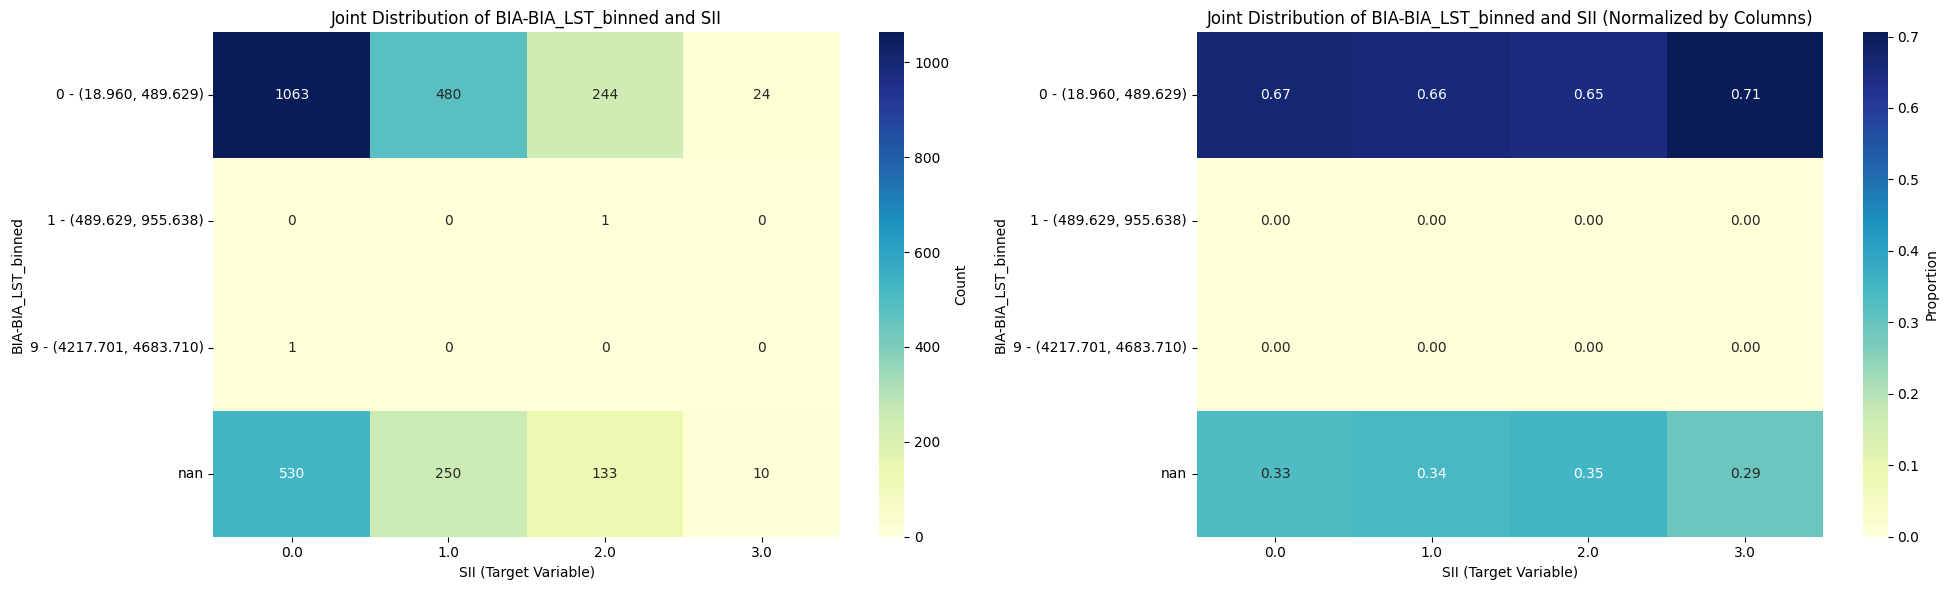

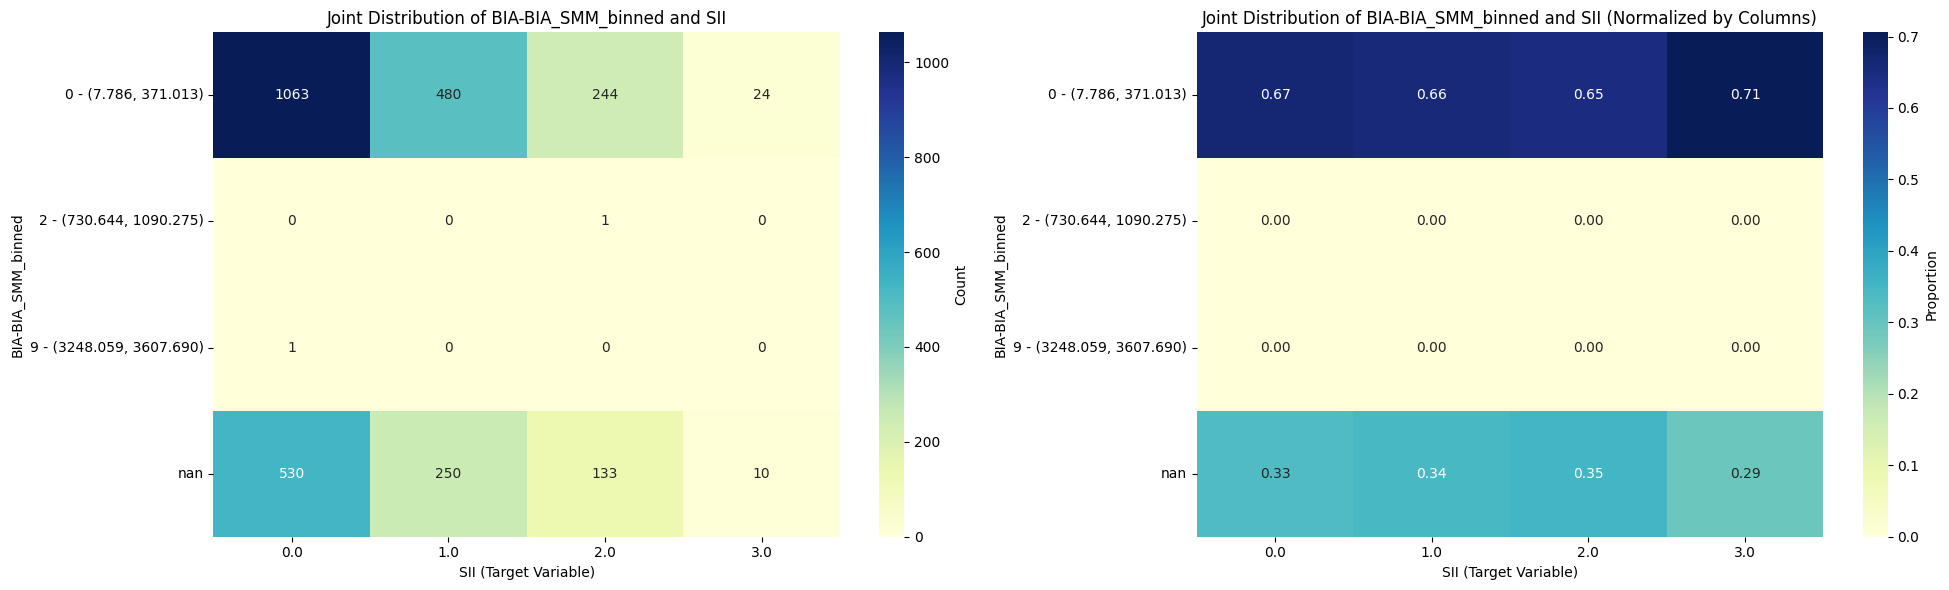

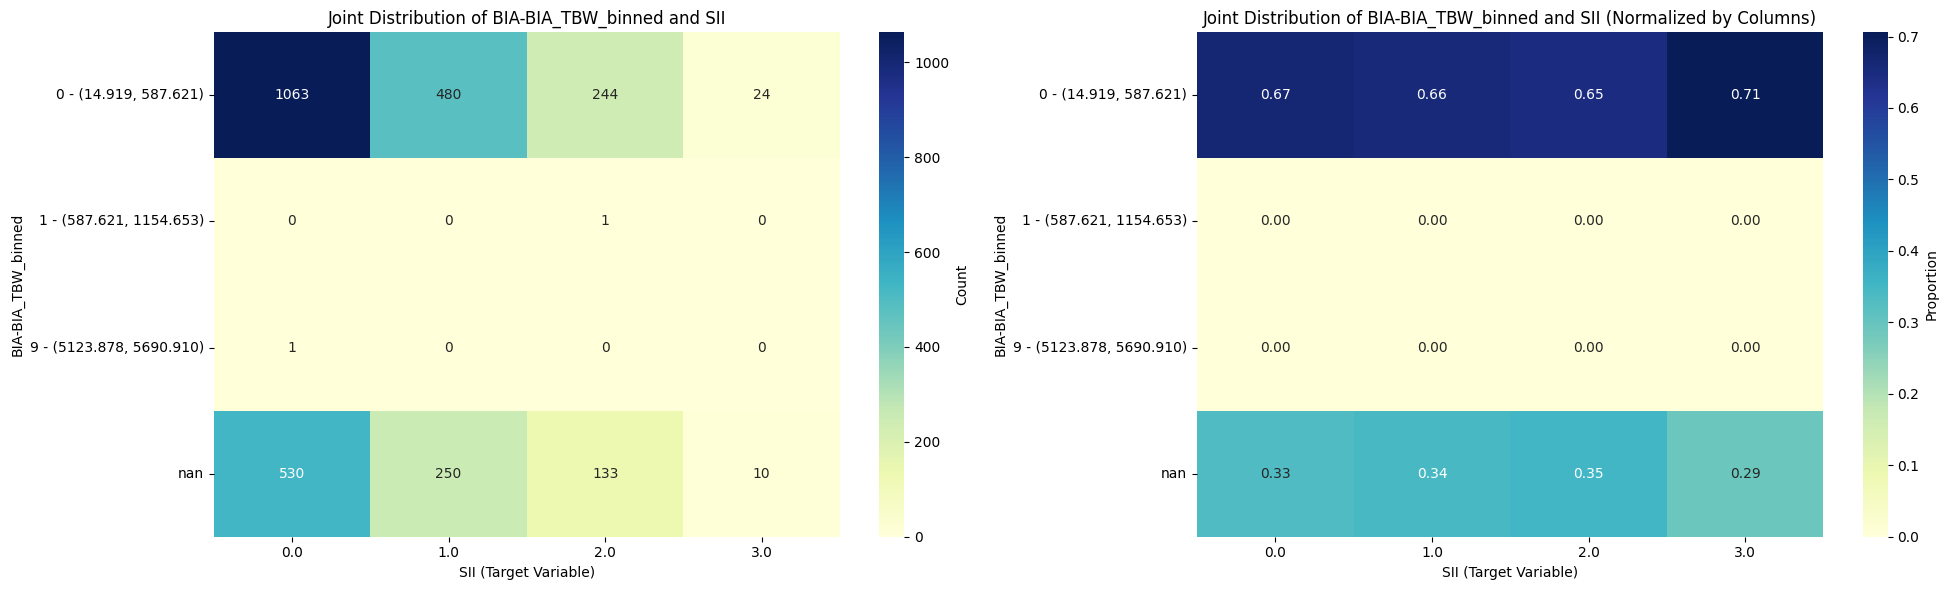

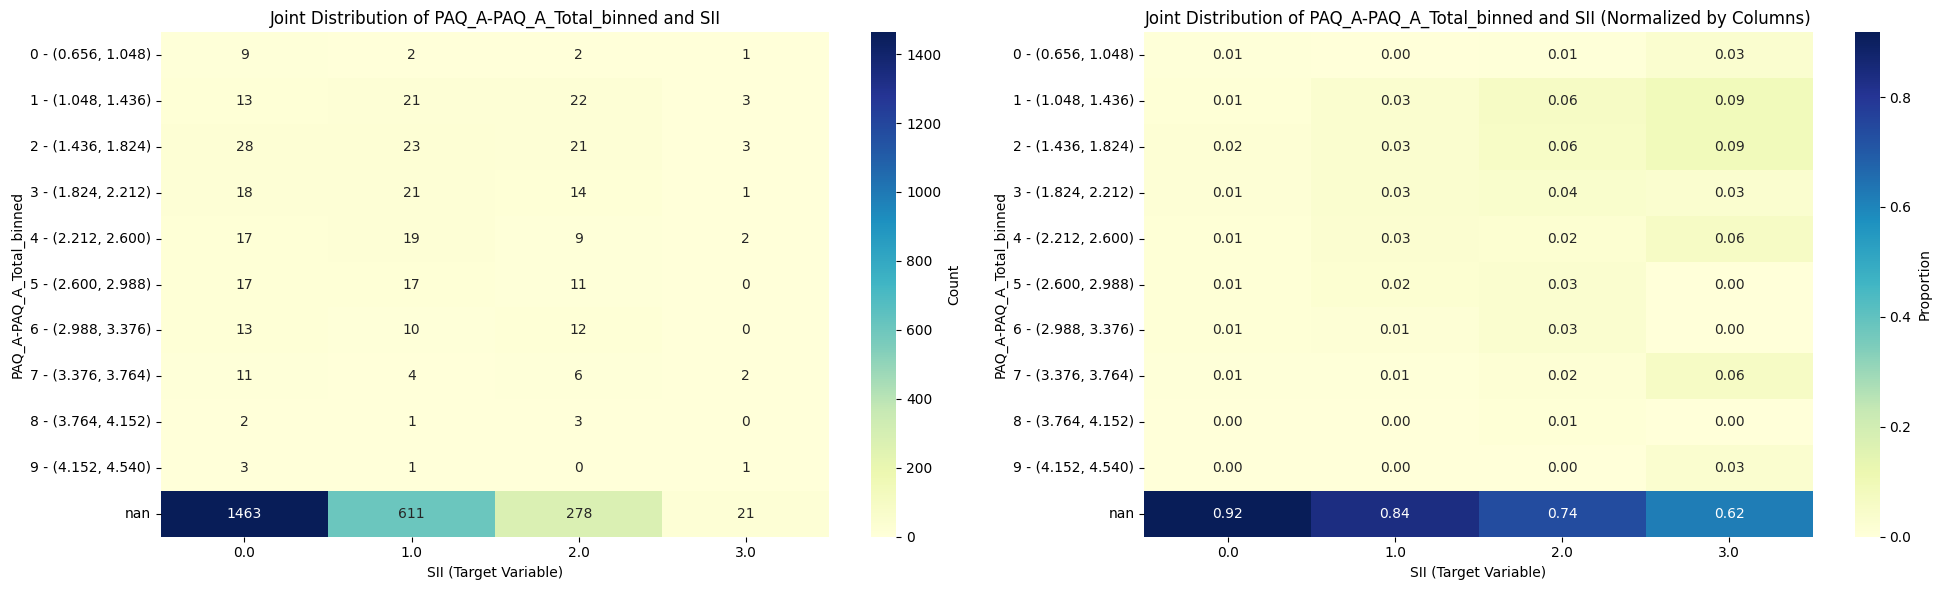

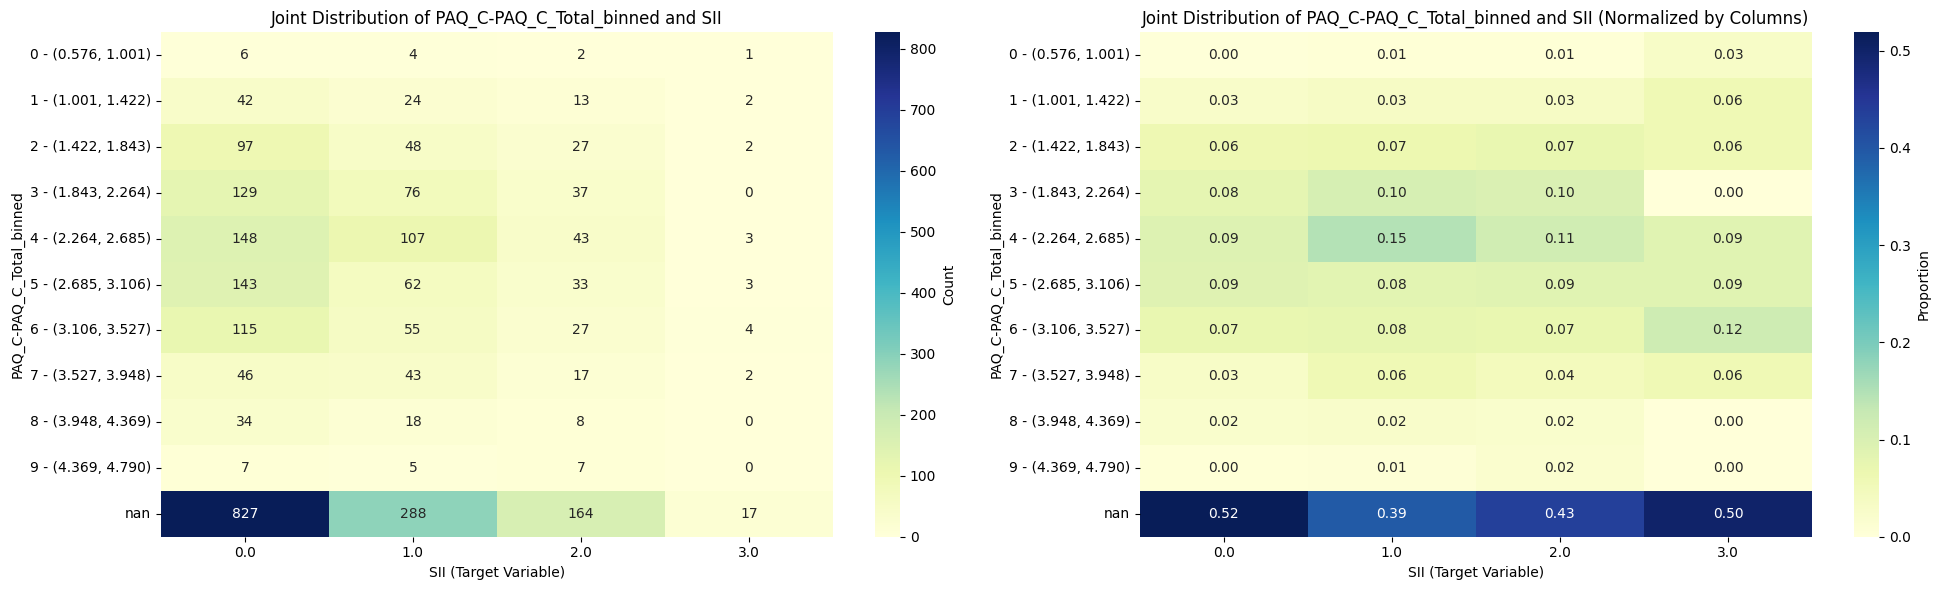

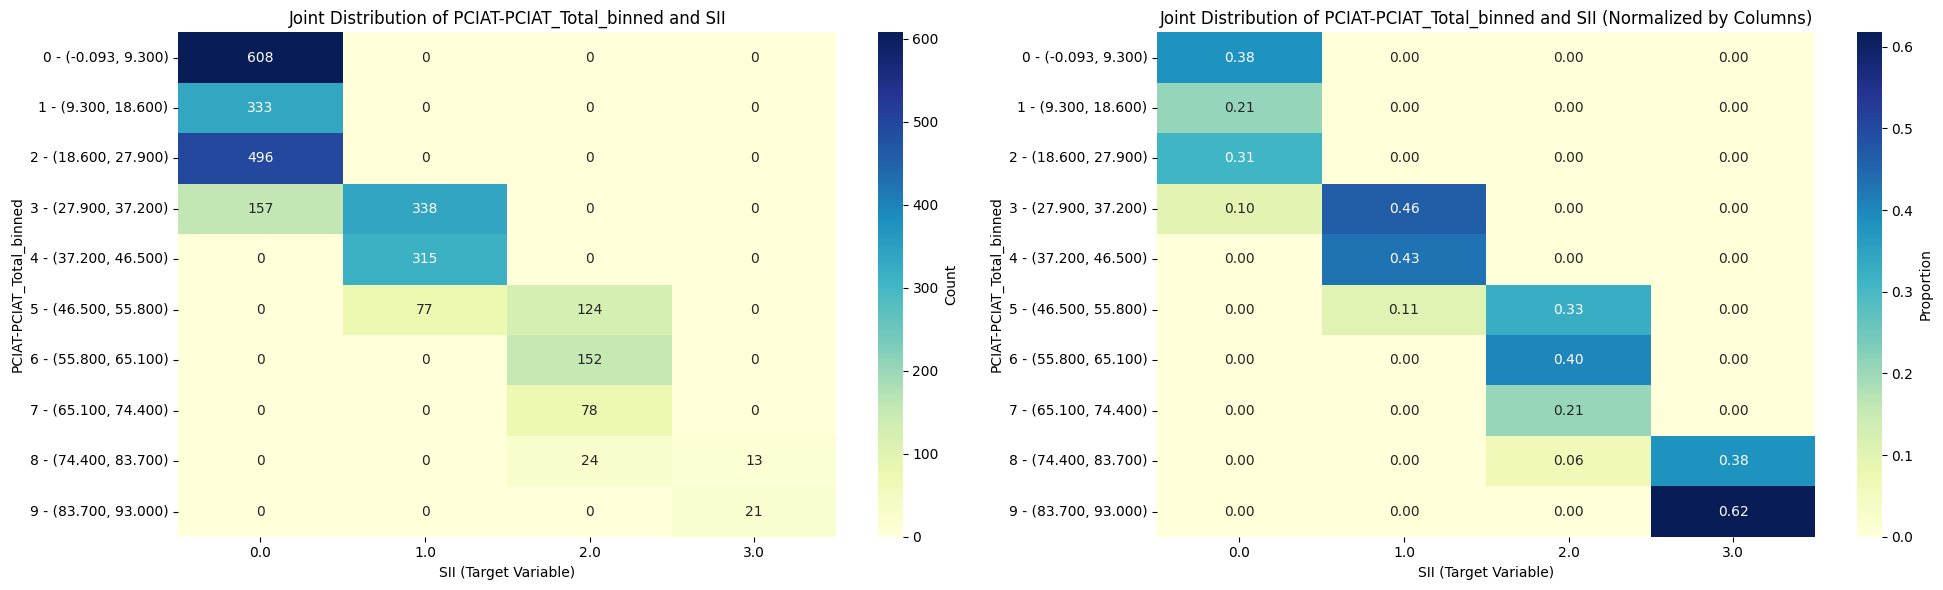

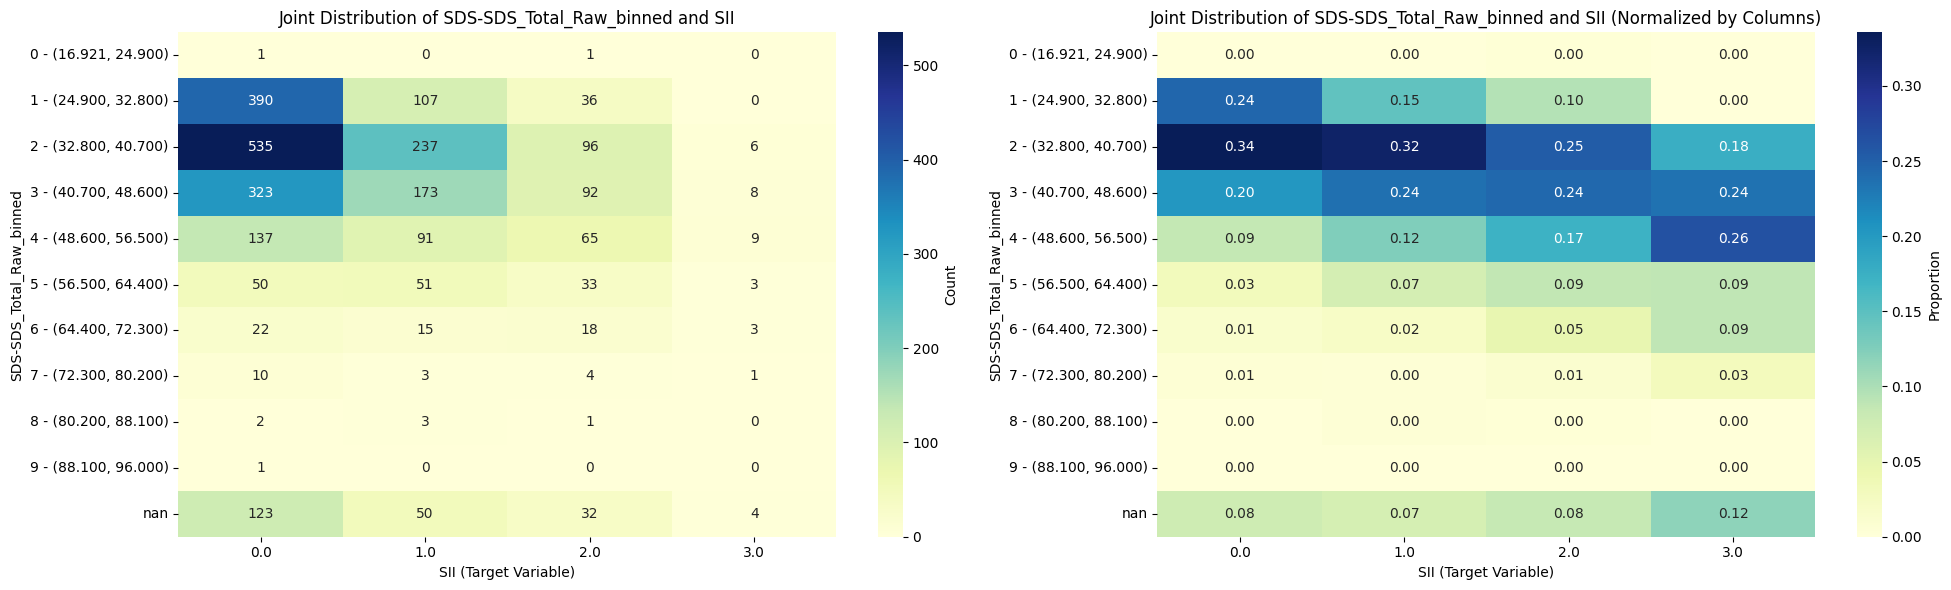

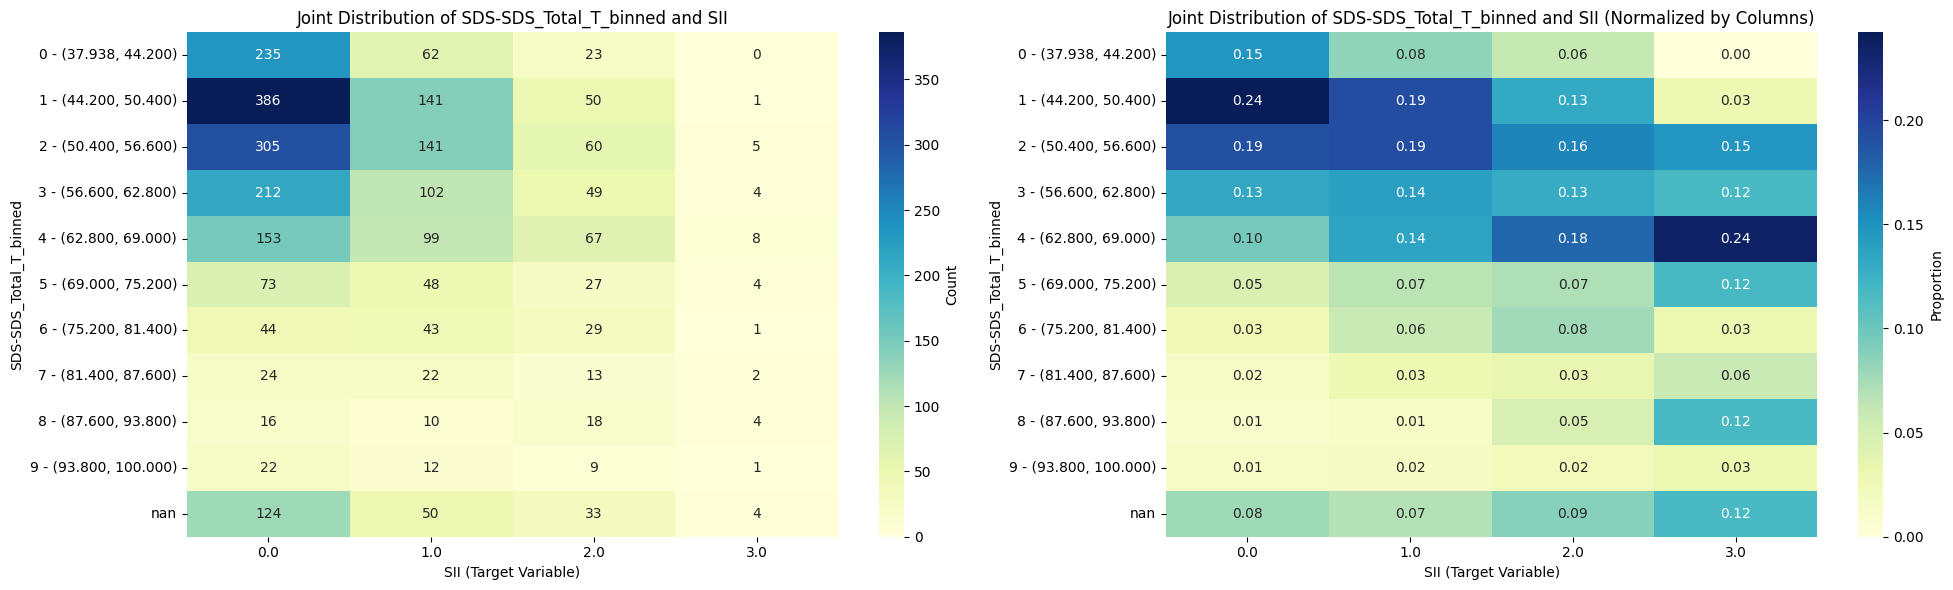

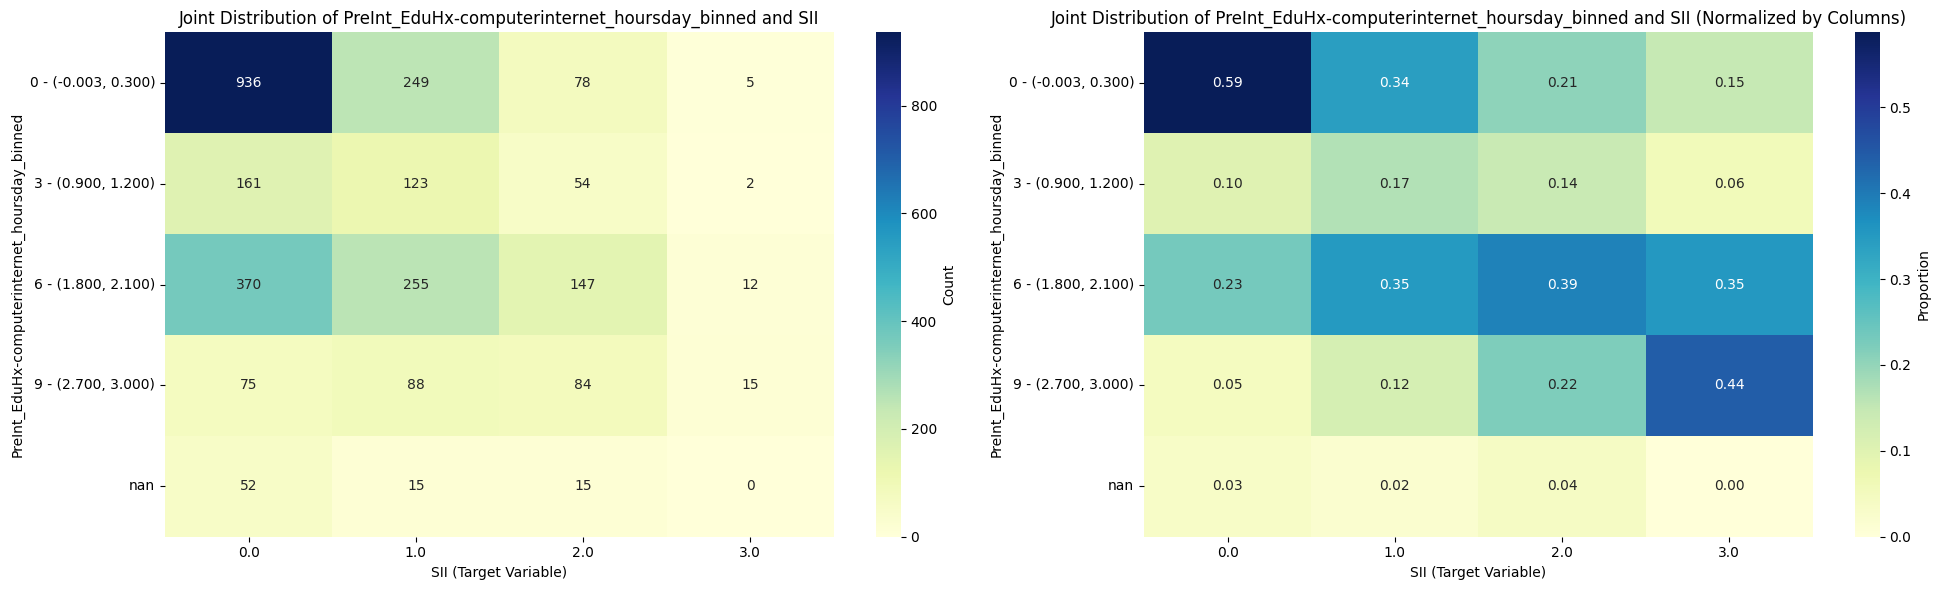

In [15]:
variables = [
'Basic_Demos-Enroll_Season', 'Basic_Demos-Sex', 'CGAS-Season',
       'Physical-Season', 'Fitness_Endurance-Season', 'FGC-Season',
       'FGC-FGC_CU_Zone', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD_Zone',
       'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone',
       'FGC-FGC_TL_Zone', 'BIA-Season', 'BIA-BIA_Activity_Level_num',
       'BIA-BIA_Frame_num', 'PAQ_A-Season', 'PAQ_C-Season', 
       'SDS-Season', 'PreInt_EduHx-Season', 'Basic_Demos-Age_binned',
       'CGAS-CGAS_Score_binned', 'Physical-BMI_binned',
       'Physical-Height_binned', 'Physical-Weight_binned',
       'Physical-Waist_Circumference_binned', 'Physical-Diastolic_BP_binned',
       'Physical-HeartRate_binned', 'Physical-Systolic_BP_binned',
       'Fitness_Endurance-Max_Stage_binned',
       'Fitness_Endurance-Time_Mins_binned',
       'Fitness_Endurance-Time_Sec_binned', 'FGC-FGC_CU_binned',
       'FGC-FGC_GSND_binned', 'FGC-FGC_GSD_binned', 'FGC-FGC_PU_binned',
       'FGC-FGC_SRL_binned', 'FGC-FGC_SRR_binned', 'FGC-FGC_TL_binned',
       'BIA-BIA_BMC_binned', 'BIA-BIA_BMI_binned', 'BIA-BIA_BMR_binned',
       'BIA-BIA_DEE_binned', 'BIA-BIA_ECW_binned', 'BIA-BIA_FFM_binned',
       'BIA-BIA_FFMI_binned', 'BIA-BIA_FMI_binned', 'BIA-BIA_Fat_binned',
       'BIA-BIA_ICW_binned', 'BIA-BIA_LDM_binned', 'BIA-BIA_LST_binned',
       'BIA-BIA_SMM_binned', 'BIA-BIA_TBW_binned', 'PAQ_A-PAQ_A_Total_binned',
       'PAQ_C-PAQ_C_Total_binned', 'PCIAT-PCIAT_Total_binned',
       'SDS-SDS_Total_Raw_binned', 'SDS-SDS_Total_T_binned',
       'PreInt_EduHx-computerinternet_hoursday_binned'
]

# Loop through each variable and create heatmaps
for variable in variables:
    # Fill NaN values with a placeholder
    df[variable] = df[variable].fillna('NaN')
    
    # Create a contingency table
    contingency_table = pd.crosstab(df[variable], df['sii'])

    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

    # First heatmap: Absolute counts
    sns.heatmap(contingency_table, annot=True, fmt='d', cmap='YlGnBu', cbar_kws={'label': 'Count'}, ax=axes[0])
    axes[0].set_title(f'Joint Distribution of {variable} and SII')
    axes[0].set_xlabel('SII (Target Variable)')
    axes[0].set_ylabel(variable)
    axes[0].tick_params(axis='x', rotation=0)

    # Second heatmap: Normalized by columns
    normalized_table = contingency_table.div(contingency_table.sum(axis=0), axis=1)
    sns.heatmap(normalized_table, annot=True, fmt='.2f', cmap='YlGnBu', cbar_kws={'label': 'Proportion'}, ax=axes[1])
    axes[1].set_title(f'Joint Distribution of {variable} and SII (Normalized by Columns)')
    axes[1].set_xlabel('SII (Target Variable)')
    axes[1].set_ylabel(variable)
    axes[1].tick_params(axis='x', rotation=0)

    plt.tight_layout()
    plt.show()

# how is the test set looking

In [ ]:
len(test)

In [ ]:
test.head(5)

In [ ]:
test.columns

In [ ]:
df_test = test

In [ ]:
columns_to_convert = [
    'Basic_Demos-Sex', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND_Zone',
    'FGC-FGC_GSD_Zone', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone',
    'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone', 'BIA-BIA_Activity_Level_num',
    'BIA-BIA_Frame_num'
]

# Convert to categorical and add 'NaN' as a category
for column in columns_to_convert:
    df_test[column] = df_test[column].astype('category')
    df_test[column] = df_test[column].cat.add_categories(['NaN'])  # Add 'NaN' as a category
    df_test[column] = df_test[column].fillna('NaN')  # Fill NaN values with 'NaN'

In [ ]:
# Step 1: Identify numeric and categorical columns
numeric_columns = df_test.select_dtypes(include=['int64', 'float64']).columns
numeric_columns = [col for col in numeric_columns if col != 'sii']  # Exclude 'sii'

# Step 2: Create bins for numeric columns
for col in numeric_columns:
    # Ensure the column is numeric
    df_test[col] = pd.to_numeric(df_test[col], errors='coerce')

    # Create 10 bins and get the bin edges
    bin_edges = pd.cut(df_test[col], bins=10, retbins=True)[1]

    # Create bin labels with ranges, ordered by the bin edges
    bin_labels = []
    for i in range(len(bin_edges) - 1):
        bin_labels.append(f"{i} - ({bin_edges[i]:.3f}, {bin_edges[i + 1]:.3f})")

    # Assign the bin labels to the bins
    bins = pd.cut(df_test[col], bins=bin_edges, labels=bin_labels, include_lowest=True)

    # Assign binned labels to a new column
    df_test[col + '_binned'] = bins.astype(str)

# Step 3: Drop the original numeric columns
df_test = df_test.drop(columns=numeric_columns)

In [ ]:
# Create a figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# First plot: Distribution of Basic_Demos-Sex
contingency_table = df_test['Basic_Demos-Sex'].value_counts().reset_index()
contingency_table.columns = ['Basic_Demos-Sex', 'Count']
sns.heatmap(contingency_table.set_index('Basic_Demos-Sex'), annot=True, fmt='d', cmap='YlGnBu', cbar_kws={'label': 'Count'}, ax=axes[0])
axes[0].set_title('Distribution of Basic_Demos-Sex in Test Set')
axes[0].set_xlabel('Basic_Demos-Sex')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

# Second plot: Proportions
normalized_table = contingency_table['Count'] / contingency_table['Count'].sum()
sns.barplot(x=contingency_table['Basic_Demos-Sex'], y=normalized_table, ax=axes[1], palette='Blues')
axes[1].set_title('Proportion of Basic_Demos-Sex in Test Set')
axes[1].set_xlabel('Basic_Demos-Sex')
axes[1].set_ylabel('Proportion')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

In [ ]:
variables = [
'Basic_Demos-Enroll_Season', 'Basic_Demos-Sex', 'CGAS-Season',
       'Physical-Season', 'Fitness_Endurance-Season', 'FGC-Season',
       'FGC-FGC_CU_Zone', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD_Zone',
       'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone',
       'FGC-FGC_TL_Zone', 'BIA-Season', 'BIA-BIA_Activity_Level_num',
       'BIA-BIA_Frame_num', 'PAQ_A-Season', 'PAQ_C-Season', 
       'SDS-Season', 'PreInt_EduHx-Season', 'Basic_Demos-Age_binned',
       'CGAS-CGAS_Score_binned', 'Physical-BMI_binned',
       'Physical-Height_binned', 'Physical-Weight_binned',
       'Physical-Waist_Circumference_binned', 'Physical-Diastolic_BP_binned',
       'Physical-HeartRate_binned', 'Physical-Systolic_BP_binned',
       'Fitness_Endurance-Max_Stage_binned',
       'Fitness_Endurance-Time_Mins_binned',
       'Fitness_Endurance-Time_Sec_binned', 'FGC-FGC_CU_binned',
       'FGC-FGC_GSND_binned', 'FGC-FGC_GSD_binned', 'FGC-FGC_PU_binned',
       'FGC-FGC_SRL_binned', 'FGC-FGC_SRR_binned', 'FGC-FGC_TL_binned',
       'BIA-BIA_BMC_binned', 'BIA-BIA_BMI_binned', 'BIA-BIA_BMR_binned',
       'BIA-BIA_DEE_binned', 'BIA-BIA_ECW_binned', 'BIA-BIA_FFM_binned',
       'BIA-BIA_FFMI_binned', 'BIA-BIA_FMI_binned', 'BIA-BIA_Fat_binned',
       'BIA-BIA_ICW_binned', 'BIA-BIA_LDM_binned', 'BIA-BIA_LST_binned',
       'BIA-BIA_SMM_binned', 'BIA-BIA_TBW_binned', 'PAQ_A-PAQ_A_Total_binned',
       'PAQ_C-PAQ_C_Total_binned',
       'SDS-SDS_Total_Raw_binned', 'SDS-SDS_Total_T_binned',
       'PreInt_EduHx-computerinternet_hoursday_binned'
]

# Loop through each variable and create heatmaps
for variable in variables:
    # Fill NaN values with a placeholder
    df[variable] = df[variable].fillna('NaN')
    
    contingency_table = df[variable].value_counts().reset_index()
    contingency_table.columns = [variable, 'Count']
        
    # Order the variable based on bin names
    contingency_table[variable] = pd.Categorical(contingency_table[variable], ordered=True)
    contingency_table = contingency_table.sort_values(variable)

    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

    # First heatmap: Absolute counts
    sns.heatmap(contingency_table.set_index(variable), annot=True, fmt='d', cmap='YlGnBu', cbar_kws={'label': 'Count'}, ax=axes[0])
    axes[0].set_title(f'Distribution of {variable} in Test Set')
    axes[0].set_xlabel(variable)
    axes[0].set_ylabel('Count')

    # Second heatmap: Proportions
    normalized_table = contingency_table['Count'] / contingency_table['Count'].sum()
    sns.barplot(x=contingency_table[variable], y=normalized_table, ax=axes[1], palette='Blues')
    axes[1].set_title(f'Proportion of {variable} in Test Set')
    axes[1].set_xlabel(variable)
    axes[1].set_ylabel('Proportion')

    plt.tight_layout()
    plt.show()

# Train and test plots 

In [ ]:
variables = [
'Basic_Demos-Enroll_Season', 'Basic_Demos-Sex', 'CGAS-Season',
       'Physical-Season', 'Fitness_Endurance-Season', 'FGC-Season',
       'FGC-FGC_CU_Zone', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD_Zone',
       'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone',
       'FGC-FGC_TL_Zone', 'BIA-Season', 'BIA-BIA_Activity_Level_num',
       'BIA-BIA_Frame_num', 'PAQ_A-Season', 'PAQ_C-Season', 
       'SDS-Season', 'PreInt_EduHx-Season', 'Basic_Demos-Age_binned',
       'CGAS-CGAS_Score_binned', 'Physical-BMI_binned',
       'Physical-Height_binned', 'Physical-Weight_binned',
       'Physical-Waist_Circumference_binned', 'Physical-Diastolic_BP_binned',
       'Physical-HeartRate_binned', 'Physical-Systolic_BP_binned',
       'Fitness_Endurance-Max_Stage_binned',
       'Fitness_Endurance-Time_Mins_binned',
       'Fitness_Endurance-Time_Sec_binned', 'FGC-FGC_CU_binned',
       'FGC-FGC_GSND_binned', 'FGC-FGC_GSD_binned', 'FGC-FGC_PU_binned',
       'FGC-FGC_SRL_binned', 'FGC-FGC_SRR_binned', 'FGC-FGC_TL_binned',
       'BIA-BIA_BMC_binned', 'BIA-BIA_BMI_binned', 'BIA-BIA_BMR_binned',
       'BIA-BIA_DEE_binned', 'BIA-BIA_ECW_binned', 'BIA-BIA_FFM_binned',
       'BIA-BIA_FFMI_binned', 'BIA-BIA_FMI_binned', 'BIA-BIA_Fat_binned',
       'BIA-BIA_ICW_binned', 'BIA-BIA_LDM_binned', 'BIA-BIA_LST_binned',
       'BIA-BIA_SMM_binned', 'BIA-BIA_TBW_binned', 'PAQ_A-PAQ_A_Total_binned',
       'PAQ_C-PAQ_C_Total_binned', 
       'SDS-SDS_Total_Raw_binned', 'SDS-SDS_Total_T_binned',
       'PreInt_EduHx-computerinternet_hoursday_binned'
]

# Loop through each variable and create heatmaps
for variable in variables:
    # Fill NaN values with a placeholder for train set
    df[variable] = df[variable].fillna('NaN')

    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 6))

    ### Training Set Heatmaps ###
    
    # Create a contingency table for training set
    contingency_table = pd.crosstab(df[variable], df['sii'])

    # First heatmap: Absolute counts for training set
    sns.heatmap(contingency_table, annot=True, fmt='d', cmap='YlGnBu', cbar_kws={'label': 'Count'}, ax=axes[0])
    axes[0].set_title(f'Joint Distribution of {variable} and SII (Train Set)')
    axes[0].set_xlabel('SII (Target Variable)')
    axes[0].set_ylabel(variable)
    axes[0].tick_params(axis='x', rotation=0)

    # Second heatmap: Normalized by columns for training set
    normalized_table = contingency_table.div(contingency_table.sum(axis=0), axis=1)
    sns.heatmap(normalized_table, annot=True, fmt='.2f', cmap='YlGnBu', cbar_kws={'label': 'Proportion'}, ax=axes[1])
    axes[1].set_title(f'Joint Distribution of {variable} and SII (Normalized by Columns, Train Set)')
    axes[1].set_xlabel('SII (Target Variable)')
    axes[1].set_ylabel(variable)
    axes[1].tick_params(axis='x', rotation=0)

    ### Test Set Heatmaps ###

    # Fill NaN values with a placeholder for test set
    df_test[variable] = df_test[variable].fillna('NaN')
    
    # Create a contingency table for test set
    contingency_table_test = df_test[variable].value_counts().reset_index()
    contingency_table_test.columns = [variable, 'Count']

    # Order the variable based on bin names
    contingency_table_test[variable] = pd.Categorical(contingency_table_test[variable], ordered=True)
    contingency_table_test = contingency_table_test.sort_values(variable)

    # Third heatmap: Absolute counts for test set
    sns.heatmap(contingency_table_test.set_index(variable), annot=True, fmt='d', cmap='YlGnBu', cbar_kws={'label': 'Count'}, ax=axes[2])
    axes[2].set_title(f'Distribution of {variable} in Test Set')
    axes[2].set_xlabel(variable)
    axes[2].set_ylabel('Count')

    plt.tight_layout()
    plt.show()

# Modelling

In [ ]:
train.head(5)

In [ ]:
train.columns

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import cohen_kappa_score
from sklearn.ensemble import RandomForestRegressor

In [ ]:
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

In [ ]:
# Define the training variables
training_variables = [
    'CGAS-Season', 'Fitness_Endurance-Season', 'FGC-Season', 'FGC-FGC_GSND',
    'FGC-FGC_GSND_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 
    'FGC-FGC_SRR', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_Frame_num',
    'PAQ_A-Season', 'PreInt_EduHx-Season', 'CGAS-CGAS_Score',
    'Physical-BMI', 'Basic_Demos-Age', 'Basic_Demos-Enroll_Season', 
    'Basic_Demos-Sex', 'Physical-HeartRate', 'Physical-Systolic_BP',
    'Physical-Height', 'Physical-Weight', 'FGC-FGC_CU', 
    'PreInt_EduHx-computerinternet_hoursday'
]

# Filter the training dataset
df_train = train[train['sii'].isin([0, 1, 2, 3])]

# Create features and target variable
X = df_train[training_variables]
y = df_train['sii']
df_test = test[training_variables]

# Handle missing values in training set before one-hot encoding
for column in X.columns:
    if X[column].dtype == 'object':
        X[column].fillna(X[column].mode()[0], inplace=True)  # Mode for categorical
    else:
        X[column].fillna(X[column].mean(), inplace=True)  # Mean for numeric

# One-Hot Encoding for categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Handle missing values in validation set as well
for column in X_valid.columns:
    if X_valid[column].dtype == 'object':
        X_valid[column].fillna(X_valid[column].mode()[0], inplace=True)
    else:
        X_valid[column].fillna(X_valid[column].mean(), inplace=True)

# Initialize results dictionary
results = {}

# Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_valid)
results['Logistic Regression'] = quadratic_weighted_kappa(y_valid, lr_preds)

# Random Forest Classifier
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_valid)
results['Random Forest'] = quadratic_weighted_kappa(y_valid, rf_preds)

# XGBoost Classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_valid)
results['XGBoost Classifier'] = quadratic_weighted_kappa(y_valid, xgb_preds)

# XGBoost Regression (for demonstration)
xgb_reg_model = XGBRegressor()
xgb_reg_model.fit(X_train, y_train)
xgb_reg_preds = xgb_reg_model.predict(X_valid)
results['XGBoost Regression'] = quadratic_weighted_kappa(y_valid, np.round(xgb_reg_preds))

# Random Forest Regression (for demonstration)
rf_reg_model = RandomForestRegressor()
rf_reg_model.fit(X_train, y_train)
rf_reg_preds = rf_reg_model.predict(X_valid)
results['Random Forest Regression'] = quadratic_weighted_kappa(y_valid, np.round(rf_reg_preds))

# Print results
for model, score in results.items():
    print(f"{model}: Quadratic Weighted Kappa = {score:.4f}")

In [ ]:
from scipy.stats import mode

# Now apply the same preprocessing to df_test
# Handle missing values in test set
for column in df_test.columns:
    if df_test[column].dtype == 'object' or df_test[column].dtype.name == 'category':
        df_test[column].fillna(df_test[column].mode()[0], inplace=True)  # Mode for categorical
    else:
        df_test[column].fillna(df_test[column].mean(), inplace=True)  # Mean for numeric

# One-Hot Encoding for categorical variables in test set
df_test_encoded = pd.get_dummies(df_test, drop_first=True)

# Ensure that df_test_encoded has the same columns as X_encoded
df_test_encoded = df_test_encoded.reindex(columns=X_encoded.columns, fill_value=0)

# Step 3: Make predictions using the trained models on df_test
df_test['LogisticRegression_Pred'] = lr_model.predict(df_test_encoded)
df_test['RandomForestClassifier_Pred'] = rf_model.predict(df_test_encoded)
df_test['XGBoostClassifier_Pred'] = xgb_model.predict(df_test_encoded)

# For regression models, round the predictions
df_test['RandomForestRegressor_Pred'] = np.round(rf_reg_model.predict(df_test_encoded),0)
df_test['XGBoostRegressor_Pred'] = np.round(xgb_reg_model.predict(df_test_encoded),0)

# Step 4: Combine predictions into a DataFrame
predictions = df_test[['LogisticRegression_Pred', 
                       'RandomForestClassifier_Pred', 
                       'XGBoostClassifier_Pred', 
                       'RandomForestRegressor_Pred', 
                       'XGBoostRegressor_Pred']]

# Perform majority voting
df_test['Majority_Vote_Pred'] = mode(predictions, axis=1)[0].flatten()

# Step 5: Display the updated df_test with majority vote
df_test.head(5)

In [ ]:
submission = test[['id']]
submission['sii'] = df_test['RandomForestRegressor_Pred'].astype(int)
submission

In [ ]:
submission.to_csv('submission.csv', index=False)